In [29]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.utils import concordance_index

from survivors.ensemble import BootstrapCRAID
import survivors.datasets as ds

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The scalene extension is already loaded. To reload it, use:
  %reload_ext scalene


In [216]:
from scipy.signal import find_peaks, peak_widths

def max_width_peaks(x):
    peaks, _ = find_peaks(x)
    if len(peaks) > 1:
        distances = np.diff(peaks)
        return max(distances)
    return 0

In [3]:
O_1_j = np.array([3.5, 3.5, 1.5, 1.5])
O_2_j = np.array([0.5, 0.5, 2.5, 2.5])

time_hist_1 = np.array([5, 5, 2, 2])
time_hist_2 = np.array([1, 1, 4, 4])

N_1_j = np.cumsum(time_hist_1[::-1])[::-1]
N_2_j = np.cumsum(time_hist_2[::-1])[::-1]

N_j = N_1_j + N_2_j
O_j = O_1_j + O_2_j

print(N_1_j, N_2_j)
N_1_j * O_j / N_j

[14  9  4  2] [10  9  8  4]


array([2.33333333, 2.        , 1.33333333, 1.33333333])

In [77]:
N_1_j

array([14,  9,  4,  2])

In [117]:
N_1_j[np.array([0, 1, 2])]

array([14,  9,  4])

In [141]:
ind = np.random.choice(np.arange(len(y["time"]), dtype=int), size=100, replace=True)
durs = list(y["time"])[ind]
events = list(y["cens"])[ind]

TypeError: only integer scalar arrays can be converted to a scalar index

In [248]:
from scipy.stats import weibull_min, norm

shape, loc, scale = weibull_min.fit(y["time"], floc=0)

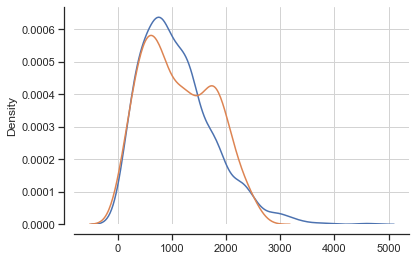

In [250]:
sns.kdeplot(scale*np.random.weibull(a=shape, size=1000))
sns.kdeplot(y["time"])
sns.despine(offset=10)

In [947]:
np.quantile(a, np.linspace(0.025, 0.975, 100))

array([   1.675     ,    1.93409091,    2.19318182,    2.45227273,
          2.71136364,    2.97045455,    3.22954545,    3.48863636,
          3.74772727,    4.00681818,    4.26590909,    4.525     ,
          4.78409091,    5.04318182,    5.30227273,    5.56136364,
          5.82045455,    6.07954545,    6.33863636,    6.59772727,
          6.85681818,    7.11590909,    7.375     ,    7.63409091,
          7.89318182,    8.15227273,    8.41136364,    8.67045455,
          8.92954545,    9.18863636,    9.44772727,    9.70681818,
          9.96590909,   34.75      ,   63.25      ,   91.75      ,
        120.25      ,  148.75      ,  177.25      ,  205.75      ,
        234.25      ,  262.75      ,  291.25      ,  319.75      ,
        348.25      ,  376.75      ,  405.25      ,  433.75      ,
        462.25      ,  490.75      ,  519.25      ,  547.75      ,
        576.25      ,  604.75      ,  633.25      ,  661.75      ,
        690.25      ,  718.75      ,  747.25      ,  775.75   

<Axes: ylabel='Density'>

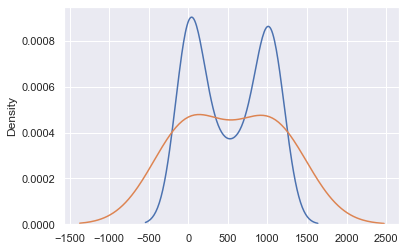

In [946]:
a = np.array([1, 10, 1000, 1100])  # y["time"][:5]
sns.kdeplot(np.quantile(a, np.linspace(0.025, 0.975, 100)))
sns.kdeplot(a)

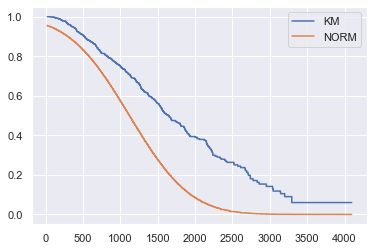

In [924]:
kmza = KaplanMeierZeroAfter1()
kmza.fit(y["time"], y["cens"])
plt.step(kmza.timeline, kmza.survival_function_at_times(kmza.timeline), label="KM")
plt.step(kmza.timeline, norm.sf(kmza.timeline, loc=np.mean(y["time"]), scale=np.std(y["time"])), label="NORM")
plt.legend()
plt.show()

<Axes: ylabel='Density'>

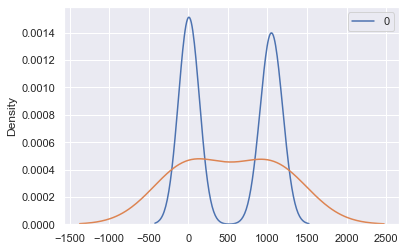

In [1199]:
from sklearn.neighbors import KernelDensity

a = np.array([1, 10, 1000, 1100])
kde = KernelDensity(kernel="tophat", bandwidth=30).fit(a.reshape(-1, 1))
sns.kdeplot(kde.sample(1000, random_state=42))
sns.kdeplot(a)

In [ ]:
KaplanMeierZeroAfter1

In [368]:
from survivors.tree.stratified_model import KaplanMeier, WeightSurviveModel, NelsonAalen, LeafModel

    
class KaplanMeierZeroAfter1(KaplanMeier):
    def fit(self, durations, right_censor, weights=None):
#         ind = np.random.choice(np.arange(len(durations), dtype=int), size=1000, replace=True)
#         durs = np.array(durations)[ind]
#         events = np.array(right_censor)[ind]
        
#         durs = np.random.normal(np.mean(durations), np.std(durations), 100)
#         events = np.ones_like(durs)

#         durs = np.hstack([durations, np.random.normal(np.mean(durations), np.std(durations), 100)])
#         events = np.hstack([right_censor, np.random.choice(right_censor, size=100, replace=True)])
        
#         self.durs = np.random.normal(np.mean(durations), np.std(durations)/np.sqrt(2), 1000)
#         self.events = np.random.choice(right_censor, size=1000, replace=True)
        
#         print(shapiro(durations).pvalue)
        self.durs = np.array(durations)
        self.events = np.array(right_censor)
        
#         self.durs = np.random.weibull(a=2, size=1000)*np.mean(durations)
#         self.events = np.random.choice(right_censor, size=1000, replace=True)

#         shape, loc, scale = weibull_min.fit(durations, floc=0)
#         self.durs = scale*np.random.weibull(a=shape, size=1000)
#         self.events = np.random.choice(right_censor, size=1000, replace=True)
        
#         qs = np.quantile(durations, np.linspace(0.025, 0.975, 100))
#         self.durs = np.random.choice(qs, size=1000, replace=True)
#         self.events = np.random.choice(right_censor, size=1000, replace=True)

#         kde = KernelDensity(kernel="tophat", bandwidth=100).fit(np.quantile(durations, np.linspace(0.025, 0.975, 100)).reshape(-1, 1))
#         self.durs = kde.sample(1000, random_state=42).ravel()
#         self.events = np.random.choice(right_censor, size=1000, replace=True)
        
        super().fit(self.durs, self.events)
        
    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
#         place_bin = np.digitize(times, self.timeline) # - 1
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times < self.timeline[0]] = 1
        return sf

class NelsonAalen1(NelsonAalen):
    def fit(self, durations, right_censor, weights=None):
        self.durs = np.array(durations)
        self.events = np.array(right_censor)
        
#         self.durs = np.random.normal(np.mean(durations), np.std(durations)/np.sqrt(2), 1000)
#         self.events = np.random.choice(right_censor, size=1000, replace=True)
        
        super().fit(self.durs, self.events)
    
class WeightSurviveModelZeroAfter1(WeightSurviveModel):
    def predict_survival_at_times(self, X=None, bins=None):
        if bins is None:
            bins = self.default_bins
        if self.survival is None:
            self.survival = KaplanMeierZeroAfter1()
            self.survival.fit(self.lists[cnt.TIME_NAME],
                              self.lists[cnt.CENS_NAME],
                              self.weights)
        sf = self.survival.survival_function_at_times(bins)
        if X is None:
            return sf
        return np.repeat(sf[np.newaxis, :], X.shape[0], axis=0)
    
    def predict_hazard_at_times(self, X=None, bins=None):
        if self.hazard is None:
            self.hazard = NelsonAalen1()
            self.hazard.fit(self.lists[cnt.TIME_NAME],
                            self.lists[cnt.CENS_NAME],
                            self.weights)
        if bins is None:
            bins = self.hazard.timeline
        hf = self.hazard.cumulative_hazard_at_times(bins)
        if X is None:
            return hf
        return np.repeat(hf[np.newaxis, :], X.shape[0], axis=0)
    
#     def predict_feature(self, X=None, feature_name=None):
#         self.predict_survival_at_times()
#         if not(X is None) and feature_name == "time":
#             return np.repeat(np.trapz(self.survival.survival_function, np.hstack([0, self.survival.timeline])), X.shape[0], axis=0)
#         return super().predict_feature(X, feature_name)

class NormWeightSurviveModelZeroAfter(WeightSurviveModel):
    def predict_survival_at_times(self, ch, bins=None):
        mean, std, prob = ch
        durs = np.random.normal(mean, std/np.sqrt(2), 1000)
        events = np.random.binomial(1, prob, size=1000)
            
        self.survival = KaplanMeierZeroAfter()
        self.survival.fit(durs, events)
        if bins is None:
            bins = self.hazard.timeline
        sf = self.survival.survival_function_at_times(bins)
        if X is None:
            return sf
        return np.repeat(sf[np.newaxis, :], X.shape[0], axis=0)
    
    def predict_hazard_at_times(self, ch, bins=None):
        mean, std, prob = ch
        durs = np.random.normal(mean, std/np.sqrt(2), 1000)
        events = np.random.binomial(1, prob, size=1000)
        
        self.hazard = NelsonAalen()
        self.hazard.fit(durs, events)
        
        if bins is None:
            bins = self.hazard.timeline
        hf = self.hazard.cumulative_hazard_at_times(bins)
        if X is None:
            return hf
        return np.repeat(hf[np.newaxis, :], X.shape[0], axis=0)

class BaseFastSurviveModelZeroAfter1(WeightSurviveModelZeroAfter1):
    def __init__(self):
        super().__init__(weights_name=None)
        
class NormSurviveModelZeroAfter(NormWeightSurviveModelZeroAfter):
    def __init__(self):
        super().__init__(weights_name=None)

In [5]:
import numpy as np
from numba import njit

from scipy import stats
from survivors.tree.stratified_model import KaplanMeier, FullProbKM, NelsonAalen, KaplanMeierZeroAfter
from survivors.metrics import ibs_WW, auprc
from survivors.constants import get_y

""" Auxiliary functions """


@njit('f4(f4[:], f4[:], f4[:], f4[:], u4, f4[:])', cache=True)
def lr_hist_statistic(time_hist_1, time_hist_2, cens_hist_1, cens_hist_2,
                      weightings, obs_weights):
    N_1_j = np.cumsum(time_hist_1[::-1])[::-1]
    N_2_j = np.cumsum(time_hist_2[::-1])[::-1]
    
    ind = np.where(N_1_j + N_2_j > 0)[0]
#     ind = np.where((cens_hist_1 + cens_hist_2 != 0) & (N_1_j * N_2_j != 0))[0]
#     ind = np.where((cens_hist_1 + cens_hist_2 != 0) & (N_1_j + N_2_j > 0))[0]
    if ind.shape[0] == 0:
        return 0.0

    N_1_j = N_1_j[ind]
    N_2_j = N_2_j[ind]
    O_1_j = cens_hist_1[ind]
    O_2_j = cens_hist_2[ind]

    N_j = N_1_j + N_2_j
    O_j = O_1_j + O_2_j
    E_1_j = N_1_j * O_j / N_j
    
    res = np.zeros((N_j.shape[0], 3), dtype=np.float32)
    res[:, 1] = O_1_j - E_1_j
    res[:, 2] = E_1_j * (N_j - O_j) * N_2_j / (N_j * (N_j))  # N_j

#     sf1 = np.cumprod((1.0 - O_1_j / (N_1_j + 1)))
#     sf1[N_1_j == 0] = 0.0

#     sf2 = np.cumprod((1.0 - O_2_j / (N_2_j + 1)))
#     sf2[N_2_j == 0] = 0.0

#     res[:, 1] = sf1 - sf2
#     res[:, 2] = 1
    
    res[:, 0] = 1.0
    if weightings == 2:
        res[:, 0] = N_j
    elif weightings == 3:
        res[:, 0] = np.sqrt(N_j)
    elif weightings == 4:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    elif weightings == 5:
        res[:, 0] = obs_weights[ind]
    elif weightings == 6:
        res[:, 0] = O_j/N_j
    elif weightings == 7:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    elif weightings == 8:
        res[:, 0] = N_j/(N_1_j*N_2_j)
#     var = np.trapz((res[:, 0] * res[:, 0] * res[:, 2]), bins[ind])
#     num = np.trapz((res[:, 0] * res[:, 1]), bins[ind])
    var = (res[:, 0] * res[:, 0] * res[:, 2]).sum()
    num = (res[:, 0] * res[:, 1]).sum()
    
    if var == 0:
        return 0
    stat_val = np.power(num, 2) / var
    
#     var2 = (res[::-1, 0] * res[::-1, 0] * res[:, 2]).sum()
#     num2 = (res[::-1, 0] * res[:, 1]).sum()
#     stat_val += np.power(num2, 2) / var2

    if weightings == 7:
        res[:, 0] = 1 - res[:, 0]
        stat_val2 = np.power((res[:, 0] * res[:, 1]).sum(), 2) / ((res[:, 0] * res[:, 0] * res[:, 2]).sum())
        stat_val = max(stat_val, stat_val2)
    return stat_val

def weight_hist_stat(time_hist_1, time_hist_2, cens_hist_1=None, cens_hist_2=None, 
                     weights_hist=None, weightings=""):
    try:
        if cens_hist_1 is None:
            cens_hist_1 = time_hist_1
        if cens_hist_2 is None:
            cens_hist_2 = time_hist_2
        if weights_hist is None:
            weights_hist = np.ones_like(time_hist_1)
        d = {"logrank": 1, "wilcoxon": 2, "tarone-ware": 3, "peto": 4, "weights": 5}
        d.update({"diff": 6, "maxcombo": 7, "frac": 8})
        weightings = d.get(weightings, 1)
        
        logrank = lr_hist_statistic(time_hist_1.astype("float32"),
                            time_hist_2.astype("float32"),
                            cens_hist_1.astype("float32"),
                            cens_hist_2.astype("float32"),
                            np.uint32(weightings),
                            weights_hist.astype("float32")
                           ) 
        return logrank
    except Exception as err:
        print(err)
        return 0.0

    
def optimal_criter_split_hist(left_time_hist, left_cens_hist,
                              right_time_hist, right_cens_hist,
                              na_time_hist, na_cens_hist, weights_hist, criterion, dis_coef, 
                              apr_t_distr, apr_e_distr, l_reg):
    none_to = 0
    max_stat_val = 1.0
    
#     n1 = np.cumsum(left_time_hist[::-1])[::-1] + 1
#     n2 = np.cumsum(right_time_hist[::-1])[::-1] + 1
#     cf = n1/(n1 + n2)
    cf = 0.5
    
#     n1 = np.sum(left_time_hist)
#     n2 = np.sum(right_time_hist)
#     cf = n1/(n1 + n2)
    
#     ev = np.sum(left_cens_hist + right_cens_hist)
#     ev_cf = ev/(n1 + n2)
#     lstd = np.std(np.repeat(np.arange(left_time_hist.size), left_time_hist.astype(int)))
#     rstd = np.std(np.repeat(np.arange(right_time_hist.size), right_time_hist.astype(int)))
    
    if na_time_hist.shape[0] > 0:
        a = weight_hist_stat(left_time_hist + na_time_hist + l_reg*apr_t_distr*cf, 
                             right_time_hist + l_reg*apr_t_distr*(1 - cf),
                             left_cens_hist + na_cens_hist + l_reg*apr_e_distr*cf, 
                             right_cens_hist + l_reg*apr_e_distr*(1 - cf),
                             weights_hist, weightings=criterion)
        b = weight_hist_stat(left_time_hist + l_reg*apr_t_distr*cf, 
                             right_time_hist + na_time_hist + l_reg*apr_t_distr*(1 - cf),
                             left_cens_hist + l_reg*apr_e_distr*cf,
                             right_cens_hist + na_cens_hist + l_reg*apr_e_distr*(1 - cf),
                             weights_hist, weightings=criterion)
        # Nans move to a leaf with maximal statistical value
        none_to = int(a < b)
        max_stat_val = max(a, b)
    else:
        max_stat_val = weight_hist_stat(left_time_hist + l_reg*apr_t_distr*cf,
                                        right_time_hist + l_reg*apr_t_distr*(1 - cf),
                                        left_cens_hist + l_reg*apr_e_distr*cf, 
                                        right_cens_hist + l_reg*apr_e_distr*(1 - cf),
                                        weights_hist, weightings=criterion)
#         fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#         axes[0].step(np.arange(left_time_hist.shape[0]), sf_by_hist(left_time_hist, left_cens_hist))
#         axes[0].step(np.arange(left_time_hist.shape[0]), sf_by_hist(right_time_hist, right_cens_hist))
#         axes[1].step(np.arange(left_time_hist.shape[0]), sf_by_hist(left_time_hist + l_reg*apr_t_distr*cf, left_cens_hist))
#         axes[1].step(np.arange(left_time_hist.shape[0]), sf_by_hist(right_time_hist + l_reg*apr_t_distr*(1 - cf), right_cens_hist))
#         plt.title(max_stat_val)
#         plt.show()
    return (max_stat_val, none_to)


def get_attrs(max_stat_val, values, none_to, l_sh, r_sh, nan_sh, stat_diff=None):
    attrs = dict()
    attrs["stat_val"] = max_stat_val
    attrs["values"] = values
    attrs["stat_diff"] = stat_diff 
    if none_to:
        attrs["pos_nan"] = [0, 1]
        attrs["min_split"] = min(l_sh, r_sh + nan_sh)
    else:
        attrs["pos_nan"] = [1, 0]
        attrs["min_split"] = min(l_sh + nan_sh, r_sh)
    return attrs


def transform_woe_np(x_feat, y):
    N_T = y.shape[0]
    N_D = y.sum()
    N_D_ = N_T - N_D
    x_uniq = np.unique(x_feat)
    x_dig = np.digitize(x_feat, x_uniq) - 1

    df_woe_iv = np.vstack([np.bincount(x_dig[y == 0], minlength=x_uniq.shape[0]),
                           np.bincount(x_dig[y == 1], minlength=x_uniq.shape[0])])
    all_0 = df_woe_iv[0].sum()
    all_1 = df_woe_iv[1].sum()

    p_bd = (df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    p_bd_ = (df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)
    p_b_d = (all_1 - df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    p_b_d_ = (all_0 - df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)

    woe_pl = np.log(p_bd / p_bd_)
    woe_mn = np.log(p_b_d / p_b_d_)
    descr_np = np.vstack([x_uniq, woe_pl - woe_mn])
    features_woe = dict(zip(descr_np[0], descr_np[1]))
    woe_x_feat = np.vectorize(features_woe.get)(x_feat)
    return (woe_x_feat, descr_np)


def get_sa_hists(time, cens, minlength=1, weights=None):
    if time.shape[0] > 0:
        time_hist = np.bincount(time, minlength=minlength)
        cens_hist = np.bincount(time, weights=cens, minlength=minlength)
    else:
        time_hist, cens_hist = np.array([]), np.array([])
    return time_hist, cens_hist


def select_best_split_info(attr_dicts, type_attr, bonf=True, descr_woe=None):  
#     print(sorted([np.round(x["stat_diff"], 3) for x in attr_dicts]))
    
#     attr_dicts = sorted(attr_dicts, key=lambda x: abs(x["stat_diff"]), reverse=True)[:max(1, len(attr_dicts)//2)]
#     attr_dicts = sorted(attr_dicts, key=lambda x: abs(x["stat_diff"]), reverse=True)[:max(1, len(attr_dicts) - 2)]
#     attr_dicts = sorted(attr_dicts, key=lambda x: abs(x["stat_diff"]))[:max(1, len(attr_dicts)//2)]
    best_attr = max(attr_dicts, key=lambda x: x["stat_val"])
                                                                       
    best_attr["p_value"] = stats.chi2.sf(best_attr["stat_val"], df=1)
    best_attr["sign_split"] = len(attr_dicts)
    if best_attr["sign_split"] > 0:
        best_attr["src_val"] = best_attr['values']
        if type_attr == "cont":
            best_attr["values"] = [f" <= {best_attr['values']}", f" > {best_attr['values']}"]
        elif type_attr == "woe" or type_attr == "categ":
            ind = descr_woe[1] <= best_attr["values"]
            l, r = list(descr_woe[0, ind]), list(descr_woe[0, ~ind])
            best_attr["values"] = [f" in {e}" for e in [l, r]]
        if bonf:
            best_attr["p_value"] *= best_attr["sign_split"]
    return best_attr


def split_time_to_bins(time, event=None, apr_times=None, apr_events=None):
#     if apr_times is None:
#         return np.searchsorted(np.unique(time), time)
#     return np.searchsorted(np.unique(apr_times), time)
    if apr_times is None:
        return np.searchsorted(np.arange(int(time.min() - 1), int(time.max() + 1)), time)
    return np.searchsorted(np.arange(int(apr_times.min() - 1), int(apr_times.max() + 1)), time)
#     if apr_times is None:
#         n = np.clip(time[np.where(event)].shape[0] // 5, 2, 20)
#         return np.searchsorted(np.quantile(time[np.where(event)], np.arange(n + 1)/n), time)
#     n = np.clip(apr_times[np.where(apr_events)].shape[0] // 5, 2, 20)
#     return np.searchsorted(np.quantile(apr_times[np.where(apr_events)], np.arange(n + 1)/n), time)


def ranksums_hist(x, y):
    n1 = np.sum(x)
    n2 = np.sum(y)
    rank = np.arange(1, x.shape[0] + 1)
    s = np.dot(x, rank)
#     print(s)
    expected = n1 * (n1+n2+1) / 2.0
    z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
    return z

def diptest_hist(x, y):
    res = 0
    if np.sum(x) > 0:
        t1 = np.repeat(np.arange(1, x.size + 1), x.astype(int))
        res = max(res, diptest.dipstat(t1))
    if np.sum(y) > 0:
        t2 = np.repeat(np.arange(1, y.size + 1), y.astype(int))
        res = max(res, diptest.dipstat(t2))
    return res

def stdtest_hist(x, y):
    res = 0
    if np.sum(x) > 0:
        t1 = np.repeat(np.arange(1, x.size + 1), x.astype(int))
        res = max(res, t1.std())
    if np.sum(y) > 0:
        t2 = np.repeat(np.arange(1, y.size + 1), y.astype(int))
        res = max(res, t2.std())
    return res

def iqrtest_hist(x, y):
    res = 0
    if np.sum(x) > 0:
        t1 = np.repeat(np.arange(1, x.size + 1), x.astype(int))
        res = max(res, stats.iqr(t1))
    if np.sum(y) > 0:
        t2 = np.repeat(np.arange(1, y.size + 1), y.astype(int))
        res = max(res, stats.iqr(t2))
    return res


def sf_by_hist(time, cens):
    c_time = np.cumsum(time[::-1])[::-1]
    sf = np.cumprod((1.0 - cens / (c_time + 1)))
    sf[c_time == 0] = 0.0
    return sf

def count_sf_diff(time, cens, prior_prob=0.5):
    sf = sf_by_hist(time, cens)
    return np.sum((sf - prior_prob)**2) / sf.shape[0] # max(1, bins[-1] - bins[0])

def cnttest_hist(time_1, cens_1, time_2, cens_2):
    en = np.sum(cens_1 + cens_2)
    on = np.sum(time_1 + time_2)
    d1 = count_sf_diff(time_1, cens_1)
    d2 = count_sf_diff(time_2, cens_2)
    return min(d1, d2)

def inverse_bincount_sf(time_hist, cens_hist):
    evs = np.repeat(np.arange(1, time_hist.size + 1), cens_hist)
    cns = np.repeat(np.arange(1, time_hist.size + 1), time_hist - cens_hist)
    
    return get_y(time=np.hstack([evs, cns]),
               cens=np.hstack([np.ones_like(evs), np.zeros_like(cns)]))

def ibstest_hist(time_1, cens_1, time_2, cens_2, bins):
    y_1 = inverse_bincount_sf(time_1.astype(int), cens_1.astype(int))
    y_2 = inverse_bincount_sf(time_2.astype(int), cens_2.astype(int))
    
    sf_1 = np.cumprod((1.0 - cens_1 / (time_1 + 1)))
    sf_2 = np.cumprod((1.0 - cens_2 / (time_2 + 1)))
    
    sf_1 = np.repeat(sf_1[np.newaxis, :], y_1.shape[0], axis=0)
    sf_2 = np.repeat(sf_2[np.newaxis, :], y_2.shape[0], axis=0)
    
    ibs_1 = metr.ibs_remain(y_1, y_1, sf_1, bins)
    ibs_2 = metr.ibs_remain(y_2, y_2, sf_2, bins)
    return max(ibs_1, ibs_2)

def peaktest_hist(x, y):
    return max(max_width_peaks(x), max_width_peaks(y))

def mw_hist(x, y):
    n1 = np.sum(x)
    n2 = np.sum(y)
    rank = np.arange(1, x.shape[0] + 1)
    R1 = np.dot(x, rank)
    U1 = R1 - n1*(n1+1)/2
    U2 = n1 * n2 - U1

    U = np.maximum(U1, U2)
    return U

def hist_best_attr_split(arr, criterion="logrank", type_attr="cont", weights=None, thres_cont_bin_max=100,
                         signif=1.0, signif_stat=0.0, min_samples_leaf=10, bonf=True, verbose=0, balance=False, 
                         apr_time=None, apr_event=None, l_reg=0, **kwargs):
    best_attr = {"stat_val": signif_stat, "p_value": signif,
                 "sign_split": 0, "values": [], "pos_nan": [1, 0]}
    if arr.shape[1] < 2 * min_samples_leaf:
        return best_attr
    vals = arr[0].astype("float")
    cens = arr[1].astype("uint")
    dur = arr[2].astype("float")
    
    if np.sum(cens) == 0:
        return best_attr
    if weights is None:
        weights = np.ones_like(dur)
    
#     n = np.clip(dur[np.where(cens)].shape[0] // 5, 2, 20)
#     weights_hist = np.diff(np.hstack([0, np.quantile(dur[np.where(cens)], np.arange(n + 1)/n)])) # None
#     criterion = "weights"
    
    weights_hist = None
    
#     dur = split_time_to_bins(dur, apr_time)
    
    if apr_time is None:
        dur = split_time_to_bins(dur, cens) #, apr_time)
    else:
        apr_time_1 = split_time_to_bins(apr_time, apr_event, dur, cens) #, apr_time)
        dur = split_time_to_bins(dur, cens)
    
    if apr_time is None:
#         time_bins = np.arange(int(dur.min() - 1), int(dur.max() + 1)) # np.unique(dur)
        max_bin = dur.max()
        apr_t_distr = np.zeros(max_bin + 1)
        apr_e_distr = np.zeros(max_bin + 1)
    else:
        #time_bins = np.arange(int(apr_time.min() - 1), int(apr_time.max() + 1)) # np.unique(apr_time)
        # apr_time_1 = split_time_to_bins(apr_time, dur)
        max_bin = apr_time_1.max()
        apr_t_distr, apr_e_distr = get_sa_hists(apr_time_1, apr_event, minlength=max_bin + 1)
    
    ind = np.isnan(vals)

    # split nan and not-nan
    dur_notna = dur[~ind]
    cens_notna = cens[~ind]
    vals_notna = vals[~ind]
    weights_notna = weights[~ind]

    dis_coef = 1
    if balance:
        dis_coef = (cens.shape[0] - np.sum(cens)) / np.sum(cens)

    if dur_notna.shape[0] < min_samples_leaf:
        return best_attr

    descr_woe = None
    if type_attr == "woe" or type_attr == "categ":
        vals_notna, descr_woe = transform_woe_np(vals_notna, cens_notna)

    # find splitting values
    uniq_set = np.unique(vals_notna)
    if uniq_set.shape[0] > thres_cont_bin_max:
        uniq_set = np.quantile(vals_notna, [i / float(thres_cont_bin_max) for i in range(1, thres_cont_bin_max)])
    else:
        uniq_set = (uniq_set[:-1] + uniq_set[1:]) * 0.5
    uniq_set = np.unique(np.round(uniq_set, 3))

    index_vals_bin = np.digitize(vals_notna, uniq_set, right=True)

    # find global hist by times
    na_time_hist, na_cens_hist = get_sa_hists(dur[ind], cens[ind],
                                              minlength=max_bin + 1, weights=weights[ind])

    r_time_hist, r_cens_hist = get_sa_hists(dur_notna, cens_notna,
                                            minlength=max_bin + 1, weights=weights_notna)
    l_time_hist = np.zeros_like(r_time_hist, dtype=np.float32)
    l_cens_hist = l_time_hist.copy()
    
#     print(apr_t_distr, r_time_hist)
    num_nan = ind.sum()
    num_r = dur_notna.shape[0]
    num_l = 0

    if criterion == "confident" or criterion == "confident_weights":
        kmf = KaplanMeier()
        if criterion == "confident_weights":
            kmf.fit(dur, cens, weights=weights)
        else:
            kmf.fit(dur, cens)
        ci = kmf.get_confidence_interval_()
        weights_hist = 1 / (ci[1:, 1] - ci[1:, 0] + 1)  # (ci[1:, 1] + ci[1:, 0] + 1e-5)
        criterion = "weights"
    elif criterion == "fullprob":
        kmf = FullProbKM()
        kmf.fit(dur, cens)
        weights_hist = kmf.survival_function_at_times(np.unique(dur))
        criterion = "weights"
    elif criterion == "ibswei":
        kmf = KaplanMeierZeroAfter()
        dur_ = arr[2].copy()
        kmf.fit(dur_, cens)

        dd = np.unique(dur_)
        sf = kmf.survival_function_at_times(dd)
        sf = np.repeat(sf[np.newaxis, :], dd.shape[0], axis=0)

        y_ = get_y(cens=np.ones_like(dd), time=dd)
        y_["cens"] = True
        weights_hist = ibs_WW(y_, y_, sf, dd, axis=0)
        weights_hist = np.cumsum(weights_hist[::-1])[::-1]
        criterion = "weights"
    elif criterion == "T-ET":
        kmf = KaplanMeierZeroAfter()
        dur_ = arr[2].copy()
        kmf.fit(dur_, cens)

        dd = np.unique(dur_)
        ET = np.trapz(kmf.survival_function_at_times(dd), dd)
        weights_hist = (dd - ET)  # **2
        criterion = "weights"
    elif criterion == "kde":
        na = NelsonAalen()
        na.fit(dur, cens, np.ones(len(dur)))
        weights_hist = na.get_smoothed_hazard_at_times(np.unique(dur))
        criterion = "weights"
    elif criterion == "weights":
        weights_hist = np.bincount(dur, weights=weights,
                                   minlength=max_bin + 1)
        weights_hist = np.cumsum(weights_hist[::-1])[::-1]

        weights_hist = weights_hist / weights_hist.sum()

    # for each split values get branches
    attr_dicts = []
    
    for u in np.unique(index_vals_bin):
        curr_mask = index_vals_bin == u
        curr_n = curr_mask.sum()
        curr_time_hist, curr_cens_hist = get_sa_hists(dur_notna[curr_mask], cens_notna[curr_mask],
                                                      minlength=max_bin + 1, weights=weights_notna[curr_mask])
        l_time_hist += curr_time_hist
        l_cens_hist += curr_cens_hist
        r_time_hist -= curr_time_hist
        r_cens_hist -= curr_cens_hist
        num_l += curr_n
        num_r -= curr_n

        if min(num_l, num_r) <= min_samples_leaf:
            continue
            
#         plt.plot(l_time_hist)
#         plt.plot(r_time_hist)
#         plt.plot(apr_t_distr)
#         plt.show()

#         l_times1 = np.repeat(np.arange(1, l_time_hist.size + 1), l_time_hist.astype(int))
#         lmin, lmax = l_times1.min(), l_times1.max()
#         l_times1 = np.random.normal(l_times1.mean(), l_times1.std(), 100).astype(int)
#         l_times1 = np.clip(l_times1, lmin, lmax - 1)
#         l_time_hist1, l_cens_hist1 = get_sa_hists(l_times1, np.ones_like(l_times1), minlength=max_bin + 1)
        
#         r_times1 = np.repeat(np.arange(1, r_time_hist.size + 1), r_time_hist.astype(int))
#         rmin, rmax = r_times1.min(), r_times1.max()
#         r_times1 = np.random.normal(r_times1.mean(), r_times1.std(), 100).astype(int)
#         r_times1 = np.clip(r_times1, rmin, rmax - 1)
#         r_time_hist1, r_cens_hist1 = get_sa_hists(r_times1, np.ones_like(r_times1), minlength=max_bin + 1)
        
        max_stat_val, none_to = optimal_criter_split_hist(
            l_time_hist, l_cens_hist, r_time_hist, r_cens_hist,
            na_time_hist, na_cens_hist, weights_hist, criterion, dis_coef, 
            apr_t_distr, apr_e_distr, l_reg)
        
#         print(l_cens_hist, r_cens_hist, max_stat_val)
        
        if max_stat_val > signif_stat:
            stat_diff = 1
#             if na_time_hist.shape[0] > 0:
#                 stat_diff = stdtest_hist((l_time_hist + (1 - none_to)*na_time_hist), 
#                                          (r_time_hist + none_to*na_time_hist))
#             else:
#                 stat_diff = stdtest_hist(l_time_hist,
#                                          r_time_hist)

#             if na_time_hist.shape[0] > 0:
#                 stat_diff = cnttest_hist((l_time_hist + (1 - none_to)*na_time_hist), 
#                                          (l_cens_hist + (1 - none_to)*na_cens_hist), 
#                                          (r_time_hist + none_to*na_time_hist),
#                                          (r_cens_hist + none_to*na_cens_hist))
#             else:
#                 stat_diff = cnttest_hist(l_time_hist, l_cens_hist, r_time_hist, r_cens_hist)
    
            attr_loc = get_attrs(max_stat_val, uniq_set[u], none_to, num_l, num_r, num_nan, stat_diff)
            attr_dicts.append(attr_loc)
            
#     attr_dicts = list(filter(lambda x: x["stat_diff"] < 0.5, attr_dicts))
    if len(attr_dicts) == 0:
            return best_attr
    
#     if na_time_hist.shape[0] > 0:
#         sh_diff = count_sf_diff(r_time_hist + l_time_hist + na_time_hist, 
#                                 r_cens_hist + l_cens_hist + na_cens_hist)
#     else:
#         sh_diff = count_sf_diff(r_time_hist + l_time_hist, 
#                                 r_cens_hist + l_cens_hist)
    
# #     plt.hist([v["stat_diff"] for v in attr_dicts])
# #     xmin, xmax, ymin, ymax = plt.axis()
    
# #     plt.vlines([sh_diff], ymin=0, ymax=ymax, color="red")
# #     plt.show()
#     attr_dicts = list(filter(lambda x: x["stat_diff"] > sh_diff/2, attr_dicts))
#     if len(attr_dicts) == 0:
#         return best_attr
    
#     print(attr_dicts)
    best_attr = select_best_split_info(attr_dicts, type_attr, bonf, descr_woe=descr_woe)
    
    if verbose > 0:
        print(signif_stat, best_attr["stat_val"], len(attr_dicts))
    return best_attr

In [6]:
from survivors.tree.node import Node, Rule
from survivors.tree import CRAID

class Node1(Node):
    def check_params(self):
        super().check_params()
        self.ch = np.array([np.mean(self.df["time"]), np.std(self.df["time"]), np.sum(self.df["cens"])/self.df["cens"].shape[0]])
        
#     def check_params(self):
#         self.info.setdefault("bonf", True)
#         self.info.setdefault("n_jobs", 16)
#         self.info.setdefault("max_features", 1.0)
#         self.info.setdefault("signif", 1.1)
#         self.info.setdefault("signif_stat", stats.chi2.isf(min(self.info["signif"], 1.0), df=1))
#         self.info.setdefault("thres_cont_bin_max", 100)
#         if self.info["max_features"] == "sqrt":
#             self.info["max_features"] = int(np.trunc(np.sqrt(len(self.features))+0.5))
#         elif isinstance(self.info["max_features"], float):
#             self.info["max_features"] = int(self.info["max_features"]*len(self.features))

#         self.info.setdefault("weights_feature", None)
#         if not(self.info["weights_feature"] is None):
#             self.info["weights"] = self.df[self.info["weights_feature"]].to_numpy()

#         self.info.setdefault("leaf_model", "base")
#         if isinstance(self.info["leaf_model"], str):
#             self.leaf_model = LEAF_MODEL_DICT.get(self.info["leaf_model"], "base")()
#         elif isinstance(self.info["leaf_model"], type):  # Check is class
#             self.leaf_model = self.info["leaf_model"]()
#             if not(isinstance(self.leaf_model, LeafModel)):
#                 self.leaf_model = None
#         else:
#             self.leaf_model = None
#         self.size = self.df.shape[0]
        
#         if "l_reg" in self.info:
#             dur = split_time_to_bins(self.df["time"], self.df["cens"])
#             max_bin = dur.max()
#             time_hist, cens_hist = get_sa_hists(dur, self.df["cens"],
#                                                       minlength=max_bin + 1)
#             cnt_sim = count_sf_diff(time_hist, cens_hist, prior_prob=0.5)
#             ratio = 1 - (0.25 - cnt_sim) / 0.25
#             n = int(np.clip(ratio * 1000, 1, 999))
            
# #             ind1 = np.random.choice(np.arange(len(self.df["time"]), dtype=int), size=n, replace=True)
# #             durs1 = np.array(self.df["time"])[ind1]
# #             events1 = np.array(self.df["cens"])[ind1]
            
# #             ind2 = np.random.choice(np.arange(len(self.info["apr_time"]), dtype=int), size=1000-n, replace=True)
# #             durs2 = np.array(self.info["apr_time"])[ind2]
# #             events2 = np.array(self.info["apr_event"])[ind2]

#             dur = np.hstack([np.random.choice(self.df["time"], size=n, replace=True), 
#                               np.random.choice(self.info["apr_time"], size=1000 - n, replace=True)])
#             event = np.random.choice(self.df["cens"], size=1000, replace=True)
# #             dur = np.hstack([durs1, durs2])
# #             event = np.hstack([events1, events2])
            
#             self.leaf_model.fit(pd.DataFrame(np.array([dur, event]).T, columns=["time", "cens"]))
#         else:
#             self.leaf_model.fit(self.df)
        
    def get_comb_fast(self, features):
        X = self.df.loc[:, features + [cnt.CENS_NAME, cnt.TIME_NAME]].to_numpy().T.copy()

        def create_params_f(v_feature, name):
            d = self.info.copy()
            d["arr"] = np.vstack((v_feature.copy(), X[-2:].copy()))
            d["type_attr"] = ("woe" if self.woe else "categ") if name in self.categ else "cont"
            return d

        return list(map(create_params_f, X[:-2].copy(), features))

    def find_best_split(self):
        numb_feats = self.info["max_features"]
        numb_feats = np.clip(numb_feats, 1, len(self.features))
        n_jobs = min(numb_feats, self.info["n_jobs"])

        selected_feats = list(np.random.choice(self.features, size=numb_feats, replace=False))
        args = self.get_comb_fast(selected_feats)

        ml = np.vectorize(lambda x: hist_best_attr_split(**x))(args)
        attrs = {f: ml[ind] for ind, f in enumerate(selected_feats)}
        attr = max(attrs, key=lambda x: attrs[x]["stat_val"])
#         attrs_gr = dict(filter(lambda x: x[1]["sign_split"] > 0, attrs.items()))
#         if len(attrs_gr) == 0:
#             attr = min(attrs, key=lambda x: attrs[x]["p_value"])
#         else:
#             attr = min(attrs_gr, key=lambda x: attrs_gr[x]["p_value"])
#             if self.info["bonf"]:
#                 attrs[attr]["p_value"] = attrs[attr]["p_value"] / attrs[attr]["sign_split"]

#         if attrs[attr]["sign_split"] > 0 and self.info["bonf"]:  # suffix for simple p-value
#             attrs[attr]["p_value"] = attrs[attr]["p_value"] / attrs[attr]["sign_split"]
        
        return (attr, attrs[attr])
    
    def split(self):
        node_edges = np.array([], dtype=int)
        self.rule_edges = np.array([], dtype=Rule)
        
        attr, best_split = self.find_best_split()
        
        # The best split is not significant
        if best_split["sign_split"] == 0:
            if self.verbose > 0:
                print(f'Конец ветви, незначащее p-value: {best_split["p_value"]}')
            return node_edges
        if self.verbose > 0:
            print('='*6, best_split["stat_val"], attr)

        branch_ind = self.ind_for_nodes(self.df[attr], best_split, attr in self.categ)

        for n_b in np.unique(branch_ind):
            rule = Rule(feature=attr,
                        condition=best_split["values"][n_b],
                        has_nan=best_split["pos_nan"][n_b])
            d_node = self.df[branch_ind == n_b].copy()
            N = Node1(df=d_node, full_rule=self.full_rule + [rule],
                     features=self.features, categ=self.categ,
                     depth=self.depth + 1, verbose=self.verbose, **self.info)
            node_edges = np.append(node_edges, N)
            self.rule_edges = np.append(self.rule_edges, rule)

        if self.rule_edges.shape[0] == 1:
            print(branch_ind, self.df[attr], best_split, attr in self.categ)
            raise ValueError('ERROR: Only one branch created!')

        return node_edges

class CRAID1(CRAID):
    def update_params(self, X_tr):
        if not ("min_samples_leaf" in self.info):
            self.info["min_samples_leaf"] = 0.01
        if isinstance(self.info["min_samples_leaf"], float):
            self.info["min_samples_leaf"] = max(int(self.info["min_samples_leaf"] * X_tr.shape[0]), 1)

        cnt.set_seed(self.random_state)

        if self.balance in ["balance", "balance+correct"]:
            freq = X_tr[cnt.CENS_NAME].value_counts()
            self.correct_proba = freq[1] / (freq[1] + freq[0])  # or freq[1] / (freq[0])

            X_tr = get_oversample(X_tr, target=cnt.CENS_NAME)
        elif self.balance in ["balance+weights"]:
            freq = X_tr[cnt.CENS_NAME].value_counts()

            X_tr["weights_obs"] = np.where(X_tr[cnt.CENS_NAME], freq[0] / freq[1], 1)
            self.info["weights_feature"] = "weights_obs"
        elif self.balance in ["too_late"]:
            X_tr[cnt.CENS_NAME][X_tr[cnt.TIME_NAME] > np.quantile(X_tr[cnt.TIME_NAME], 0.7)] = False

        elif self.balance in ["only_log_rank"]:
            self.info["balance"] = True

        if "l_reg" in self.info:
            self.info["apr_time"] = X_tr[cnt.TIME_NAME]
            self.info["apr_event"] = X_tr[cnt.CENS_NAME]
        
    def fit(self, X, y):
        if len(self.features) == 0:
            self.features = X.columns
        self.bins = cnt.get_bins(time=y[cnt.TIME_NAME])  # , cens = y[cnt.CENS_NAME])
        X = X.reset_index(drop=True)
        X_tr = X.copy()
        X_tr[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X_tr[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        self.update_params(X_tr)

        if self.cut:
            X_val = X_tr.sample(n=int(0.2 * X_tr.shape[0]), random_state=self.random_state)
            X_tr = X_tr.loc[X_tr.index.difference(X_val.index), :]

        self.nodes[0] = Node1(X_tr, features=self.features, categ=self.categ, **self.info)
        stack_nodes = np.array([0], dtype=int)
        while stack_nodes.shape[0] > 0:
            node = self.nodes[stack_nodes[0]]
            stack_nodes = stack_nodes[1:]
            if node.depth >= self.depth:
                continue
            sub_nodes = node.split()
            if sub_nodes.shape[0] > 0:
                sub_numbers = np.array([len(self.nodes) + i for i in range(sub_nodes.shape[0])])
                for i in range(sub_nodes.shape[0]):
                    sub_nodes[i].numb = sub_numbers[i]
                self.nodes.update(dict(zip(sub_numbers, sub_nodes)))
                node.set_edges(sub_numbers)
                stack_nodes = np.append(stack_nodes, sub_numbers)

        if self.cut:
            self.cut_tree(X_val, cnt.CENS_NAME, mode_f=roc_auc_score, choose_f=max)

        return

In [7]:
def f_predict_survival_at_times(ch, bins=None):
    mean, std, prob = ch
    durs = np.random.normal(mean, std, 1000)
    events = np.random.binomial(1, prob, size=1000)

    survival = KaplanMeierZeroAfter()
    survival.fit(durs, events)
    if bins is None:
        bins = survival.timeline
    sf = survival.survival_function_at_times(bins)
    #if X is None:
    return sf
    #return np.repeat(sf[np.newaxis, :], X.shape[0], axis=0)
    
    
def f_predict_hazard_at_times(ch, bins=None):
    mean, std, prob = ch
    durs = np.random.normal(mean, std, 1000)
    events = np.random.binomial(1, prob, size=1000)

    hazard = NelsonAalen()
    hazard.fit(durs, events)
    if bins is None:
        bins = hazard.timeline
    sf = hazard.cumulative_hazard_at_times(bins)
    #if X is None:
    return sf
    #return np.repeat(sf[np.newaxis, :], X.shape[0], axis=0)

class BootstrapCRAID1(BootstrapCRAID):
    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        self.X_train = X
        self.y_train = y
        self.update_params()

        for i in range(self.n_estimators):
            x_sub = self.X_train.sample(n=self.size_sample, replace=self.bootstrap, random_state=i)
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]

            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_cr = cnt.pd_to_xy(x_sub)

            model = CRAID1(features=self.features, random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_cr)

            self.add_model(model, x_oob)
        print(f"fitted: {len(self.models)} models.")

    def predict_at_times(self, x_test, bins, aggreg=True, mode="surv"):
        res = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(x_test, bins=bins,
                                                       mode="hazard")[np.newaxis, :])
        res = np.vstack(res)
        if aggreg:
            res = self.get_aggreg(res)
            if mode == "surv":
                res = np.exp(-res)
                res[:, -1] = 0
                res[:, 0] = 1
        return res

class NormalBootstrapCRAID(BootstrapCRAID1):
    def predict_at_times(self, x_test, bins, aggreg=True, mode="surv"):
        res = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict(x_test, target="ch")[np.newaxis, :])
        
        res = np.vstack(res)
        means, stds, probs = res.T
        mean = np.mean(means, axis=1)
        std = np.sqrt(np.sum(stds**2, axis=1))/np.sqrt(stds.shape[1])
#         std = np.sqrt(np.sum((1/stds.shape[1]*stds)**2, axis=1))*1/np.sqrt(stds.shape[1])
#         std = np.mean(stds, axis=1)
        prob = np.mean(probs, axis=1)

        prepared = np.vstack([mean, std, prob]).T
        if mode == "surv":
            res = np.array(list(map(lambda x: f_predict_survival_at_times(x, bins), prepared)))
            res[:, -1] = 0
            res[:, 0] = 1
        else:
            res = np.array(list(map(lambda x: f_predict_hazard_at_times(x, bins), prepared)))
        return res

In [8]:
from survivors.ensemble import BoostingCRAID

class IBSCleverBoostingCRAID1(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSCleverBoostingCRAID"

    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        self.X_train = X
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y

        self.weights = np.ones(self.X_train.shape[0], dtype=float)
        self.bettas = []
        self.l_ibs = []
        self.l_weights = []
        self.update_params()

        for i in range(self.n_estimators):
            x_sub = self.X_train.sample(n=self.size_sample, 
                                        # weights=self.weights,
                                        replace=self.bootstrap, random_state=i)
            
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]
            print(f"UNIQUE ({i}):{np.unique(x_sub.index).shape[0]}, DIST:", np.bincount(x_sub["cens"]))
            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)
            if self.weighted_tree:
                X_sub_tr["weights_obs"] = self.weights[x_sub['ind_start']]
            
            model = CRAID1(features=self.features,
                           random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)

            wei_i, betta_i = self.count_model_weights(model, X_sub_tr, y_sub_tr)
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'], wei_i)

    def predict(self, x_test, aggreg=True, **kwargs):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict(x_test, **kwargs))

        res = np.array(res)
        weights = None
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res

    def predict_at_times(self, x_test, bins, aggreg=True, mode="surv"):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(x_test, bins=bins,
                                                       mode=mode))

        res = np.array(res)
        weights = None
        if aggreg:
            res = self.get_aggreg(res, weights)
            if mode == "surv":
                res[:, -1] = 0
                res[:, 0] = 1
        return res

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        
        ibs_sf = metr.auprc(self.y_train, y_sub, pred_sf, self.bins, axis=0)
        betta = np.mean(ibs_sf)
        wei = 1 - ibs_sf
        return wei, abs(betta)

    def update_weight(self, index, wei_i):
        # self.weights += wei_i
        pass

    def get_aggreg(self, x, wei=None):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == "wei":
            if wei is None:
                wei = np.array(self.bettas)
            wei = wei / np.sum(wei)
            return np.sum((x.T * wei).T, axis=0)
        elif self.aggreg_func == "argmean":
            wei = np.where(np.argsort(np.argsort(wei, axis=1), axis=1) > len(self.bettas)//2, 1, 0)
            wei = wei / np.sum(wei, axis=1).reshape(-1, 1)
            return np.sum((x.T * wei).T, axis=0)
        elif self.aggreg_func == "argwei":
            wei = np.where(np.argsort(np.argsort(wei, axis=1), axis=1) > len(self.bettas)//2, 1/np.array(self.bettas), 0)
            wei = wei / np.sum(wei, axis=1).reshape(-1, 1)
            return np.sum((x.T * wei).T, axis=0)
        return np.mean(x, axis=0)

    def plot_curve(self, X_tmp, y_tmp, bins, label="", metric="ibs", axes=None):
        print(label)
        res = []
        metr_vals = []
        q = [0.05, 0.25, 0.5, 0.75, 0.95]
        quantiles = []
        
        for i in range(len(self.models)):
            if metric == "IAUC_WW_TI":
                res.append(self.models[i].predict_at_times(X_tmp, bins=bins, mode="hazard"))
                res_all = np.array(res)
                res_all = self.get_aggreg(res_all, np.array(self.bettas)[:i+1])
                
                metr_vals.append(metr.iauc_WW_TI(self.y_train, y_tmp, res_all, bins))
            elif metric == "CI_CENS":
                res.append(self.models[i].predict(X_tmp, target="time"))
                res_all = np.array(res)
                res_all = self.get_aggreg(res_all, np.array(self.bettas)[:i+1])

                metr_vals.append(concordance_index(y_tmp[cnt.TIME_NAME], res_all, y_tmp[cnt.CENS_NAME]))
            else:
                res.append(self.models[i].predict_at_times(X_tmp, bins=bins, mode="surv"))
                res_all = np.array(res)
                res_all = self.get_aggreg(res_all, np.array(self.bettas)[:i+1])
                res_all[:, -1] = 0
                res_all[:, 0] = 1

                if metric == "AUPRC":
                    metr_by_obs = metr.auprc(self.y_train, y_tmp, res_all, bins, axis=0)
                    metr_vals.append(metr.auprc(self.y_train, y_tmp, res_all, bins))
                elif metric == "ibs_WW":
                    metr_by_obs = metr.ibs_WW(self.y_train, y_tmp, res_all, bins, axis=0)
                    metr_vals.append(metr.ibs_WW(self.y_train, y_tmp, res_all, bins))
                elif metric == "ibs_REMAIN":
                    metr_by_obs = metr.ibs_remain(self.y_train, y_tmp, res_all, bins, axis=0)
                    metr_vals.append(metr.ibs_remain(self.y_train, y_tmp, res_all, bins))
                quantiles.append(np.quantile(metr_by_obs, q))
        
        if axes is None:
            fig, axes = plt.subplots(ncols=2)
            axes[0].plot(range(len(self.models)), metr_vals, label=label)
            axes[1].plot(np.hstack([quantiles]), label=q)
            axes[1].legend()
        else:
            plt.plot(range(len(self.models)), metr_vals, label=label)
            plt.xlabel("Size of ensemble")
            plt.ylabel(metric)

NameError: name 'diptest' is not defined

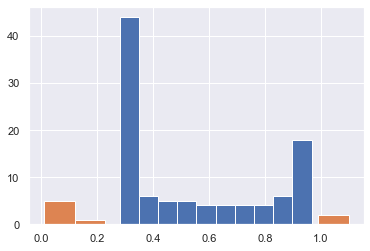

In [44]:
from scipy import stats

src = np.array([1, 2, 3, 3, 10, 15, 100, 110])/100
kde1 = stats.gaussian_kde(src)
x1 = np.linspace(0, 1, 100)
y1 = kde1.pdf(x1)

plt.hist(y1)
plt.hist(src)
diptest.dipstat(y1), diptest.dipstat(src)

In [1275]:
bstr.models[0].nodes[16].leaf_model.lists['time']

[503.0,
 1862.0,
 628.0,
 449.0,
 1089.0,
 557.0,
 1763.0,
 557.0,
 1763.0,
 175.0,
 1965.0,
 1756.0,
 446.0,
 446.0,
 1352.0,
 1884.0,
 1965.0,
 679.0,
 1820.0,
 177.0,
 446.0,
 488.0,
 1587.0,
 1352.0,
 463.0,
 1862.0,
 721.0,
 650.0,
 1177.0,
 1469.0,
 792.0,
 338.0,
 177.0,
 1163.0,
 2372.0,
 792.0,
 2030.0,
 1763.0]

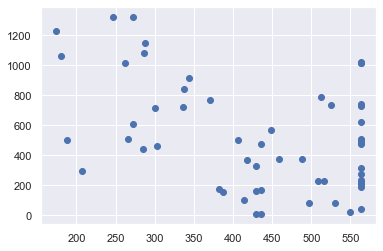

In [700]:
cnt_dist = []
dip_stat = []

for k, n in bstr.models[0].nodes.items():
    if not(n.is_leaf):
        continue
#     print(k)
    sf = n.leaf_model.predict_survival_at_times(X=None, bins=bins_HO)
# #     plt.step(bins_HO, sf, label=f"{n.leaf_model.lists['time']}: {stats.iqr(n.leaf_model.lists['time'])}")
#     plt.step(bins_HO, sf, label=f"{n.leaf_model.lists['time']}: {np.sum((sf - 0.5)**2)}")
# #     plt.step(bins_HO, sf, label=f"{n.leaf_model.lists['time']}: {diptest.dipstat(n.leaf_model.lists['time'])}")
#     plt.legend()
#     plt.show()
    
    cnt_dist.append(np.sum((sf - 0.5)**2))
    dip_stat.append(stats.iqr(n.leaf_model.lists['time']))

plt.scatter(cnt_dist, dip_stat)

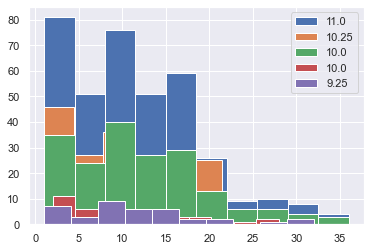

In [618]:
plt.hist(y["time"], label=f"{stats.iqr(y['time'])}")
plt.hist(y["time"][::2], label=f"{stats.iqr(y['time'][::2])}")
plt.hist(y["time"][1::2], label=f"{stats.iqr(y['time'][1::2])}")
plt.hist(y["time"][::10], label=f"{stats.iqr(y['time'][::10])}")
plt.hist(y["time"][1::10], label=f"{stats.iqr(y['time'][1::10])}")
plt.legend()

Text(0.5, 1.0, '0.08333333333333333')

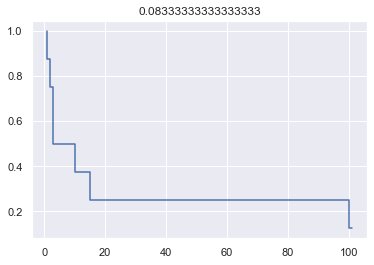

In [599]:
src = np.array([1, 2, 3, 3, 10, 15, 100])
a = random.choice(src)
n = np.cumsum(np.bincount(a)[::-1])[::-1]
o = np.bincount(a)
st = np.cumprod(1 - o/(n + 1))
plt.step(np.arange(a.min(), a.max()+2), st)
plt.title(diptest.dipstat(a))

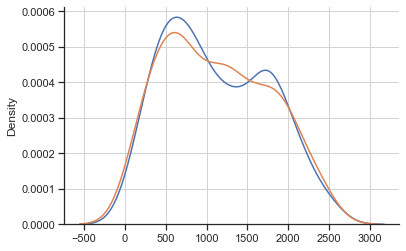

In [273]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

# X, y, features, categ, sch_nan = ds.load_actg_dataset()
X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
# X, y, features, categ, sch_nan = ds.load_wuhan_dataset()
# y["time"] += 1

# # y["cens"] = ~y["cens"]
# features = list(set(features) - {"max_2019_nCoV_nucleic_acid_detection", 
#                                  "mean_2019_nCoV_nucleic_acid_detection", 
#                                  "min_2019_nCoV_nucleic_acid_detection"})
# X = X[features]

qs = np.quantile(y["time"], np.linspace(0.2, 0.8, 4))
time_discr = np.searchsorted(qs, y["time"])

discr = np.char.add(time_discr.astype(str), y["cens"].astype(str))
X_TR, X_HO = train_test_split(X, stratify=discr, test_size=0.33, random_state=42)

# X_T1, X_T2 = train_test_split(X, stratify=disr, test_size=0.33, random_state=42)
# X_T1_TR, X_T1_HO = train_test_split(X_T1, stratify=y["cens"][X_T1.index], test_size=0.33, random_state=42)
# X_T2_TR, X_T2_HO = train_test_split(X_T2, stratify=y["cens"][X_T2.index], test_size=0.33, random_state=42)
# X_TR = pd.concat([X_T1_TR, X_T2_TR])
# X_HO = pd.concat([X_T1_HO, X_T2_HO])

# X_TR, X_HO = train_test_split(X, stratify=y[cnt.CENS_NAME],
#                               test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

df = X_HO.copy()
df["time"] = y_HO["time"]
df["cens"] = y_HO["cens"]

df_tr = X_tr.copy()
df_tr["time"] = y_tr["time"]
df_tr["cens"] = y_tr["cens"]

sns.kdeplot(y_tr["time"], label="train")
sns.kdeplot(y_HO["time"], label="HO")
plt.show()

In [926]:
from lifelines import CoxPHFitter

# ff = list(set(df.columns) - set(["mean_basophil_count___", "min_basophil_count___", "max_basophil_count___", 
#                                  "mean_basophil___", "min_basophil___", "max_basophil___",
#                                  "max_HCV_antibody_quantification", "min_HCV_antibody_quantification", "mean_HCV_antibody_quantification",
#                                  "max_HIV_antibody_quantification", "min_HIV_antibody_quantification", "mean_HIV_antibody_quantification"]))
df_ = df.fillna(0).replace(np.nan, 0)
cph = CoxPHFitter(penalizer=0.01).fit(df_, 'time', 'cens')
# axes = cph.check_assumptions(df_, p_value_threshold=0.1)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 227 total observations, 129 right-censored observations>
             duration col = 'time'
                event col = 'cens'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 227
number of events observed = 98
   partial log-likelihood = -455.16
         time fit was run = 2023-11-16 14:16:33 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
htreat     -0.37       0.69       0.23            -0.82             0.07                 0.44                 1.08
age         0.00       1.00       0.02            -0.03             0.03                 0.97                 1.03
menostat    0.14       1.15       0.32            -0.49             0.77                 0.61                 2.16
tumsize     0.01       1.01       0.01            -0.01             0.02                 0.99                 1.02
tumgrad     0.07       1.07       0.18            -0.28             0.42                 0.76                 1.52
posnodal    0.09       1.09       0.02             0.05             0.13                 1.05                 1.13
prm        -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
esm        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

            cmp to     z      p   -log2(p)
covariate                                 
htreat        0.00 -1.63   0.10       3.28
age           0.00  0.07   0.94       0.08
menostat      0.00  0.44   0.66       0.60
tumsize       0.00  0.63   0.53       0.92
tumgrad       0.00  0.40   0.69       0.54
posnodal      0.00  4.75 <0.005      18.92
prm           0.00 -2.80   0.01       7.63
esm           0.00 -0.02   0.98       0.02
---
Concordance = 0.71
Partial AIC = 926.31
log-likelihood ratio test = 44.81 on 8 df
-log2(p) of ll-ratio test = 21.25

In [4]:
from survivors.ensemble import BootstrapCRAID, BoostingCRAID
param_bstr = {'balance': None, 'categ': categ, 
        'criterion': 'peto', 'depth': 7, 'ens_metric_name': 'IBS_REMAIN', 
        'leaf_model': 'base_zero_after', 
        'max_features': 0.3, 'min_samples_leaf': 0.001,
        'n_estimators': 50, 'n_jobs': 5, 'size_sample': 0.5}


bstr = BootstrapCRAID(**param_bstr)
bstr.fit(X_tr, y_tr)
bstr.tolerance_find_best(param_bstr["ens_metric_name"])
pred_time = bstr.predict(X_HO, target="time")
pred_surv = bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_haz = bstr.predict_at_times(X_HO, bins=bins_HO, mode="hazard")

print(count_metric(y_tr, y_HO, pred_time,
                   pred_surv, pred_haz, bins_HO,
                   ['CI', "IBS_REMAIN", "BAL_IBS_REMAIN", "IAUC_WW_TI", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

fitted: 50 models.
[0.2246 0.2161 0.198  0.189  0.1804 0.1729 0.166  0.1656 0.1633 0.1634
 0.1581 0.1578 0.1567 0.1557 0.1554 0.1542 0.1529 0.152  0.1513 0.1522
 0.1505 0.1505 0.1504 0.1491 0.149  0.1492 0.1486 0.1479 0.1481 0.1475
 0.1477 0.1471 0.1473 0.1473 0.1471 0.1467 0.1466 0.1464 0.1464 0.1465
 0.1461 0.1461 0.1464 0.1463 0.1466 0.1464 0.1466 0.1464 0.1469 0.1466]
fitted: 41 models.
[0.62130085 0.14861032 0.36949969 0.72673397 0.68819996 0.49966937
 0.66684298]


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.5-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls


In [ ]:
[0.6208714  0.1551369  0.38887042 0.73104597 0.70667876 0.50590279
 0.68393461]

In [ ]:
[0.6208714  0.14879183 0.36885461 0.72915462 0.68843724 0.49994953
 0.66708512]

In [6]:
y_HO[[0, 2, 3]]

array([( True,  305.), ( True,  586.), ( True, 1977.)],
      dtype=[('cens', '?'), ('time', '<f8')])

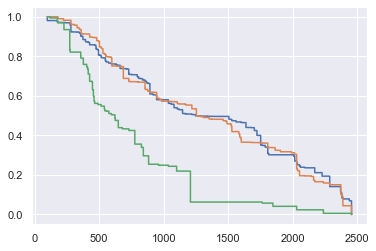

In [5]:
plt.step(bins_HO, pred_surv[0])
plt.step(bins_HO, pred_surv[2])
plt.step(bins_HO, pred_surv[3])

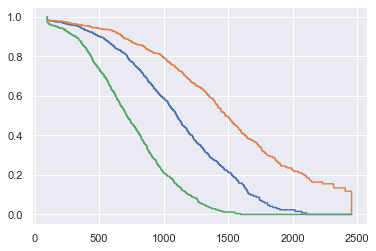

In [58]:
plt.step(bins_HO, pred_surv[0])
plt.step(bins_HO, pred_surv[2])
plt.step(bins_HO, pred_surv[3])

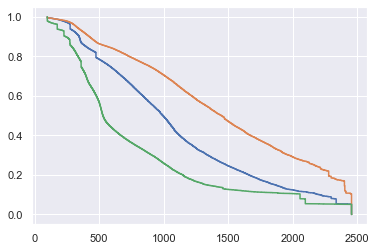

In [105]:
plt.step(bins_HO, pred_surv[0])
plt.step(bins_HO, pred_surv[2])
plt.step(bins_HO, pred_surv[3])

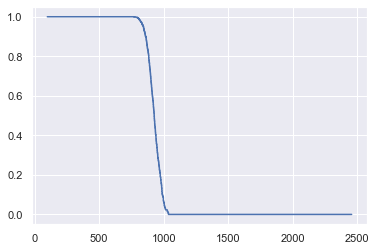

In [95]:
plt.step(bins_HO, pred_surv[0])

In [37]:
param_bstr = {'balance': None, 'categ': categ, 
        'criterion': 'peto', 'depth': 7, 'ens_metric_name': 'IBS_REMAIN', 
        'leaf_model': 'base_zero_after', 
        'max_features': 0.3, 'min_samples_leaf': 0.001, # "l_reg": 0.1,
        'n_estimators': 50, 'n_jobs': 5, 'size_sample': 0.5, "all_weight": False,
        "mode_wei": 'square', "with_arc": False, 'weighted_tree': False}


bstr = BoostingCRAID(**param_bstr)
bstr.fit(X_tr, y_tr)
bstr.tolerance_find_best(param_bstr["ens_metric_name"])
pred_time = bstr.predict(X_HO, target="time")
pred_surv = bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_haz = bstr.predict_at_times(X_HO, bins=bins_HO, mode="hazard")

print(count_metric(y_tr, y_HO, pred_time,
                   pred_surv, pred_haz, bins_HO,
                   ['CI', "IBS_REMAIN", "BAL_IBS_REMAIN", "IAUC_WW_TI", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

fitted: 50 models.
[0.2056 0.21   0.1949 0.1813 0.175  0.1731 0.1675 0.1639 0.1627 0.1572
 0.1548 0.1558 0.1547 0.1535 0.1526 0.152  0.1524 0.1521 0.1508 0.1515
 0.1514 0.1523 0.1514 0.1508 0.1511 0.1505 0.1504 0.1502 0.1506 0.1504
 0.1502 0.15   0.1503 0.1506 0.1502 0.1503 0.15   0.1499 0.1493 0.1489
 0.1484 0.1485 0.1482 0.1483 0.1482 0.1479 0.1477 0.1476 0.1474 0.1468]
fitted: 50 models.
[0.61552276 0.14828745 0.37480403 0.73055011 0.67939022 0.50009788
 0.65907976]


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls


In [ ]:
[0.61595221 0.14868735 0.38111737 0.73434867 0.68063885 0.50129194
 0.66032221]

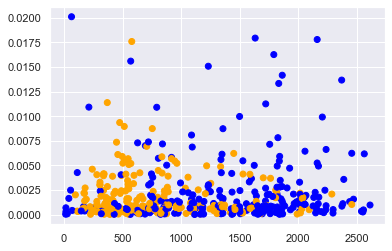

In [38]:
# sns.kdeplot(bstr.weights, log_scale=True)
plt.scatter(y_tr["time"], bstr.weights, c=np.where(y_tr["cens"], "orange", "blue"))

Prior distribution: [259 200]


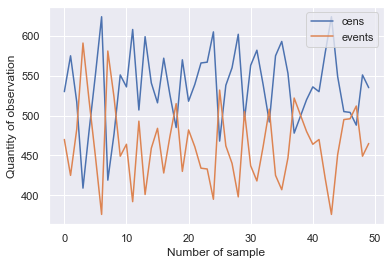

In [39]:
print("Prior distribution:", np.bincount(y_tr["cens"]))
n_cens = []
n_events = []
for i in range(len(bstr.models)):
    distr = np.bincount(bstr.models[i].nodes[0].leaf_model.predict_list_feature(feature_name="cens"))
    n_cens.append(distr[0])
    n_events.append(distr[1])

plt.plot(n_cens, label="cens")
plt.plot(n_events, label="events")
plt.legend()
plt.ylabel("Quantity of observation")
plt.xlabel("Number of sample")
plt.show()

In [ ]:
[0.62712527 0.14171783 0.32173684 0.77401004 0.71125341 0.51964769
 0.68954807]

In [ ]:
[0.62712527 0.14884432 0.30538928 0.77401004 0.70349235 0.49982424
 0.68042057]

In [ ]:
[0.62712527 0.14844291 0.34854054 0.77401004 0.72493537 0.51778327
 0.70146892]

In [ ]:
[0.62712527 0.14188446 0.3472293  0.77401004 0.69530669 0.51462062
 0.67483834]

In [ ]:
[0.63548954 0.13924513 0.34119313 0.77955671 0.69745137 0.5199105
 0.67733932]

In [ ]:
[0.62657807 0.14026895 0.34049653 0.77894417 0.69278102 0.51987954
 0.67319452]

In [ ]:
[0.62407661 0.13910346 0.34133729 0.77522468 0.69598384 0.52368669
 0.6764658 ]

In [ ]:
[0.62798515 0.14223849 0.34295473 0.76877587 0.6948715  0.51542966
 0.67454411]

In [ ]:
[0.63068204 0.13943861 0.34146646 0.77485602 0.69517524 0.5154209
 0.67481244]

In [ ]:
[0.62872777 0.14054648 0.36158996 0.77728187 0.69203627 0.52087535
 0.67264695]

[0.62524917 0.14514113 0.34624358 0.761493   0.68754661 0.50908235
 0.66732996]

In [ ]:
[0.7692255  0.07045393 0.12963503 0.88939764 0.75177913 0.53243214
 0.73848537]

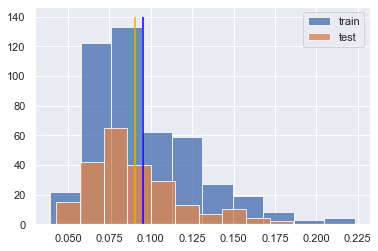

In [321]:
train_interp = np.sum((bstr.predict_at_times(X_tr, bins=bins_HO, mode="surv") - 0.5)**2, axis=1)/pred_surv.shape[1]
test_interp = np.sum((pred_surv - 0.5)**2, axis=1)/pred_surv.shape[1]

plt.hist(train_interp, alpha=0.8, label="train")
plt.hist(test_interp, alpha=0.8, label="test")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines([train_interp.mean()], ymin=0, ymax=ymax, color="blue")
plt.vlines([test_interp.mean()], ymin=0, ymax=ymax, color="orange")

plt.legend()

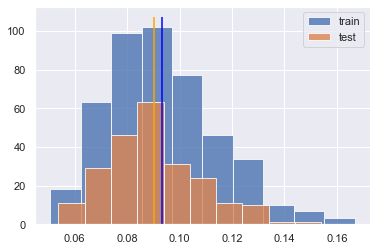

In [1004]:
train_interp = np.sum((bstr.predict_at_times(X_tr, bins=bins_HO, mode="surv") - 0.5)**2, axis=1)/pred_surv.shape[1]
test_interp = np.sum((pred_surv - 0.5)**2, axis=1)/pred_surv.shape[1]

plt.hist(train_interp, alpha=0.8, label="train")
plt.hist(test_interp, alpha=0.8, label="test")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines([train_interp.mean()], ymin=0, ymax=ymax, color="blue")
plt.vlines([test_interp.mean()], ymin=0, ymax=ymax, color="orange")

plt.legend()

In [ ]:
[0.76360521 0.07304893 0.13299682 0.86558123 0.75005898 0.52793664
 0.73659702]

In [ ]:
[0.76387937 0.07364383 0.13161974 0.88202971 0.74879034 0.52826713
 0.73542529]

In [ ]:
[0.62474106 0.14258534 0.35411988 0.76309402 0.6937536  0.51879583
 0.67393416]

In [ ]:
[0.6246238  0.1413695  0.35526522 0.76653645 0.69048486 0.51676118
 0.67080522]

[0.62481923 0.14399089 0.33614265 0.76982147 0.68980032 0.50977725
 0.66940708]

In [ ]:
[0.74571624 0.07691478 0.13562212 0.85031324 0.74644416 0.51884859
 0.73265049]

In [ ]:
[0.75044551 0.07422903 0.13891308 0.86350385 0.74744301 0.5258475
 0.73401298]

In [1034]:
bstr.models[0].visualize(mode="surv")

In [ ]:
[0.75798492 0.07584531 0.15275895 0.84609398 0.74428908 0.52513036
 0.73100674]

In [ ]:
[0.76579849 0.0736009  0.13471011 0.85407327 0.74949491 0.52675405
 0.73599546] # rank timeline

In [ ]:
[0.75867032 0.07254859 0.1335381  0.84727707 0.7503295  0.53066127
 0.73701628] # minstd rank timeline

[0.75633996 0.07495719 0.13651817 0.83066202 0.7504991  0.53075341
 0.73718118] # minstd full timeline

In [ ]:
[0.76703221 0.07399259 0.14214758 0.8703668  0.74778725 0.52820659
#  0.73447933] # diptest rank timeline

[0.75044551 0.07422903 0.13891308 0.86350385 0.74744301 0.5258475
 0.73401298] # diptest full timeline

In [ ]:
[0.61622044 0.14232877 0.36427644 0.76000316 0.68964637 0.5158604
 0.66995968]

In [ ]:
[0.76662097 0.07352715 0.1427046  0.85226585 0.74681081 0.52533867
 0.73338826]

In [ ]:
[0.76703221 0.07399259 0.14214758 0.8703668  0.74778725 0.52820659
 0.73447933]

In [ ]:
[0.76031528 0.07545675 0.13330532 0.84776847 0.74616391 0.52064969
 0.73249638]

In [ ]:
[0.75222755 0.07254517 0.14051689 0.87888129 0.74781346 0.53118041
 0.73468419]
[0.75551748 0.0749408  0.14910095 0.85885689 0.7424502  0.52176386
 0.72907527]

In [ ]:
[0.62259136 0.14198701 0.35885451 0.77255067 0.69410347 0.5194261
 0.6743158 ]
[0.62798515 0.14223849 0.34295473 0.76877587 0.6948715  0.51542966
 0.67454411]

In [ ]:
[0.75551748 0.0749408  0.14910095 0.85885689 0.7424502  0.52176386
 0.72907527]

In [ ]:
[0.62778972 0.14300061 0.33354884 0.77477676 0.69121148 0.50949231
 0.6706261 ]

In [ ]:
[0.6281024  0.14091349 0.34395037 0.77027241 0.69435691 0.52027288
 0.67463645]

In [ ]:
[0.62614813 0.14374146 0.34480665 0.75541951 0.69278564 0.51871816
 0.67306706]

In [ ]:
[0.63091655 0.1422004  0.34096467 0.76252518 0.69420142 0.52163777
 0.67465319]

In [ ]:
[0.63162009 0.14071645 0.34137235 0.76280546 0.69149669 0.51923545
 0.67198272]

C:\Users\vasiliev\AppData\Local\Temp\ipykernel_11612\330354297.py:5: RuntimeWarning: invalid value encountered in divide
  a = np.bincount(pred_0_numb.astype(int), weights=pred_0_time) / np.bincount(pred_0_numb.astype(int))


Text(0, 0.5, 'Mean leaf time')

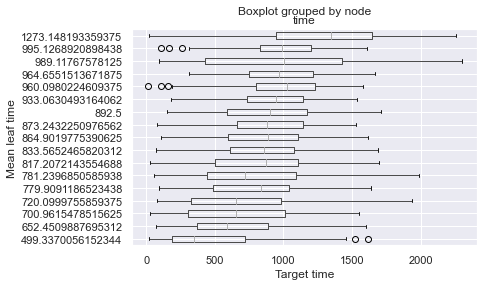

In [481]:
ind = 0
pred_0_numb = tree.predict(X_tr, target="numb") # bstr.models[ind]
pred_0_time = tree.predict(X_tr, target="time")

a = np.bincount(pred_0_numb.astype(int), weights=pred_0_time) / np.bincount(pred_0_numb.astype(int))

dd_ = pd.DataFrame()
dd_["time"] = y_tr["time"]
dd_["node"] = pred_0_time
ax = dd_.boxplot(column='time', by='node', vert=False)
# ax.set_yticks(np.unique(pred_0_numb[~pd.isna(pred_0_numb)]))

# plt.scatter(y_tr["time"], pred_0_time, c=pred_0_numb)
# plt.hlines(y=[a], xmin=y_tr["time"].min(), xmax=y_tr["time"].max(), alpha=0.3)
plt.xlabel("Target time")
plt.ylabel("Mean leaf time")

In [322]:
np.unique(pred_0_numb)

array([ 4.,  8., 10., 12., 14., 15., 20., 28., 30., 32., 33., 34., 35.,
       36., 37., 38., 39., 40., 41., 42., 43., 46., 47., 48., 52., 53.,
       55., 56., 57., 58.])

C:\Users\vasiliev\AppData\Local\Temp\ipykernel_37488\3754810174.py:14: RuntimeWarning: invalid value encountered in divide
  a = np.bincount(pred_0_size.astype(int), weights=ibss) / np.bincount(pred_0_size.astype(int))


corr: -0.11191754874046404
p-value: 0.2337257810820236


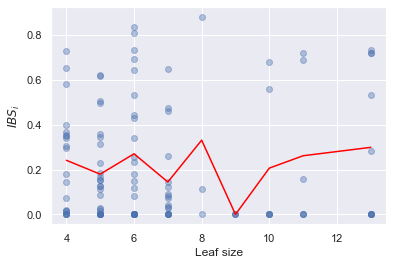

In [78]:
from scipy.stats import spearmanr

X_ = X_HO.reset_index(drop=True)

ind = 0
X_sub = X_.loc[X_.index.difference(bstr.oob_index[ind]), :]
y_sub = y_tr[X_.index.difference(bstr.oob_index[ind])]

pred_0_time = bstr.models[ind].predict(X_sub, target="time")
pred_0_size = bstr.models[ind].predict(X_sub, target="size")
pred_0_surv = bstr.models[ind].predict_at_times(X_sub, bins=bins_HO, mode="surv")

ibss = metr.ibs_WW(y_tr, y_sub, pred_0_surv, bins_HO, axis=0)
a = np.bincount(pred_0_size.astype(int), weights=ibss) / np.bincount(pred_0_size.astype(int))

plt.scatter(pred_0_size, ibss, alpha=0.4)
plt.plot(np.unique(pred_0_size), a[~np.isnan(a)], color="red")
plt.xlabel("Leaf size")
plt.ylabel(r"$IBS_i$")

rho, p = spearmanr(ibss[pred_0_size < 30], pred_0_size[pred_0_size < 30])
print("corr:", rho)
print("p-value:", p)

In [417]:
1/y_tr.shape[0]

0.00398406374501992

In [ ]:
0.0 6.959966659545898 1
0.0 6.959966659545898 1
0.0 18.0803279876709 42
0.0 8.542258262634277 48
0.0 20.724199295043945 78
0.0 12.412800788879395 2
0.0 0.22909821569919586 1
0.0 53.696720123291016 23
0.0 48.013214111328125 75
====== 53.696720123291016 posnodal

In [284]:
75 + 99 + 91 + 156 + 38, 168 + 73 + 180 + 38, 75 + 62 + 44 + 31 + 53 + 71 + 85 + 38

(459, 459, 459)

In [25]:
from survivors.tree import CRAID
p = {'balance': None, 'categ': categ, 'criterion': 'peto', 'cut': False, 'depth': 15, 
     'ens_metric_name': 'IBS_REMAIN', 'l_reg': 0.0, "normalize": False,
     'leaf_model': 'base_zero_after', 
     'max_features': 1.0, 'min_samples_leaf': 0.05, 'n_jobs': 10, 'signif': 0.2, 'woe': True}

tree = CRAID(**p)
tree.fit(X_tr, y_tr)

pred_time = tree.predict(X_HO, target="time")
pred_surv = tree.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_surv[:, -1] = 0
pred_surv[:, 0] = 1
    
pred_haz = tree.predict_at_times(X_HO, bins=bins_HO, mode="hazard")
print(count_metric(y_tr, y_HO, pred_time,
                   pred_surv, pred_haz, bins_HO, 
                   ['CI', "IBS_REMAIN", "BAL_IBS_REMAIN", "IAUC_WW_TI", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))
tree.visualize(mode="hist", target="time")

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.5-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls


[0.58278676 0.17755355 0.39879636 0.68148643 0.67778405 0.48667625
 0.65613512]


In [27]:
a = tree.predict(X_HO, target="ch")


In [ ]:
[0.58516827 0.19396257 0.39511523 0.68403309 0.65880749 0.44601406
 0.63470198]

In [ ]:
[0.58727649 0.17764551 0.46493757 0.69738996 0.70040974 0.50171133
 0.67790093]

In [ ]:
[0.58320325 0.16782598 0.40378209 0.69352467 0.70590047 0.5042006
 0.68166522]

In [ ]:
[0.58320325 0.17307434 0.45402678 0.69352467 0.698926   0.49707461
 0.67467254]

[0.58320325 0.17251076 0.43565925 0.69352467 0.69451638 0.48738757
 0.66962881]

[0.58320325 0.17208665 0.45336544 0.69352467 0.69882331 0.49787186
 0.67467798]

In [ ]:
[0.58320325 0.17390466 0.374524   0.69352467 0.68867011 0.46945557
 0.66233038]

In [ ]:
[0.58320325 0.16976407 0.36283287 0.69352467 0.6900034  0.48112729
 0.66490588]

In [ ]:
[0.58320325 0.16435693 0.36971434 0.69352467 0.6872609  0.50631575
 0.66551943]

In [ ]:
[0.58320325 0.16601312 0.40464643 0.69352467 0.70661327 0.50537545
 0.68243353]

In [ ]:
[0.63101427 0.14772654 0.36060384 0.74417365 0.73507129 0.54082603
 0.71306695]

In [ ]:
[0.59163284 0.16782598 0.40378209 0.69352467 0.70590047 0.5042006
 0.68166522]

[0.58320325 0.16782598 0.40378209 0.69352467 0.70590047 0.5042006
 0.68166522]

In [1306]:
n.leaf_model.survival.events

array([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0])

((posnodal <= 3.5)| nan) & ((prm <= 0.0)| nan)
shapiro: 0.014454051852226257
anderson: 0.9500889497367027 0.824
kstest: 0.22062585828978706


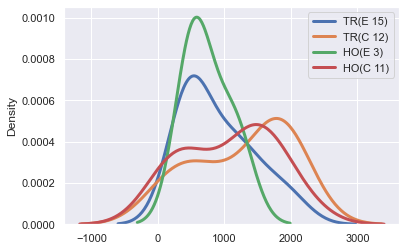

((posnodal <= 3.5)| nan) & (prm > 0.0) & ((age <= 40.5)| nan)
shapiro: 0.5726398229598999
anderson: 0.26516243629479064 0.822
kstest: 0.9228880580798959


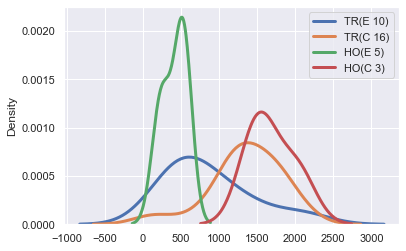

(posnodal > 3.5) & ((esm <= 77.0)| nan) & (age > 61.5)
shapiro: 0.11597414314746857
anderson: 0.6583407548190188 0.815
kstest: 0.4991123516589419


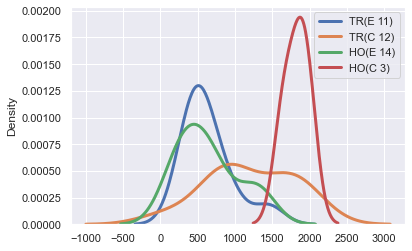

(posnodal > 3.5) & (esm > 77.0) & ((prm <= 114.5)| nan)
shapiro: 0.16947336494922638
anderson: 0.49414805179215193 0.838
kstest: 0.883113167942797


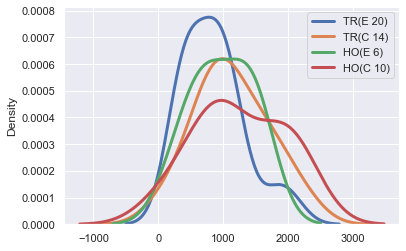

(posnodal > 3.5) & (esm > 77.0) & (prm > 114.5)
shapiro: 0.2686675190925598
anderson: 0.4737811781241561 0.83
kstest: 0.4607939222911488


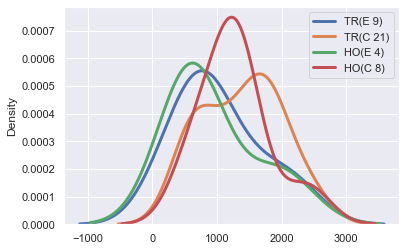

((posnodal <= 3.5)| nan) & (prm > 0.0) & (age > 40.5) & ((prm <= 9.0)| nan)
shapiro: 0.12816306948661804
anderson: 0.7056177173152243 0.826
kstest: 0.3591833324494492


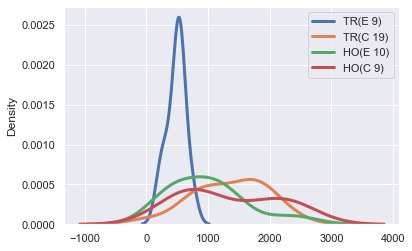

(posnodal > 3.5) & ((esm <= 77.0)| nan) & ((age <= 61.5)| nan) & (prm > 56.5)
shapiro: 0.10541241616010666
anderson: 0.6936298355555834 0.836
kstest: 0.37249805152055765


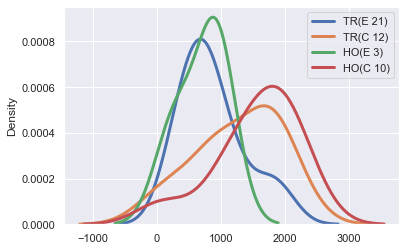

((posnodal <= 3.5)| nan) & (prm > 0.0) & (age > 40.5) & (prm > 9.0) & ((prm <= 20.0)| nan)
shapiro: 0.1889064610004425
anderson: 0.524726252038473 0.822
kstest: 0.4975326413307356


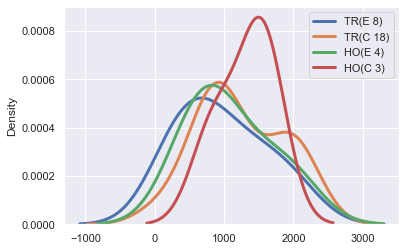

(posnodal > 3.5) & ((esm <= 77.0)| nan) & ((age <= 61.5)| nan) & ((prm <= 56.5)| nan) & ((htreat in [1.0])| nan)
shapiro: 0.008152138441801071
anderson: 1.0009496585231759 0.815
kstest: 0.2521513458617997


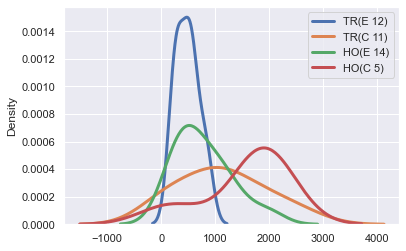

((posnodal <= 3.5)| nan) & (prm > 0.0) & (age > 40.5) & (prm > 9.0) & (prm > 20.0) & ((prm <= 41.74)| nan)
shapiro: 0.34366872906684875
anderson: 0.34213208413413554 0.826
kstest: 0.6904156097887054


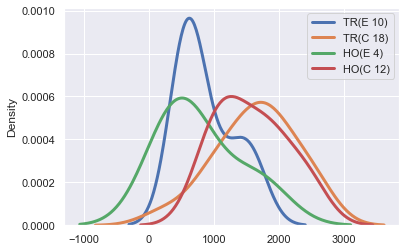

(posnodal > 3.5) & ((esm <= 77.0)| nan) & ((age <= 61.5)| nan) & ((prm <= 56.5)| nan) & (htreat in [0.0]) & ((esm <= 4.5)| nan)
shapiro: 0.006319400388747454
anderson: 1.217007954134374 0.817
kstest: 0.19924133124693785


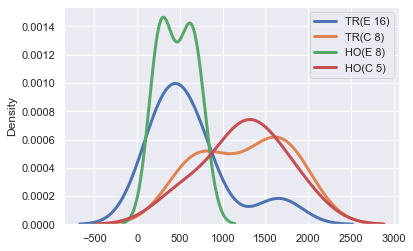

(posnodal > 3.5) & ((esm <= 77.0)| nan) & ((age <= 61.5)| nan) & ((prm <= 56.5)| nan) & (htreat in [0.0]) & (esm > 4.5)
shapiro: 1.6809175576781854e-05
anderson: 2.1194576645667667 0.844
kstest: 0.05852514740201771


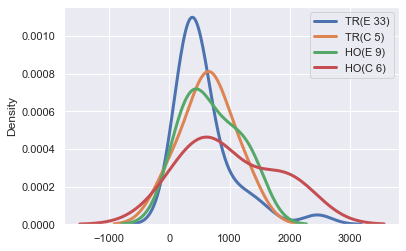

((posnodal <= 3.5)| nan) & (prm > 0.0) & (age > 40.5) & (prm > 9.0) & (prm > 20.0) & (prm > 41.74) & (esm > 262.5)
shapiro: 0.2254839390516281
anderson: 0.3749554282455918 0.822
kstest: 0.8540315500266701


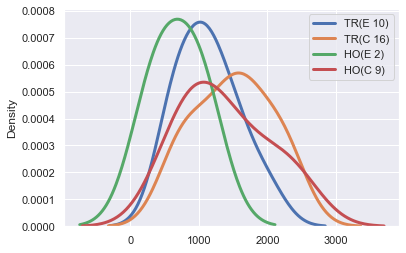

((posnodal <= 3.5)| nan) & (prm > 0.0) & (age > 40.5) & (prm > 9.0) & (prm > 20.0) & (prm > 41.74) & ((esm <= 262.5)| nan) & (esm > 128.5)
shapiro: 0.469256192445755
anderson: 0.3778921162885851 0.817
kstest: 0.5181323150713677


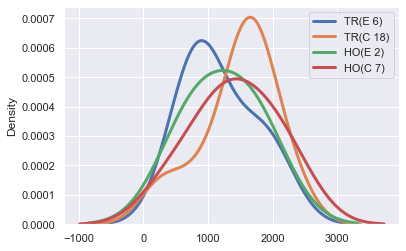

((posnodal <= 3.5)| nan) & (prm > 0.0) & (age > 40.5) & (prm > 9.0) & (prm > 20.0) & (prm > 41.74) & ((esm <= 262.5)| nan) & ((esm <= 128.5)| nan) & ((age <= 51.5)| nan)
shapiro: 0.12115755677223206
anderson: 0.5292913755951076 0.845
kstest: 0.76566371278787


C:\Users\vasiliev\AppData\Local\Temp\ipykernel_11612\1759493537.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(e, linewidth=3, label=f"{label}(E {e.shape[0]})")


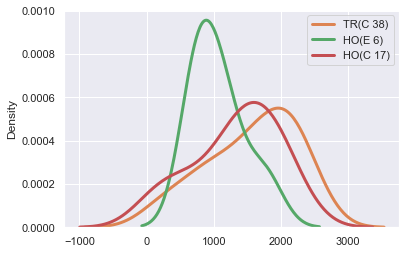

((posnodal <= 3.5)| nan) & (prm > 0.0) & (age > 40.5) & (prm > 9.0) & (prm > 20.0) & (prm > 41.74) & ((esm <= 262.5)| nan) & ((esm <= 128.5)| nan) & (age > 51.5)
shapiro: 0.5007522702217102
anderson: 0.3289248665849449 0.83
kstest: 0.7718502506129634


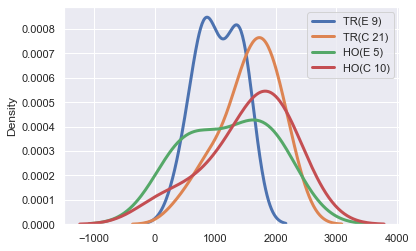

In [1343]:
def plot_kde_for_sample(time, event, label=""):
    if np.unique(event).shape[0] == 2:
        e = time[event == 1]
        sns.kdeplot(e, linewidth=3, label=f"{label}(E {e.shape[0]})")
        c = time[event == 0]
        sns.kdeplot(c, linewidth=3, label=f"{label}(C {c.shape[0]})")
    else:
        sns.kdeplot(time, linewidth=3, label="{label}")
    

ind_tr = tree.predict(X_tr, target="numb")
ind_HO = tree.predict(X_HO, target="numb")

for k, n in tree.nodes.items():
    if not(n.is_leaf):
        continue
    print(n.get_full_rule())
    print("shapiro:", stats.shapiro(n.leaf_model.survival.durs).pvalue)
    ad = stats.anderson(n.leaf_model.survival.durs, 'norm')
    print("anderson:", ad.statistic, ad.critical_values[np.where(ad.significance_level == 2.5)][0])
    np.random.seed(42)
    print("kstest:", stats.kstest(n.leaf_model.survival.durs, 
                       np.random.normal(np.mean(n.leaf_model.survival.durs), 
                                        np.std(n.leaf_model.survival.durs), 1000), method="exact").pvalue)
    
    plot_kde_for_sample(n.leaf_model.survival.durs, n.leaf_model.survival.events, label="TR")
#     plot_kde_for_sample(y_tr[np.where(ind_tr == k)]['time'], y_tr[np.where(ind_tr == k)]['cens'], label="TR")
    plot_kde_for_sample(y_HO[np.where(ind_HO == k)]['time'], y_HO[np.where(ind_HO == k)]['cens'], label="HO")
    
    plt.legend()
    plt.show()

In [ ]:
[0.62456517 0.1486991  0.36430006 0.74352361 0.73495284 0.54133453
 0.71301952]

In [ ]:
[0.6861549  0.09505106 0.19880611 0.81841011 0.75478573 0.50492139
 0.73964244]

In [ ]:
[0.6861549  0.09525018 0.14929725 0.81841011 0.75572935 0.5050069
 0.74053405]

[0.6861549  0.09550959 0.16541207 0.81841011 0.75631661 0.50687194
 0.74119875]

In [ ]:
[0.62456517 0.1510556  0.37351422 0.74352361 0.7186812  0.49936675
 0.69383698]

In [ ]:
[0.62456517 0.1558736  0.32358844 0.74352361 0.6719045  0.40876971
 0.64209626]

In [1326]:
np.unique(n.leaf_model.survival.events).shape[0]

2

In [ ]:
[0.62456517 0.1565473  0.33083101 0.74352361 0.68042923 0.41758518
 0.65065393]

In [ ]:
[0.58100449 0.17735289 0.35870527 0.67386338 0.6691307  0.41145191
 0.63994052]

In [ ]:
[0.62456517 0.16116804 0.50181178 0.74352361 0.64990157 0.52430999
 0.6356744 ]

In [ ]:
[0.62456517 0.16812849 0.31946044 0.74352361 0.65110853 0.37835131
 0.62021025]

In [ ]:
[0.62456517 0.16610979 0.32147185 0.74352361 0.64228779 0.37615278
 0.61213968]

In [ ]:
[0.61999218 0.16793145 0.34140574 0.71693585 0.67356312 0.43396715
 0.64642139]

In [ ]:
[0.60162204 0.16847936 0.32925161 0.72187178 0.64421127 0.37510902
 0.61372703]

In [ ]:
[0.61252687 0.17563    0.34259632 0.70510453 0.68627588 0.48949298
 0.66398407]

In [ ]:
[0.60541333 0.18513587 0.34071538 0.71180638 0.62693293 0.33500373
 0.59386283]

In [ ]:
[0.6040258  0.20169796 0.35450373 0.7003046  0.60849561 0.28825217
 0.57221803]

In [70]:
from survivors.ensemble import BootstrapCRAID, IBSCleverBoostingCRAID
param_bstr = {'aggreg_func': 'mean', 'all_weight': True, 'balance': None, 
              'categ': categ, "l_reg": 0.0,
              'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'IBS_REMAIN', 
              'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.01, # 0.01 
              'n_estimators': 50, 'n_jobs': 5, 'size_sample': 0.7, 'weighted_tree': False}

bstr = IBSCleverBoostingCRAID1(**param_bstr)
bstr.fit(X_tr, y_tr)
bstr.tolerance_find_best(param_bstr["ens_metric_name"])
pred_time = bstr.predict(X_HO, target="time")
pred_surv = bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_haz = bstr.predict_at_times(X_HO, bins=bins_HO, mode="hazard")

print(count_metric(y_tr, y_HO, pred_time,
                   pred_surv, pred_haz, bins_HO, 
                   ['CI', "IBS_REMAIN", "BAL_IBS_REMAIN", "IAUC_WW_TI", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

UNIQUE (0):231, DIST: [189 132]
UNIQUE (1):237, DIST: [181 140]
UNIQUE (2):230, DIST: [181 140]
UNIQUE (3):228, DIST: [169 152]
UNIQUE (4):229, DIST: [177 144]
UNIQUE (5):237, DIST: [179 142]
UNIQUE (6):231, DIST: [190 131]
UNIQUE (7):232, DIST: [174 147]
UNIQUE (8):239, DIST: [188 133]
UNIQUE (9):231, DIST: [183 138]
UNIQUE (10):224, DIST: [185 136]
UNIQUE (11):220, DIST: [165 156]
UNIQUE (12):233, DIST: [180 141]
UNIQUE (13):236, DIST: [187 134]
UNIQUE (14):233, DIST: [169 152]
UNIQUE (15):228, DIST: [184 137]
UNIQUE (16):236, DIST: [181 140]
UNIQUE (17):236, DIST: [185 136]
UNIQUE (18):223, DIST: [188 133]
UNIQUE (19):230, DIST: [194 127]
UNIQUE (20):239, DIST: [186 135]
UNIQUE (21):231, DIST: [169 152]
UNIQUE (22):232, DIST: [177 144]
UNIQUE (23):232, DIST: [177 144]
UNIQUE (24):243, DIST: [179 142]
UNIQUE (25):231, DIST: [183 138]
UNIQUE (26):234, DIST: [192 129]
UNIQUE (27):235, DIST: [171 150]
UNIQUE (28):242, DIST: [182 139]
UNIQUE (29):235, DIST: [168 153]
UNIQUE (30):224, DIS

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls


In [ ]:
[0.62282587 0.1479577  0.35151142 0.75404302 0.68987441 0.50758603
 0.66922455]

In [ ]:
[0.63142466 0.13897244 0.33880481 0.77849349 0.69676951 0.51933245
 0.67666921]

In [ ]:
[0.63095564 0.13955309 0.33858166 0.77400584 0.69643067 0.51826744
 0.67624812]

In [ ]:
[0.63548954 0.13924513 0.34119313 0.77955671 0.69745137 0.5199105
 0.67733932]

In [ ]:
[0.57244479 0.23520613 0.57456988 0.65708472 0.7093925  0.52892556
 0.68894898]

In [ ]:
[0.61993355 0.14634433 0.35088034 0.75931829 0.69236935 0.51298624
 0.67204861]

In [ ]:
[0.7692255  0.07245466 0.13178534 0.87165268 0.74902336 0.52570024
 0.73548862]

train
test


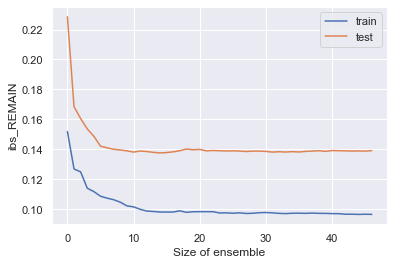

train
test


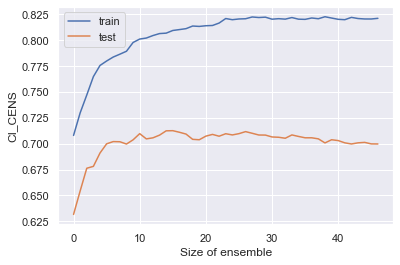

train
test


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\Program

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls


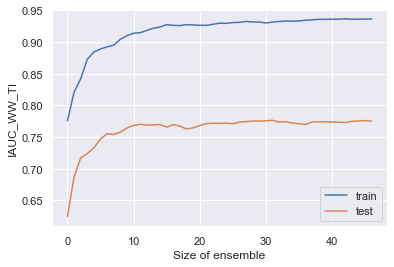

train
test


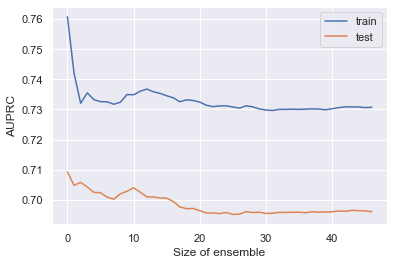

In [1175]:
axx = 1
for mtr in ["ibs_REMAIN", "CI_CENS", "IAUC_WW_TI", "AUPRC"]:
    bstr.plot_curve(X_tr, y_tr, bins_HO, "train", mtr, axes=axx)
    bstr.plot_curve(X_HO, y_HO, bins_HO, "test", mtr, axes=axx)
    plt.legend()
    plt.show()

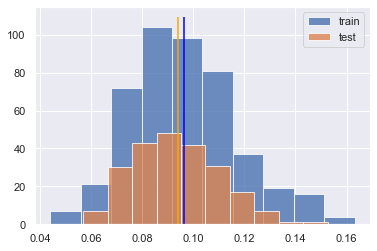

In [1176]:
train_interp = np.sum((bstr.predict_at_times(X_tr, bins=bins_HO, mode="surv") - 0.5)**2, axis=1)/pred_surv.shape[1]
test_interp = np.sum((pred_surv - 0.5)**2, axis=1)/pred_surv.shape[1]

plt.hist(train_interp, alpha=0.8, label="train")
plt.hist(test_interp, alpha=0.8, label="test")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines([train_interp.mean()], ymin=0, ymax=ymax, color="blue")
plt.vlines([test_interp.mean()], ymin=0, ymax=ymax, color="orange")

plt.legend()

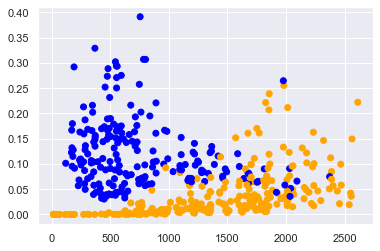

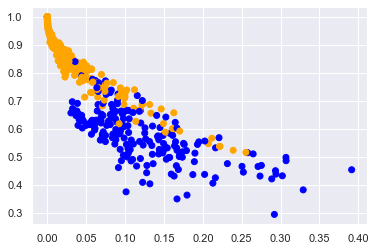

0.7307427905816783
0.073691731945372
0.7385611056932435
0.05703350556292255


In [1177]:
pred_surv_bstr = bstr.predict_at_times(X_tr, bins=bins_HO, mode="surv")
plt.scatter(y_tr["time"], metr.ibs_WW(y_tr, y_tr, pred_surv_bstr, bins_HO, axis=0), 
            c=np.where(y_tr["cens"], "blue", "orange"))
plt.show()
plt.scatter(metr.ibs_WW(y_tr, y_tr, pred_surv_bstr, bins_HO, axis=0), 
            metr.auprc(y_tr, y_tr, pred_surv_bstr, bins_HO, axis=0), 
            c=np.where(y_tr["cens"], "blue", "orange"))
plt.show()
print(np.mean(metr.auprc(y_tr, y_tr, pred_surv_bstr, bins_HO, axis=0)))
print(np.mean(metr.ibs_WW(y_tr, y_tr, pred_surv_bstr, bins_HO, axis=0)))

print(np.median(metr.auprc(y_tr, y_tr, pred_surv_bstr, bins_HO, axis=0)))
print(np.median(metr.ibs_WW(y_tr, y_tr, pred_surv_bstr, bins_HO, axis=0)))

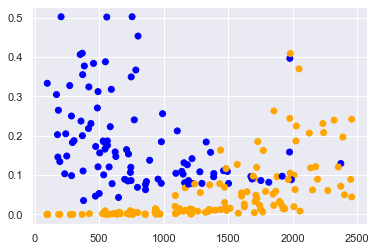

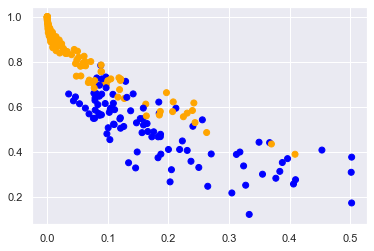

0.6884372433613276
0.10982736413526975
0.7047654480214993
0.08170023234551767


In [120]:
pred_surv_bstr = bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv")
plt.scatter(y_HO["time"], metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0), 
            c=np.where(y_HO["cens"], "blue", "orange"))
plt.show()
plt.scatter(metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0), 
            metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0), 
            c=np.where(y_HO["cens"], "blue", "orange"))
plt.show()
print(np.mean(metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))
print(np.mean(metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))

print(np.median(metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))
print(np.median(metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))

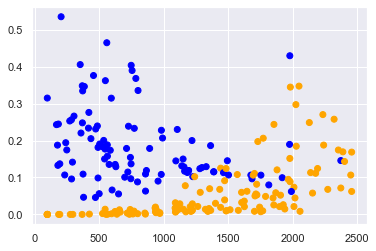

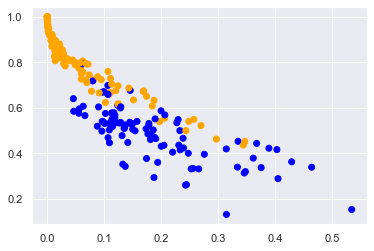

0.6725841602838392
0.11244528231341457
0.6679440180622667
0.0965643666393819


In [7]:
pred_surv_bstr = bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv")
plt.scatter(y_HO["time"], metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0), 
            c=np.where(y_HO["cens"], "blue", "orange"))
plt.show()
plt.scatter(metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0), 
            metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0), 
            c=np.where(y_HO["cens"], "blue", "orange"))
plt.show()
print(np.mean(metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))
print(np.mean(metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))

print(np.median(metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))
print(np.median(metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))

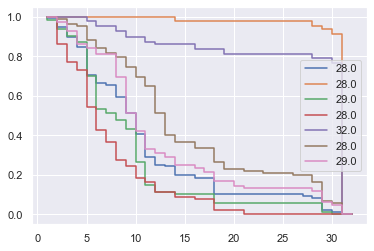

In [549]:
pred_surv_bstr = bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv")

for i in np.where(y_HO["time"] > 25)[0]:
    plt.step(bins_HO, pred_surv_bstr[i], label=y_HO["time"][i])

plt.legend()

In [547]:
X_HO[y_HO["time"] == 29]

min_Prothrombin_time  min_fibrinogen  max____lymphocyte  \
342                  17.4            0.79                6.2   
344                  15.1            4.58                5.2   

     min_HCV_antibody_quantification  max_White_blood_cell_count  \
342                             0.08                       32.99   
344                             0.17                       12.23   

     min_neutrophils_count  max_Prothrombin_time  mean____lymphocyte  \
342                   7.16                  20.0            4.033333   
344                   5.65                  16.5            3.425000   

     max_neutrophils_count  min_PLT_distribution_width  ...  \
342                  31.24                        11.3  ...   
344                  11.13                        16.7  ...   

     min_mean_corpuscular_hemoglobin_  mean_globulin  \
342                              29.2         36.425   
344                              31.3         30.150   

     min_Amino_terminal_brain_natriuretic_peptide_precursor_NT_proBNP_  \
342                                             3251.0                   
344                                              362.0                   

     max_neutrophils___  min_monocytes_count  min_Mean_platelet_volume  \
342                95.0                 0.14                      10.3   
344                93.6                 0.16                      12.0   

     max_Tumor_necrosis_factor_  min_Serum_chloride  \
342                        11.3                97.1   
344                         NaN               113.5   

     max_Hypersensitive_cardiac_troponinI  mean_Uric_acid  
342                                8443.5          315.50  
344                                  14.4          228.25  

[2 rows x 221 columns]

In [548]:
bstr.models[0].visualize(mode="surv")

In [ ]:
[0.76148047 0.07352419 0.13980771 0.82946707 0.74286172 0.5305663
 0.72999533] # rank timeline

In [ ]:
[0.75421522 0.07813184 0.14888686 0.8335198  0.73483829 0.52543357
 0.72214709] # minstd full timeline

[0.76065798 0.07439718 0.14766853 0.85279943 0.7351438  0.52829684
 0.72260762] # minstd rank timeline

In [ ]:
[0.75188485 0.07409013 0.14285489 0.85783089 0.74401594 0.5302137
 0.73105823] # diptest full timeline

In [ ]:
[0.62220051 0.14063964 0.35077657 0.7636975  0.69013242 0.51602659
 0.67040949]

In [ ]:
[0.63251905 0.14106872 0.34654997 0.76467459 0.69642419 0.519807
 0.67641677]

In [177]:
from scipy.signal import find_peaks, peak_widths

def max_width_peaks(x):
    peaks, _ = find_peaks(x)
    print(peaks)
    if len(peaks) > 1:
        distances = np.diff(peaks)
        return max(distances)
    return 0

max_width_peaks(np.histogram(data, bins=30)[0])

[ 7 21]


14

BC: 0.3097707514464615
diptest: 0.11607142857142858


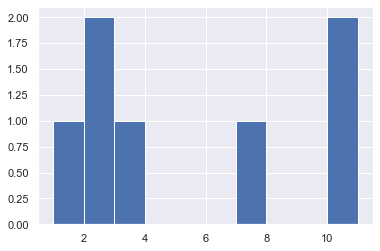

In [294]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks, peak_widths
from scipy.stats import skew, kurtosis

# Сгенерируем случайные данные
# data = np.concatenate([np.random.normal(0, 1, 1000), np.random.normal(4, 1, 1000)])
x = np.array([1, 2, 1, 0, 0, 0, 1, 0, 0, 1, 1])
data = np.repeat(np.arange(1, x.size + 1), x.astype(int))

plt.hist(data)
sk = skew(data)
ku = kurtosis(data)
n = data.size

BC = (sk**2 + 1) / (ku + 3*((n - 1)**2 / ((n - 2) * (n - 3))))
print("BC:", BC)
print("diptest:", diptest.dipstat(data))
# # Построим гистограмму
# plt.hist(data, bins=30)

# print(max_width_peaks(np.histogram(data, bins=30)[0]))

In [153]:
peaks

array([2, 7], dtype=int64)

In [ ]:
[0.75243317 0.07333642 0.13933905 0.8614329  0.74303577 0.52134847
 0.72960017]

In [ ]:
[0.74996573 0.07691214 0.14588498 0.85021201 0.74433642 0.52095168
 0.73079795]

In [ ]:
[0.76422207 0.06826685 0.13153203 0.89333202 0.75438083 0.53143861
 0.74086918]

[0.76319397 0.0720167  0.14611618 0.86796958 0.75141347 0.52898566
 0.73793299]

In [ ]:
[0.75668266 0.07506964 0.13524413 0.80499555 0.74893613 0.52512688
 0.73537194]

[0.75695682 0.07440272 0.14538163 0.85218725 0.74779245 0.52774081
 0.73445599]

In [ ]:
[0.75791638 0.07364925 0.13941104 0.84413016 0.74317018 0.52911454
 0.73019711]

[0.76004112 0.0753898  0.14509276 0.83574934 0.74281228 0.52814724
 0.72980227]

In [ ]:
[0.77930089 0.07105522 0.13704887 0.85401808 0.7516657  0.52669224
 0.73803095]

In [ ]:
[0.76319397 0.0720167  0.14611618 0.86796958 0.75141347 0.52898566
 0.73793299]



In [ ]:
[0.75716244 0.07354856 0.13494969 0.85672017 0.74750994 0.52062937
 0.7337596 ]

In [ ]:
[0.75517478 0.07205391 0.13473618 0.86944936 0.74515232 0.52232319
 0.73164753]
[0.7540096  0.07487264 0.13640897 0.87782645 0.74885486 0.52464159
 0.73526618]

In [ ]:
[0.62259136 0.14198701 0.35885451 0.77255067 0.69410347 0.5194261
 0.6743158 ]

In [ ]:
[0.7540096  0.07479226 0.13625052 0.87836153 0.74900861 0.52494637
 0.73542908]

In [ ]:
[0.74002742 0.07227528 0.13196277 0.86458745 0.74718982 0.52254975
 0.73357527]

In [ ]:
[0.75531186 0.07359772 0.14559497 0.85845047 0.74459797 0.52122024
 0.73105993]

In [ ]:
[0.75716244 0.07354856 0.13494969 0.85672017 0.74750994 0.52062937
 0.7337596 ]

In [ ]:
[0.75517478 0.07205391 0.13473618 0.86944936 0.74515232 0.52232319
 0.73164753]

In [ ]:
[0.75551748 0.0749408  0.14910095 0.85885689 0.7424502  0.52176386
 0.72907527]

In [ ]:
[0.63056478 0.14079638 0.34322143 0.76938389 0.69300919 0.51992004
 0.67340143]

In [ ]:
[0.63146375 0.14081558 0.34032002 0.76382246 0.6913002  0.51914928
 0.67179873]

In [ ]:
[0.63306625 0.13905343 0.37198661 0.78508546 0.68627601 0.52907648
 0.66846826]

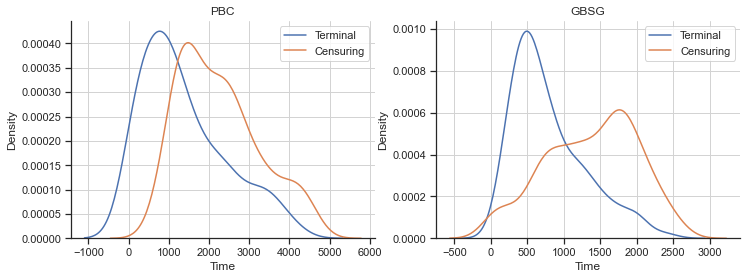

In [515]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

X, y, features, categ, sch_nan = ds.load_pbc_dataset()
sns.kdeplot(y["time"][y["cens"] == True], label="Terminal", ax=axes[0])
sns.kdeplot(y["time"][y["cens"] == False], label="Censuring", ax=axes[0])
axes[0].set_xlabel("Time")
axes[0].set_title("PBC")
axes[0].legend()

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
sns.kdeplot(y["time"][y["cens"] == True], label="Terminal", ax=axes[1])
sns.kdeplot(y["time"][y["cens"] == False], label="Censuring", ax=axes[1])
axes[1].set_xlabel("Time")
axes[1].set_title("GBSG")
axes[1].legend()

df = X.copy()
df["time"] = y["time"]
df["cens"] = y["cens"]

SF IBS:0.19355, AUPRC:0.58646
SF1 IBS:0.17869, AUPRC:0.67577


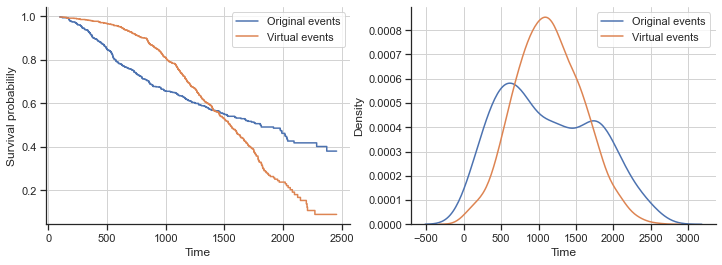

In [643]:
class KaplanMeierZeroAfter(KaplanMeier):
    def fit(self, durations, right_censor, weights=None):
        self.durs = np.array(durations)
        self.events = np.array(right_censor)
        super().fit(self.durs, self.events)

    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
        # place_bin = np.digitize(times, self.timeline)  # -1
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times <= self.timeline[0]] = 1
        return sf
    
class KaplanMeierZeroAfter1(KaplanMeier):
    def fit(self, durations, right_censor, weights=None):
        self.durs = np.random.normal(np.mean(durations), np.std(durations)/ np.sqrt(2), 1000)  # / np.sqrt(2)
        self.events = np.random.choice(right_censor, size=1000, replace=True)
        self.events = self.events[self.durs > 0]
        self.durs = self.durs[self.durs > 0]
        
        super().fit(self.durs, self.events)

    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
        # place_bin = np.digitize(times, self.timeline)  # -1
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times <= self.timeline[0]] = 1
        return sf

y_ = y
X_ = X

km = KaplanMeierZeroAfter()
km.fit(y_["time"], y_["cens"])
sf = km.survival_function_at_times(bins_HO)

km1 = KaplanMeierZeroAfter1()
km1.fit(y_["time"], y_["cens"])
sf1 = km1.survival_function_at_times(bins_HO)

ibs_sf = metr.ibs_remain(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
ibs_sf1 = metr.ibs_remain(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO)

auprc_sf = metr.auprc(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
auprc_sf1 = metr.auprc(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].step(bins_HO, sf, label="Original events")
axes[0].step(bins_HO, sf1, label="Virtual events")
axes[0].legend()

sns.kdeplot(km.durs, ax=axes[1], label="Original events")
sns.kdeplot(km1.durs, ax=axes[1], label="Virtual events")
axes[1].legend()

axes[0].set_xlabel("Time")
axes[0].set_ylabel("Survival probabilily")
axes[1].set_xlabel("Time")
print(f"SF IBS:{ibs_sf:.5f}, AUPRC:{auprc_sf:.5f}")
print(f"SF1 IBS:{ibs_sf1:.5f}, AUPRC:{auprc_sf1:.5f}")

In [577]:
bins_

array([ 113,  114,  115, ..., 2284, 2285, 2286])

In [633]:
X.shape[0]*0.05

34.300000000000004

Text(0, 0.5, '$AUPRC$')

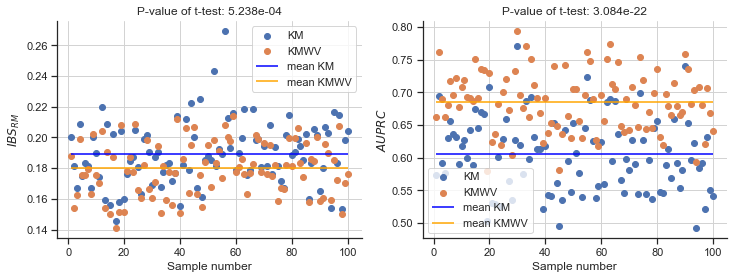

In [645]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
x = np.linspace(1, 100, 100)
ibs_1 = []
ibs_2 = []
auprc_1 = []
auprc_2 = []
np.random.seed(0)

dips = []
for dist in x:
    x_sub = df.sample(n=30, replace=True)
    time = x_sub["time"].to_numpy()
    cens = x_sub["cens"].to_numpy()
    
    dips.append(diptest.dipstat(time))
    bins_ = cnt.get_bins(time=time)
    y_v = cnt.get_y(cens=cens, time=time)
    
    km = KaplanMeierZeroAfter()
    km.fit(y_v["time"], y_v["cens"])
    sf = km.survival_function_at_times(bins_)

    km1 = KaplanMeierZeroAfter1()
    km1.fit(y_v["time"], y_v["cens"])
    sf1 = km1.survival_function_at_times(bins_)

    ibs_1.append(metr.ibs_remain(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_))
    ibs_2.append(metr.ibs_remain(y_v, y_v, np.repeat(sf1[np.newaxis, :], y_v.shape[0], axis=0), bins_))

    auprc_1.append(metr.auprc(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_))
    auprc_2.append(metr.auprc(y_v, y_v, np.repeat(sf1[np.newaxis, :], y_v.shape[0], axis=0), bins_))

axes[0].scatter(x, ibs_1, label="KM")
axes[0].scatter(x, ibs_2, label="KMWV")
axes[0].hlines([np.mean(ibs_1)], xmin=min(x), xmax=max(x), color="blue", label="mean KM")
axes[0].hlines([np.mean(ibs_2)], xmin=min(x), xmax=max(x), color="orange", label="mean KMWV")
axes[0].set_title(f"P-value of t-test: {stats.ttest_ind(ibs_1, ibs_2).pvalue:.3e}")
axes[0].legend()
axes[0].set_xlabel("Sample number")
axes[0].set_ylabel(r"$IBS_{RM}$")

axes[1].scatter(x, auprc_1, label="KM")
axes[1].scatter(x, auprc_2, label="KMWV")
axes[1].hlines([np.mean(auprc_1)], xmin=min(x), xmax=max(x), color="blue", label="mean KM")
axes[1].hlines([np.mean(auprc_2)], xmin=min(x), xmax=max(x), color="orange", label="mean KMWV")
axes[1].set_title(f"P-value of t-test: {stats.ttest_ind(auprc_1, auprc_2).pvalue:.3e}")
axes[1].legend()

axes[1].set_xlabel("Sample number")
axes[1].set_ylabel(r"$AUPRC$")

[[ 644.69183695]
 [1724.72405991]]
[[[328.29883683]]

 [[381.59522277]]]


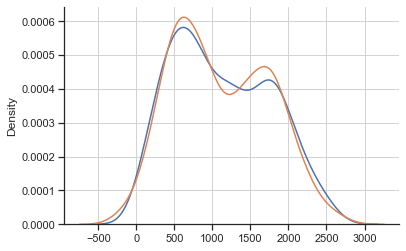

In [352]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=2,random_state=0).fit(y["time"].reshape(-1, 1))

sns.kdeplot(y["time"])
# sns.kdeplot(np.hstack(list(map(lambda x: x.reshape(1, -1), gm.sample(1000))))[0])
sns.kdeplot(gm.sample(1000)[0].reshape(1, -1)[0])

print(gm.means_)
print(np.sqrt(gm.covariances_))

Text(0, 0.5, 'Dip value')

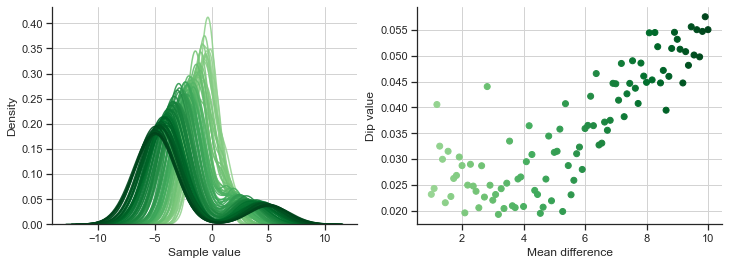

In [475]:
import diptest
from lifelines import KaplanMeierFitter
import matplotlib.cm as cm
from scipy import stats

def get_sf_diff(time):
    cens = np.ones_like(time)
    bins = cnt.get_bins(time=time)
    
    kmf = KaplanMeierFitter()
    kmf.fit(time, cens)
    sf = kmf.survival_function_at_times(bins).to_numpy()
    # plt.step(bins, sf)
    return np.trapz((sf - 0.5)**2, bins)

def get_dip(dist=0):
    a = np.random.normal(loc=-dist*0.5, scale=1.0, size=100)
    b = np.random.normal(loc=dist*0.5, scale=1.0, size=100)

    v = np.hstack([a, b])
    sns.kdeplot(v, label=diptest.dipstat(v))
    #plt.legend()
    return diptest.dipstat(v)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
x = np.linspace(1, 10, 100)
# x = np.linspace(1, 3000, 100)
y1 = []
y2 = []
np.random.seed(0)
for dist in x:
    a = np.random.normal(loc=-dist*0.5, scale=1, size=100)
    b = np.random.normal(loc=+dist*0.5, scale=1, size=20)
#     a = np.random.normal(loc=1200-dist*0.5, scale=328, size=100)
#     b = np.random.normal(loc=1200+dist*0.5, scale=381, size=80)

    v = np.hstack([a, b])
    sns.kdeplot(v, alpha=0.9, color=cm.Greens((dist+5)/(max(x)+5)), ax=axes[0], cbar=True)
    y1.append(diptest.dipstat(v))

axes[0].set_xlabel("Sample value")
axes[1].scatter(x, y1, c=[cm.Greens((dist+5)/(max(x)+5)) for dist in x])
axes[1].set_xlabel("Mean difference")
axes[1].set_ylabel("Dip value")

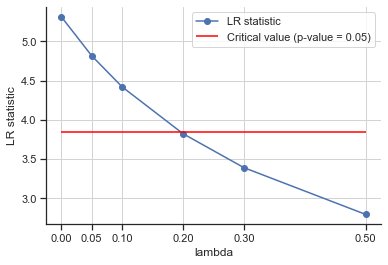

In [199]:
def count_log_rank(dur, cens, ind, reg_l=0.0):
    max_bin = dur.max()
    all_time_hist, all_cens_hist = get_sa_hists(dur, cens, minlength=max_bin + 1)
    l_time_hist, l_cens_hist = get_sa_hists(dur[ind], cens[ind], minlength=max_bin + 1)
    r_time_hist, r_cens_hist = all_time_hist - l_time_hist, all_cens_hist - l_cens_hist

    l_time_hist = l_time_hist + reg_l*all_time_hist*0.5
    r_time_hist = r_time_hist + reg_l*all_time_hist*0.5
    l_cens_hist = l_cens_hist + reg_l*all_cens_hist*0.5
    r_cens_hist = r_cens_hist + reg_l*all_cens_hist*0.5

    N_1_j = np.cumsum(l_time_hist[::-1])[::-1]
    N_2_j = np.cumsum(r_time_hist[::-1])[::-1]

    #print(list(N_1_j))  #, l_cens_hist)
    #print(list(N_2_j))  #, r_cens_hist)

    ind = np.where((l_cens_hist + r_cens_hist != 0) & (N_1_j * N_2_j != 0))[0]

    N_1_j = N_1_j[ind]
    N_2_j = N_2_j[ind]
    O_1_j = l_cens_hist[ind]
    O_2_j = r_cens_hist[ind]

    N_j = N_1_j + N_2_j
    O_j = O_1_j + O_2_j
    E_1_j = N_1_j * O_j / N_j

    res = np.zeros((N_j.shape[0], 3), dtype=np.float32)
    res[:, 1] = O_1_j - E_1_j
    res[:, 2] = E_1_j * (N_j - O_j) * N_2_j / (N_j * (N_j - 1))

    res[:, 0] = 1.0
    var = (res[:, 0] * res[:, 0] * res[:, 2]).sum()
    num = (res[:, 0] * res[:, 1]).sum()

    stat_val = np.power(num, 2) / var
    #print(list(E_1_j))
    return stat_val, stats.chi2.sf(stat_val, df=1)

dur = np.linspace(0, 150, 16, dtype=int)
cens = np.ones_like(dur)
ind1 = [0, 1, 2, 3, 8, 9, 10]  # [0, 1, 2, 3]

s = []
p = []
l_s = [0.0, 0.05, 0.1, 0.2, 0.3, 0.5]
for l in l_s:
    stat_val, p_val = count_log_rank(dur, cens, ind1, reg_l=l)
    s.append(stat_val)
    p.append(p_val)
plt.plot(l_s, s, label="LR statistic", marker="o")
plt.xticks(l_s)
plt.hlines([stats.chi2.isf(0.05, df=1)], xmin=min(l_s), xmax=max(l_s),color= "red", label="Critical value (p-value = 0.05)")
plt.xlabel("lambda")
plt.ylabel("LR statistic")
plt.legend()

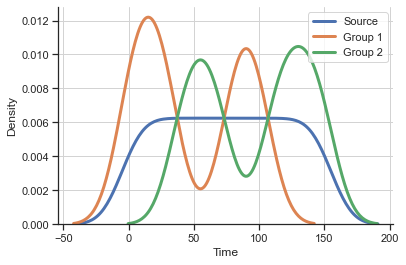

In [257]:
sns.kdeplot(dur, bw_adjust=0.5, linewidth=3, label='Source') #, clip=(0,150))
sns.kdeplot(dur[ind1], bw_adjust=0.5, linewidth=3, label='Group 1') #, clip=(0,150))
sns.kdeplot(dur[list(set(np.arange(dur.shape[0])) - set(ind1))], bw_adjust=0.5, linewidth=3, label='Group 2') #, clip=(0,150))
plt.xlabel("Time")
plt.legend()
# sns.despine(offset=10)

0.0459077959077959


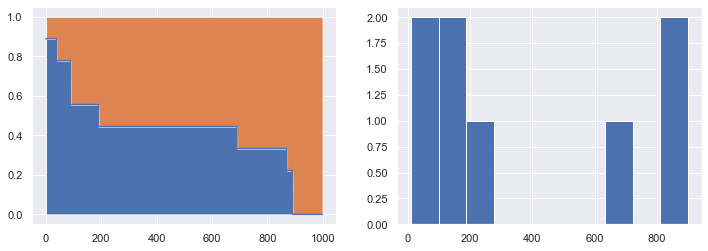

In [1347]:
def count_sf_diff_1(time, cens, bins=None, ax=None):
    c_time = np.cumsum(time[::-1])[::-1]
    sf = np.cumprod((1.0 - cens / (c_time + 1)))
    sf[c_time == 0] = 0.0
    if not(bins is None):
        ax.step(bins, sf[1:-1])
    ax.fill_between(bins, sf[1:-1], 0)
    ax.fill_between(bins, sf[1:-1], 1)
    return np.sum((sf - 0.5)**2) / sf.shape[0] # max(1, bins[-1] - bins[0])

def research_surv(time, cens, bins=None):
    if bins is None:
        bins = np.arange(time.min() - 1, time.max())
    t1 = split_time_to_bins(time, bins)
    bins1 = split_time_to_bins(bins, bins)
    max_bin = bins1.max()
    curr_time_hist, curr_cens_hist = get_sa_hists(t1, cens, minlength=max_bin + 2)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    print(count_sf_diff_1(curr_time_hist, curr_cens_hist, bins, axes[0]))
    axes[1].hist(time)
    plt.show()
    
# research_surv(y["time"], y["cens"], bins_HO)
a = np.array([10, 50, 100, 100, 200, 700, 880, 900])
research_surv(a, np.ones_like(a), np.arange(1, 1000))

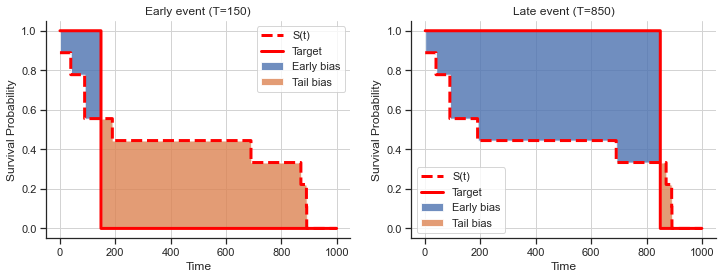

In [647]:
def plot_event_with_sf(bins, sf, e_time, ax):
    if not(bins is None):
        ax.step(bins, sf, color="red", linestyle="--", linewidth=3, label="S(t)")
    ind_early = np.where(bins < e_time)[0]
    ind_late = np.where(bins >= e_time)[0]
    ax.step(bins, np.hstack([np.ones_like(ind_early), np.zeros_like(ind_late)]), linewidth=3, color="red", label="Target")
    ax.fill_between(bins[ind_early], sf[ind_early], 1, alpha=0.8, label="Early bias") 
    ax.fill_between(bins[ind_late], sf[ind_late], 0, alpha=0.8, label="Tail bias")  # , hatch = '/')
    ax.set_ylabel("Survival Probability")
    ax.set_xlabel("Time")
    ax.legend()

def visualize_filled(time, cens, bins=None):
    if bins is None:
        bins = np.arange(time.min() - 1, time.max())
    t1 = split_time_to_bins(time, bins)
    bins1 = split_time_to_bins(bins, bins)
    max_bin = bins1.max()
    time_hist, cens_hist = get_sa_hists(t1, cens, minlength=max_bin + 2)
    
    c_time = np.cumsum(time_hist[::-1])[::-1]
    sf = np.cumprod((1.0 - cens_hist / (c_time + 1)))
    sf[c_time == 0] = 0.0
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_event_with_sf(bins, sf[1:-1], 150, axes[0])
    plot_event_with_sf(bins, sf[1:-1], 850, axes[1])
    axes[0].set_title(f"Early event (T={150})")
    axes[1].set_title(f"Late event (T={850})")
    plt.show()
    
a = np.array([10, 50, 100, 100, 200, 700, 880, 900])
visualize_filled(a, np.ones_like(a), np.arange(1, 1000))

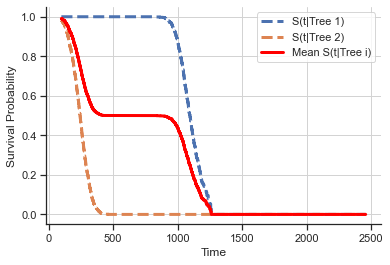

In [231]:
# def plot_event(bins, e_time):
#     ind_early = np.where(bins < e_time)[0]
#     ind_late = np.where(bins >= e_time)[0]
#     plt.step(bins, np.hstack([np.ones_like(ind_early), np.zeros_like(ind_late)]), linewidth=3, color="red", label="Target")
#     plt.ylabel("Survival Probability")
#     plt.xlabel("Time")
#     plt.legend()
    
sf_m1 = bstr.models[7].predict_at_times(X_HO, bins=bins_HO, mode="surv")
sf_m3 = bstr.models[9].predict_at_times(X_HO, bins=bins_HO, mode="surv")

plt.step(bins_HO, sf_m1[0], label="S(t|Tree 1)", linewidth=3, linestyle='--')
plt.step(bins_HO, sf_m3[0], label="S(t|Tree 2)", linewidth=3, linestyle='--')
plt.step(bins_HO, (sf_m1[0] + sf_m3[0])*0.5, linewidth=3, color="red", label=r"Mean S(t|Tree i)")
plt.ylabel("Survival Probability")
plt.xlabel("Time")
plt.legend()

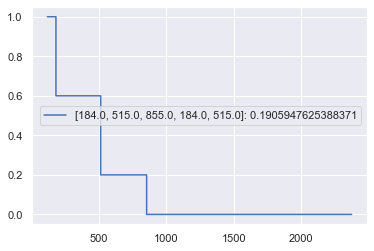

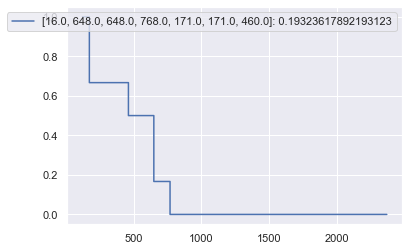

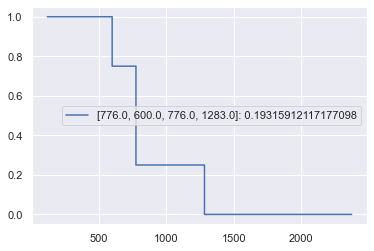

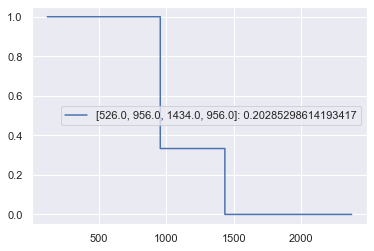

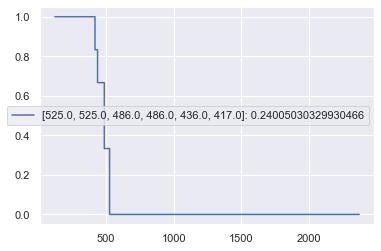

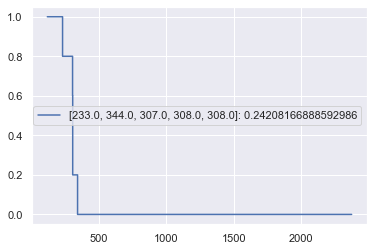

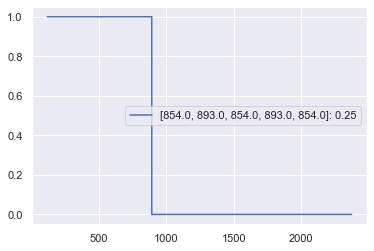

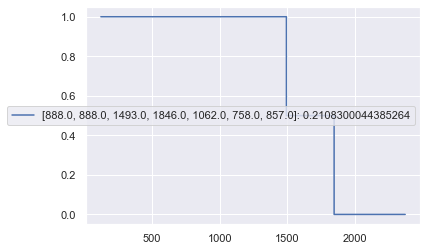

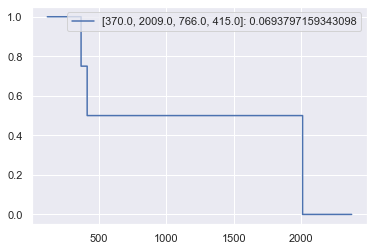

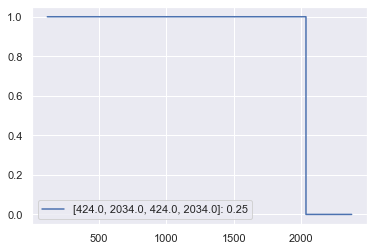

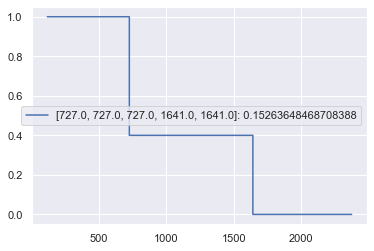

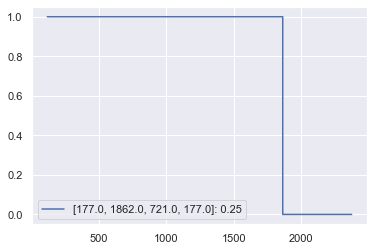

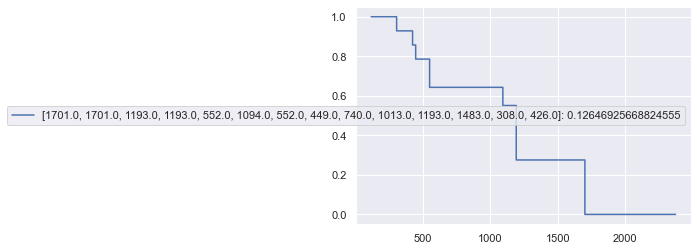

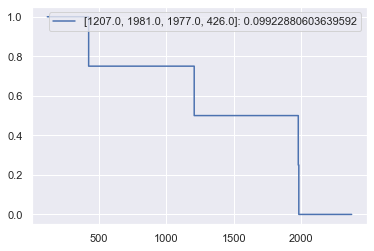

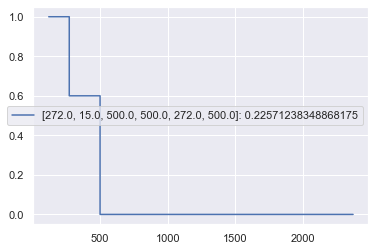

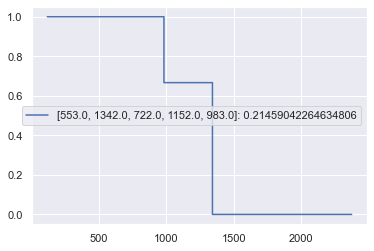

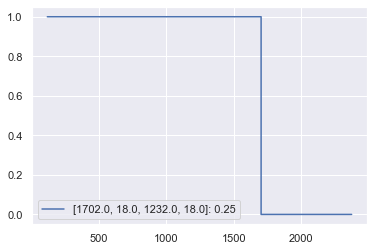

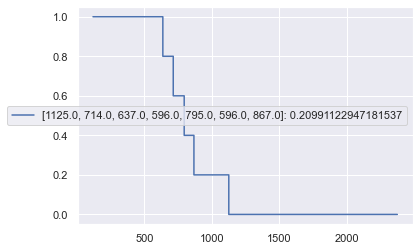

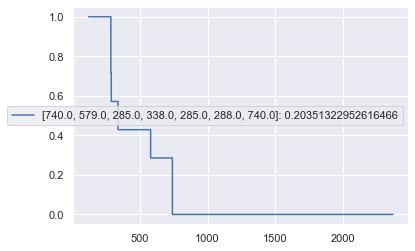

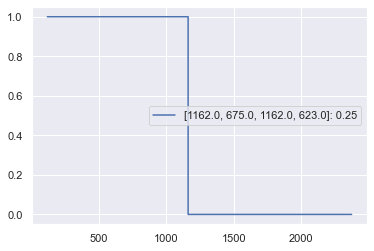

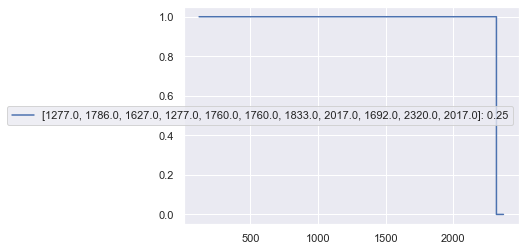

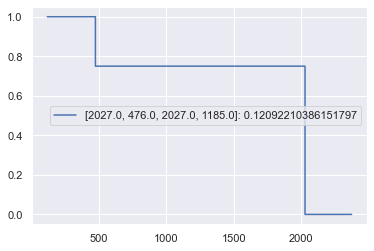

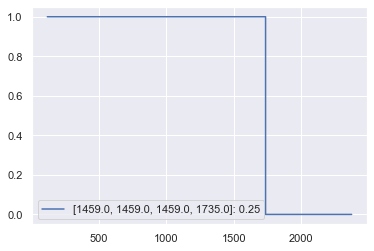

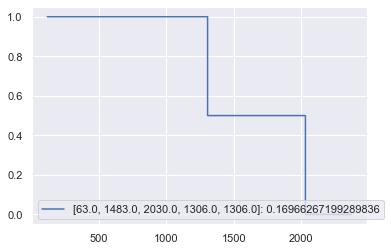

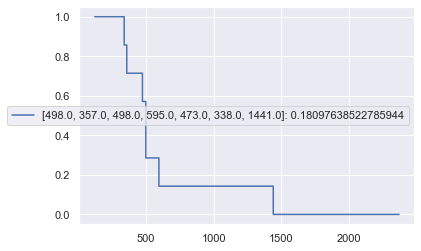

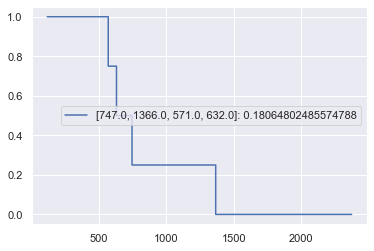

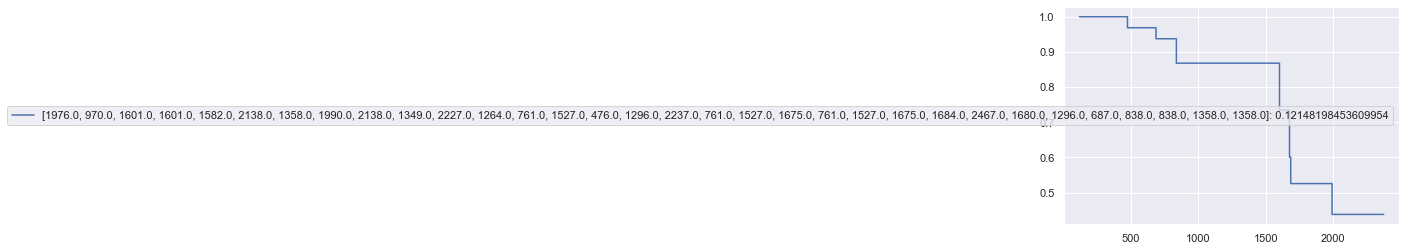

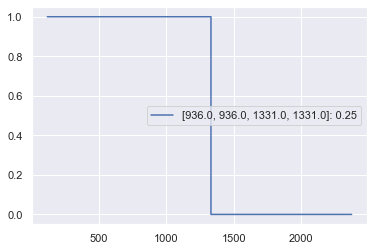

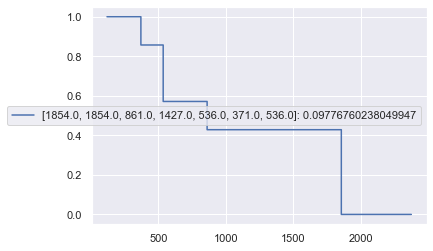

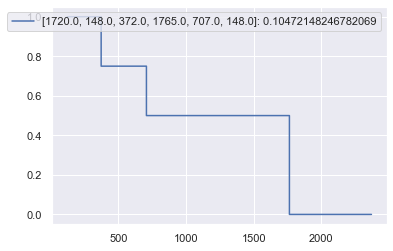

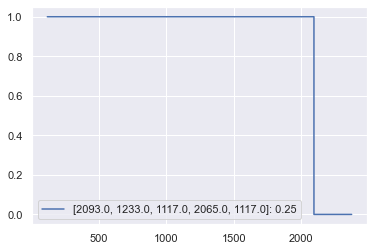

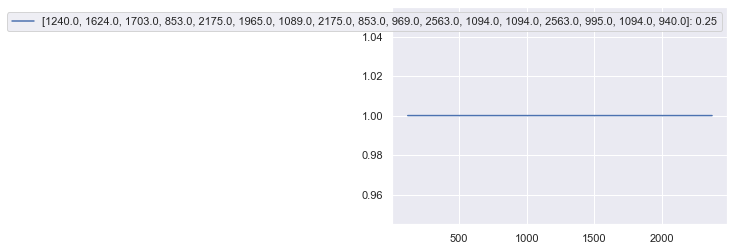

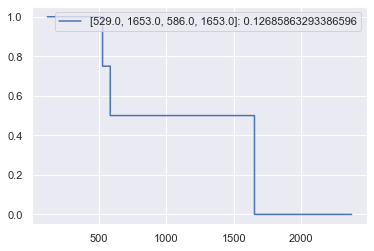

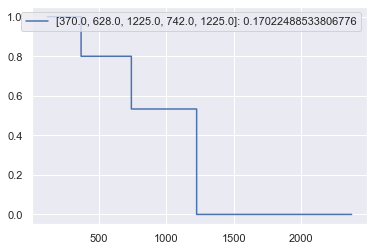

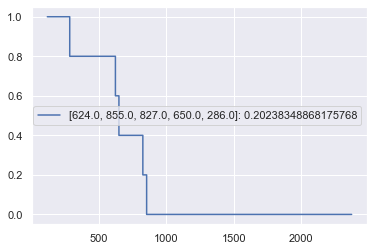

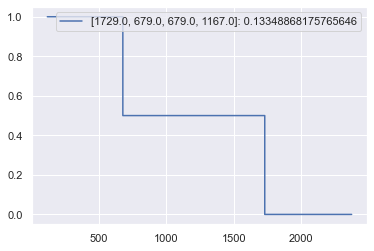

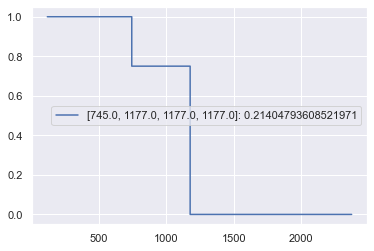

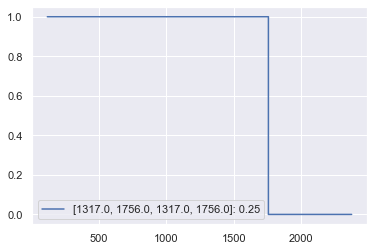

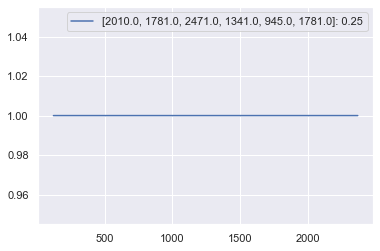

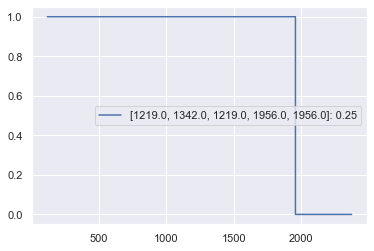

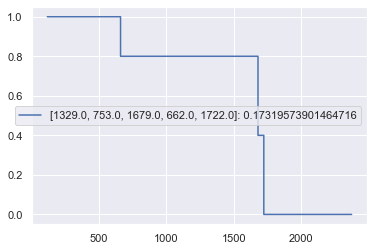

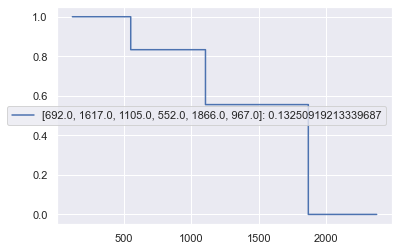

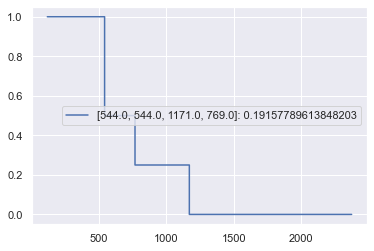

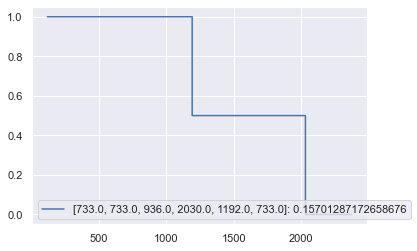

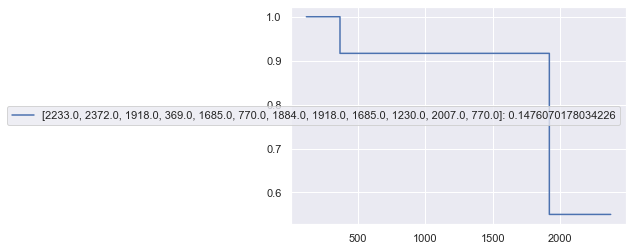

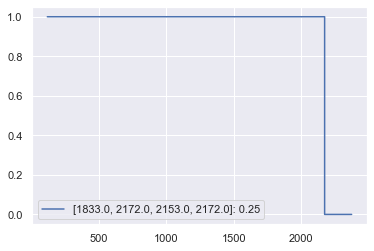

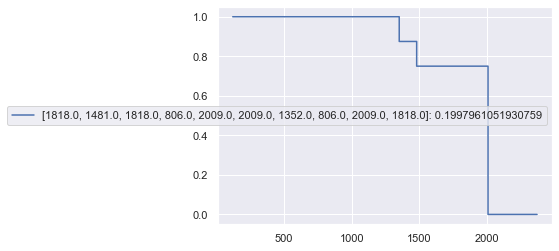

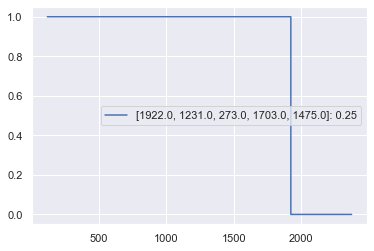

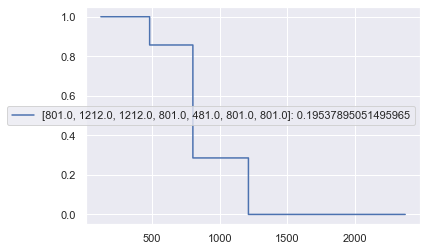

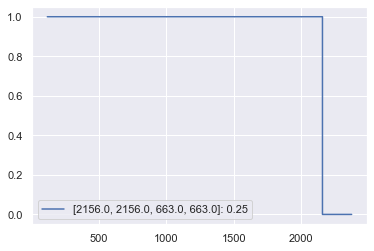

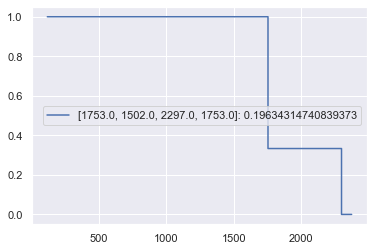

In [1268]:
for k, n in bstr.models[0].nodes.items():
    if not(n.is_leaf):
        continue
    sf = n.leaf_model.predict_survival_at_times(X=None, bins=bins_HO)
    plt.step(bins_HO, sf, label=f"{n.leaf_model.lists['time']}: {np.sum((sf - 0.5)**2) / sf.shape[0]}")
    plt.legend()
    plt.show()

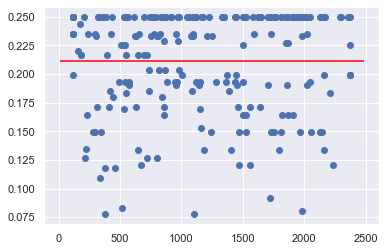

In [1331]:
sfs = bstr.models[0].predict_at_times(X_HO, mode="surv", bins=bins_HO)
nodes = bstr.models[0].predict(X_HO, target="numb")

ibss = metr.ibs_WW(y_tr, y_HO, sfs, bins_HO, axis=0)
plt.scatter(y_HO["time"], np.sum((sfs - 0.5)**2, axis=1) / sfs.shape[1])
xmin, xmax, ymin, ymax = plt.axis()
plt.hlines([np.mean(np.sum((sfs - 0.5)**2, axis=1) / sfs.shape[1])], 
           xmin=xmin, xmax=xmax, color="red")

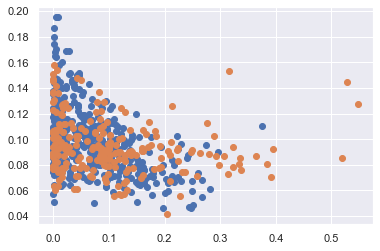

In [1376]:
sfs = bstr.predict_at_times(X_tr, mode="surv", bins=bins_HO)
# nodes = bstr.predict(X_tr, target="numb")

ibss = metr.ibs_WW(y_tr, y_tr, sfs, bins_HO, axis=0)
plt.scatter(ibss, np.sum((sfs - 0.5)**2, axis=1) / sfs.shape[1])

sfs = bstr.predict_at_times(X_HO, mode="surv", bins=bins_HO)
# nodes = bstr.predict(X_HO, target="numb")

ibss = metr.ibs_WW(y_tr, y_HO, sfs, bins_HO, axis=0)
plt.scatter(ibss, np.sum((sfs - 0.5)**2, axis=1) / sfs.shape[1])

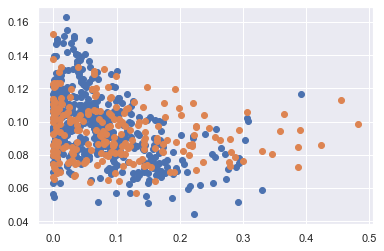

In [1369]:
sfs = bstr.predict_at_times(X_tr, mode="surv", bins=bins_HO)
nodes = bstr.predict(X_tr, target="numb")

ibss = metr.ibs_WW(y_tr, y_tr, sfs, bins_HO, axis=0)
plt.scatter(ibss, np.sum((sfs - 0.5)**2, axis=1) / sfs.shape[1])

sfs = bstr.predict_at_times(X_HO, mode="surv", bins=bins_HO)
nodes = bstr.predict(X_HO, target="numb")

ibss = metr.ibs_WW(y_tr, y_HO, sfs, bins_HO, axis=0)
plt.scatter(ibss, np.sum((sfs - 0.5)**2, axis=1) / sfs.shape[1])

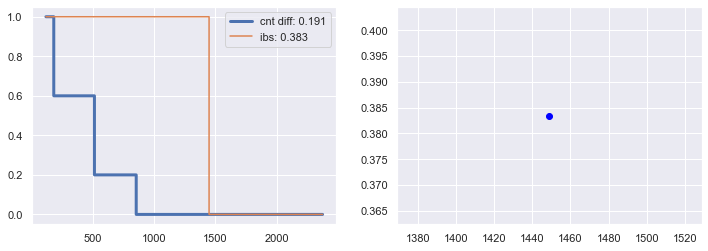

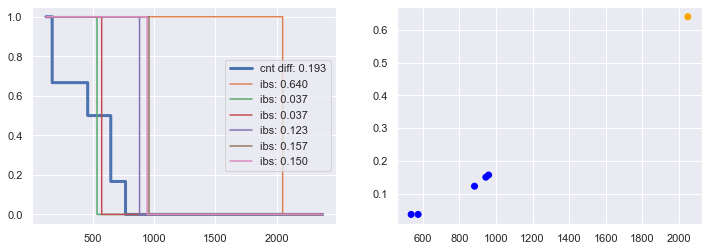

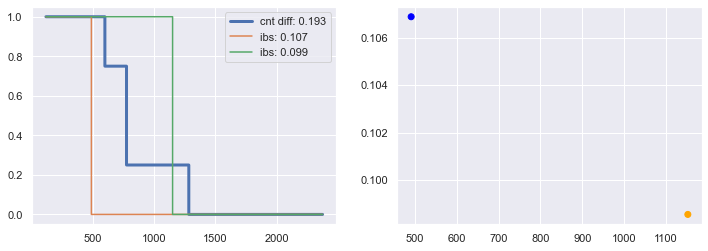

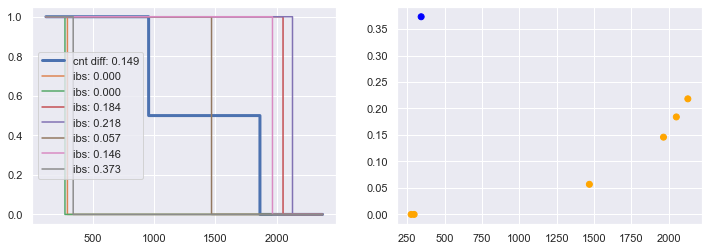

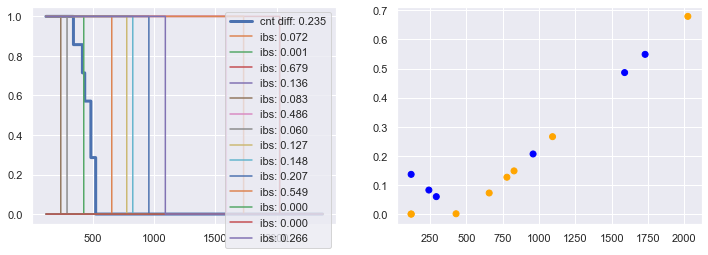

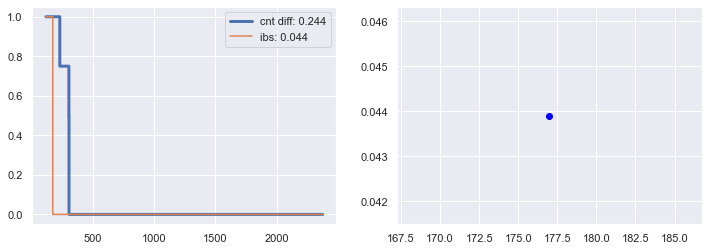

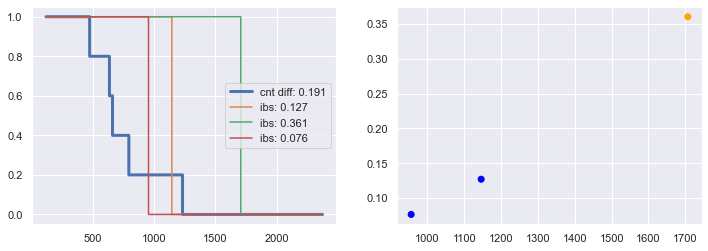

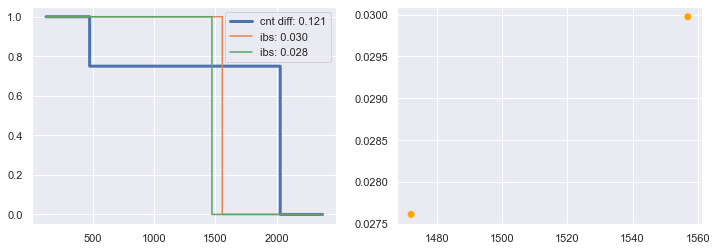

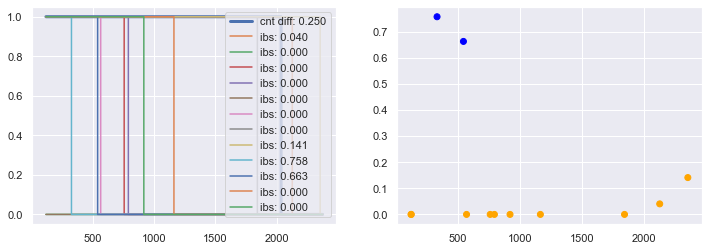

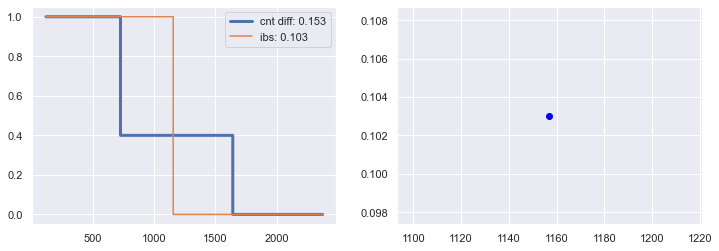

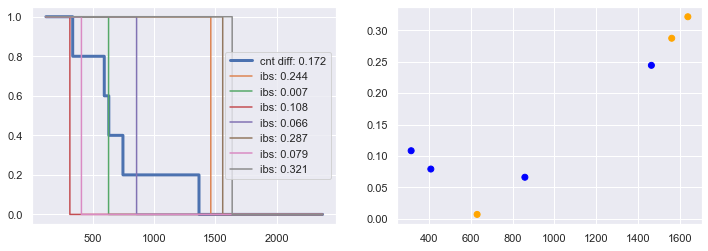

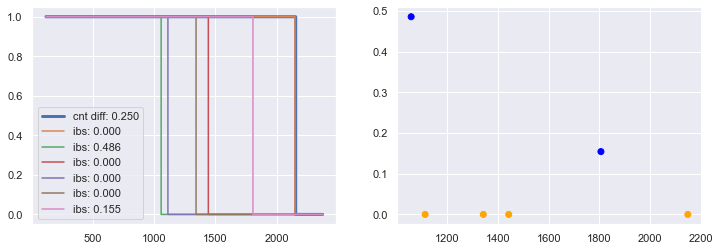

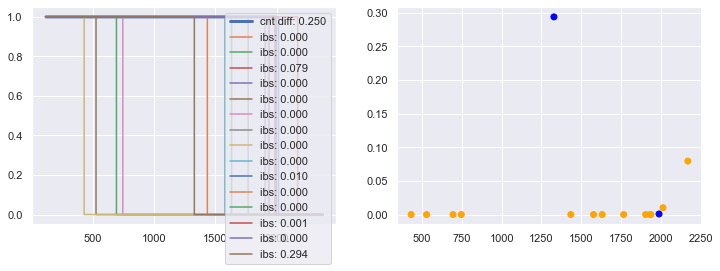

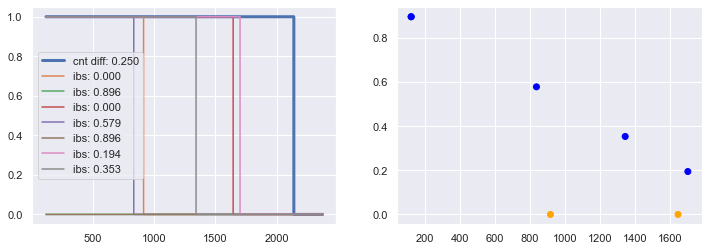

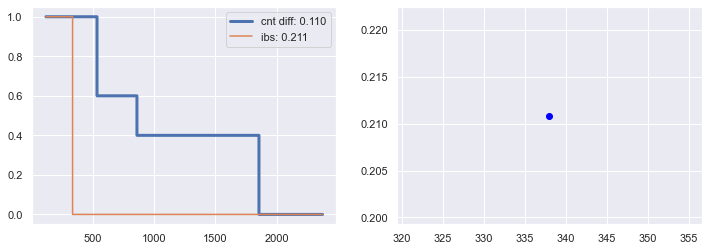

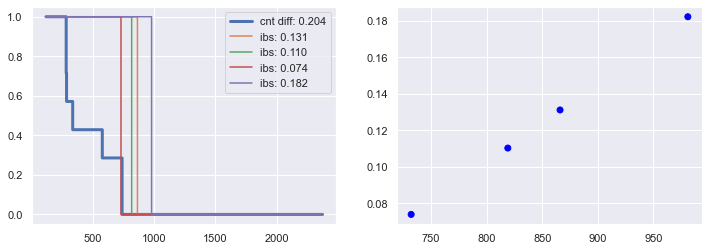

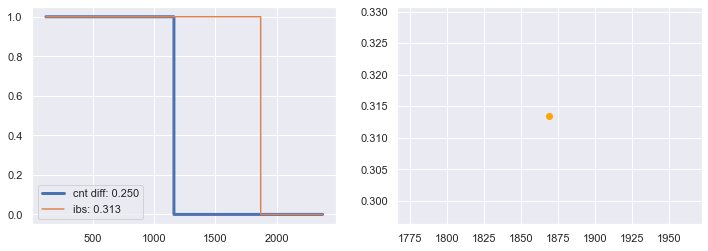

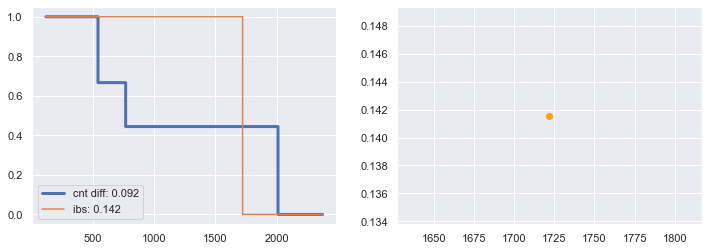

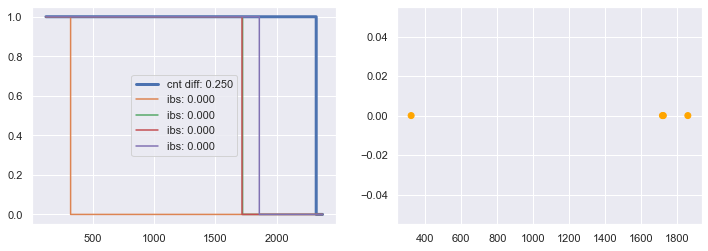

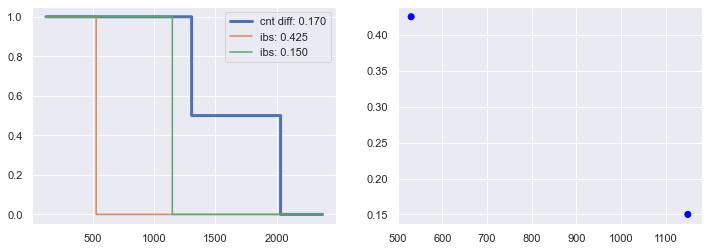

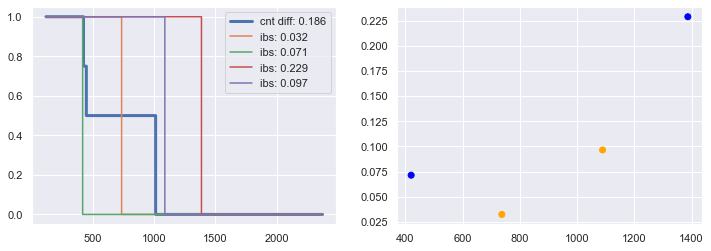

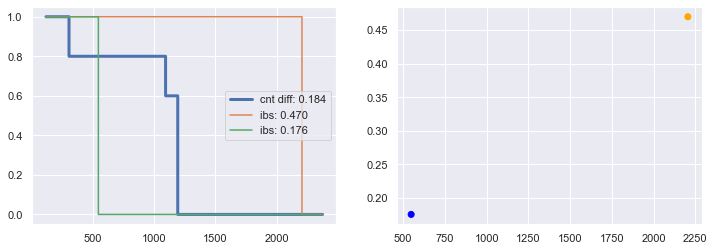

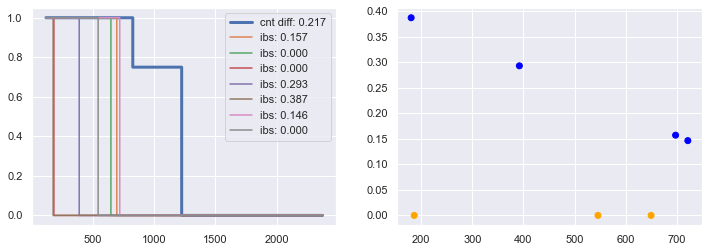

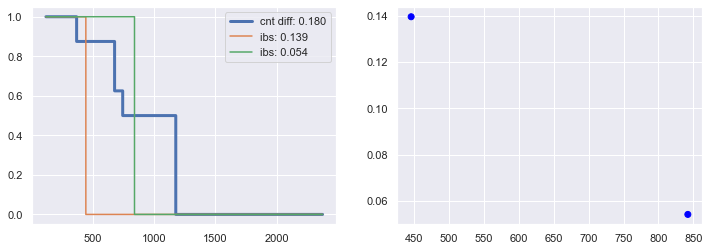

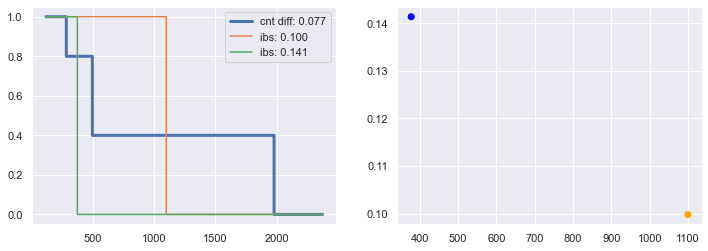

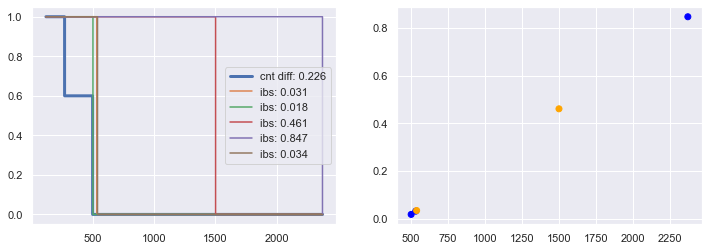

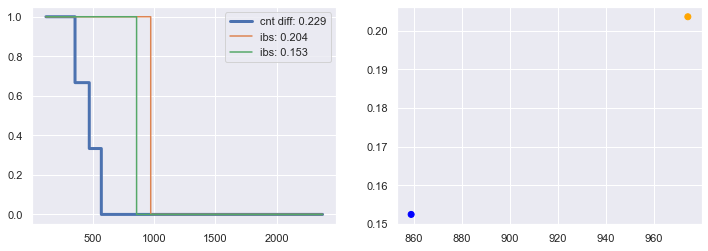

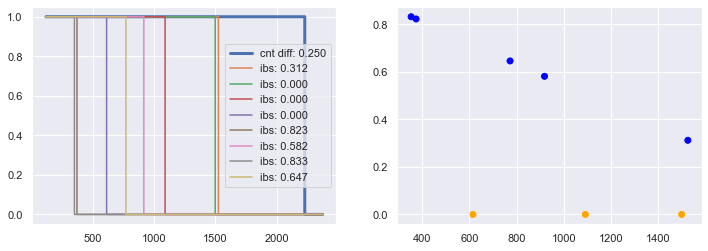

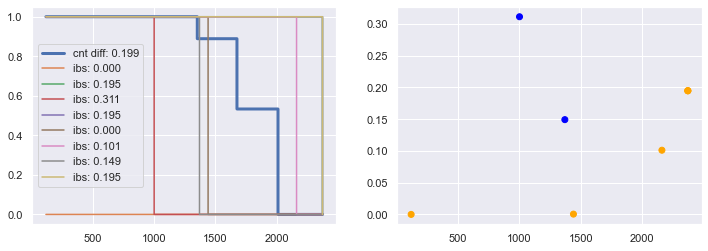

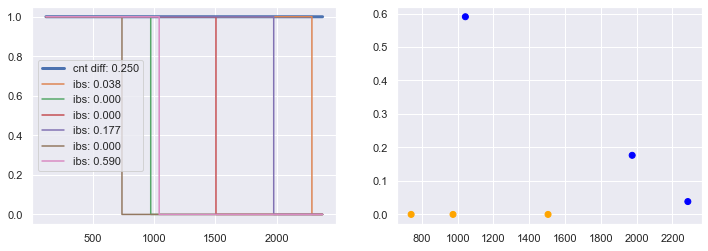

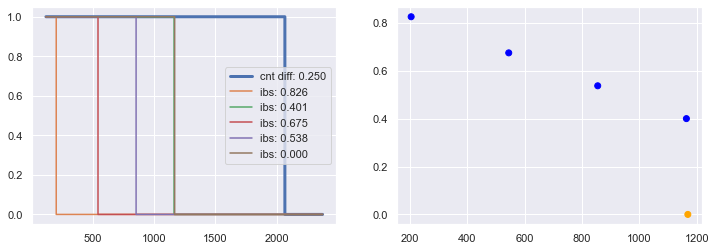

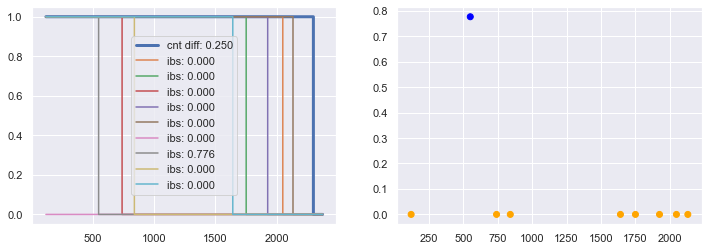

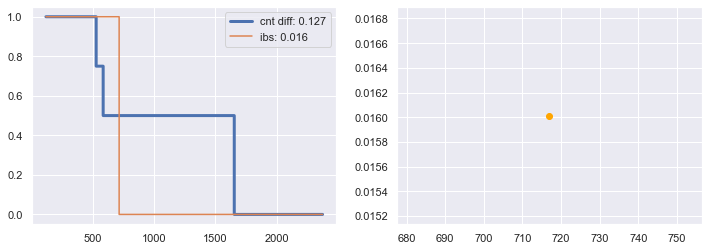

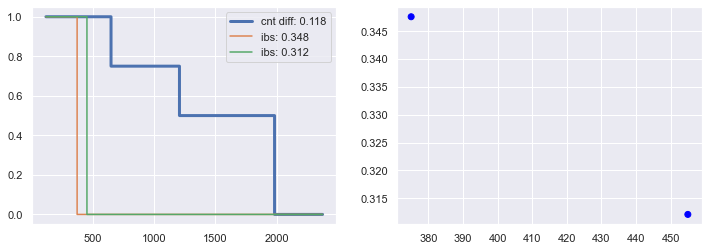

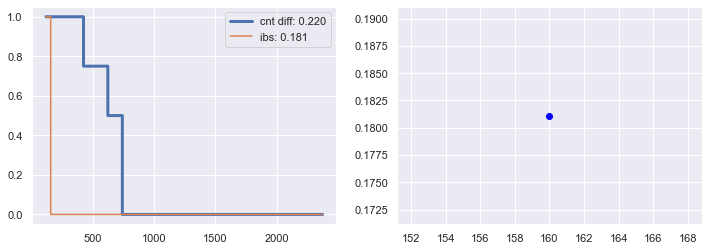

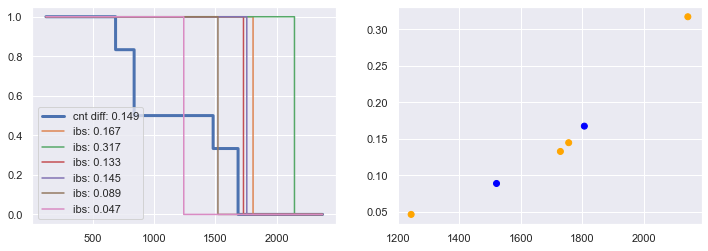

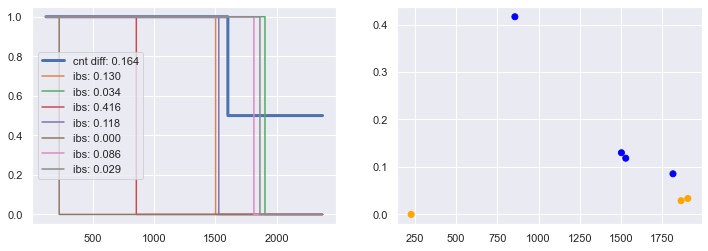

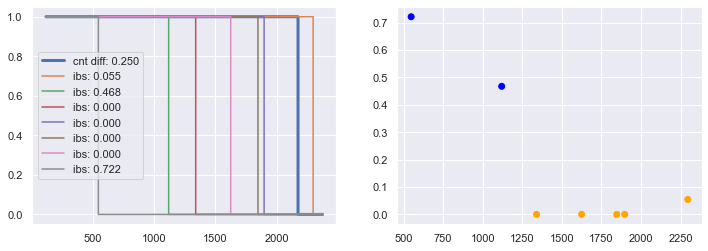

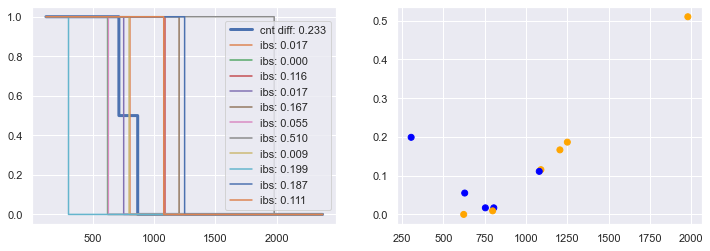

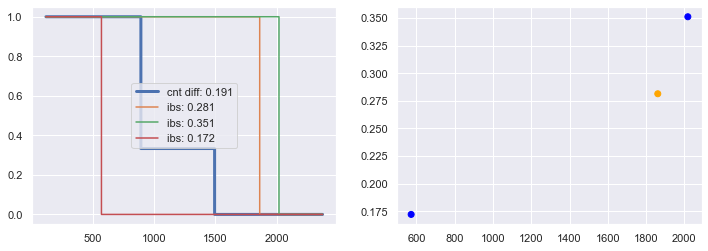

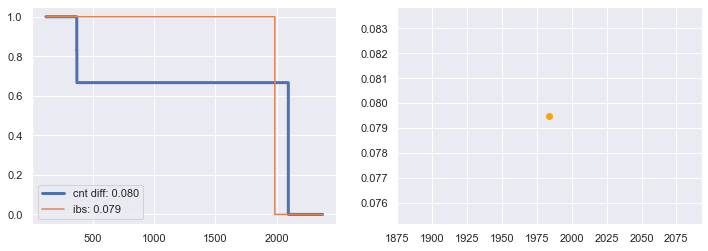

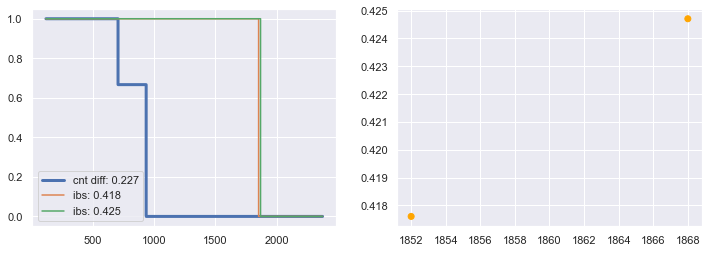

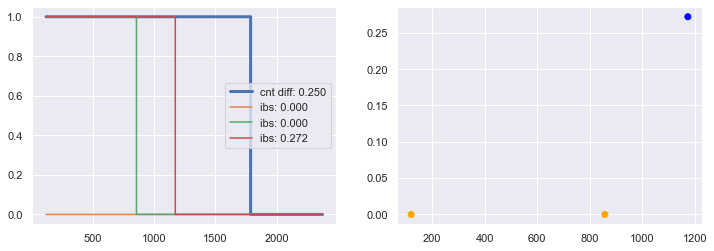

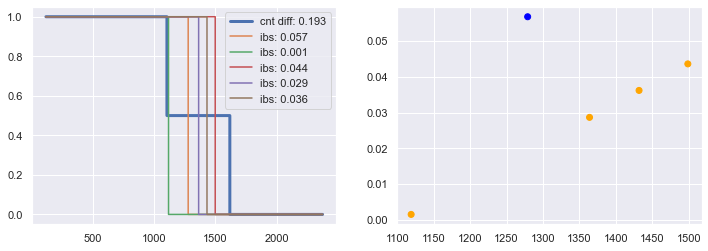

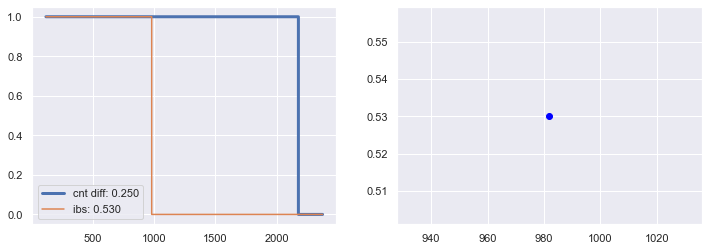

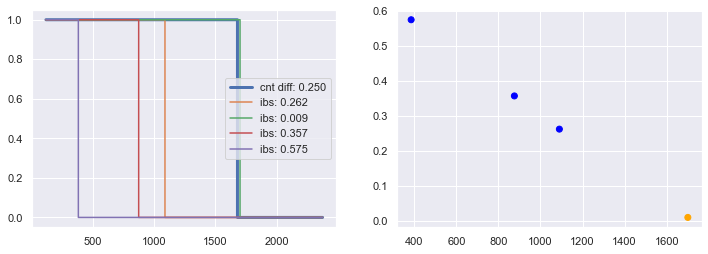

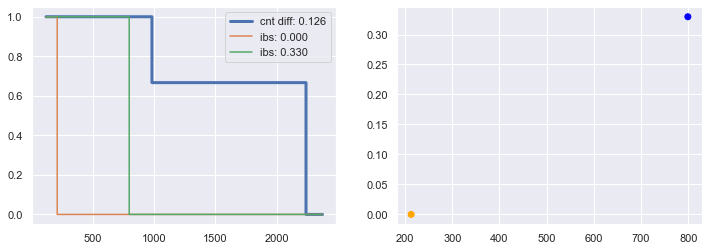

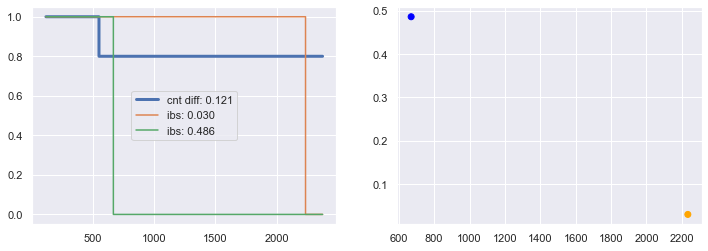

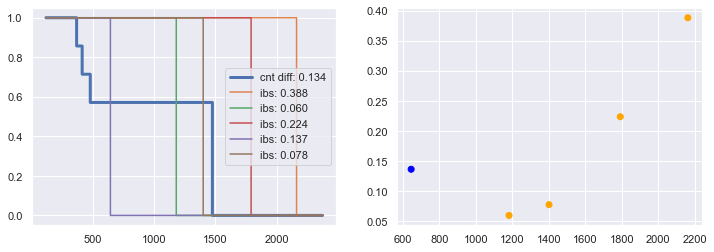

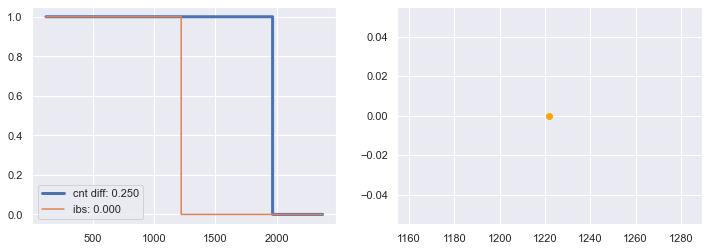

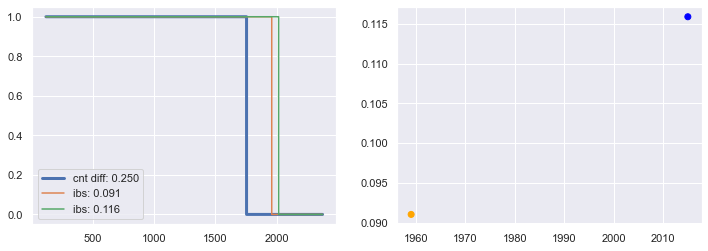

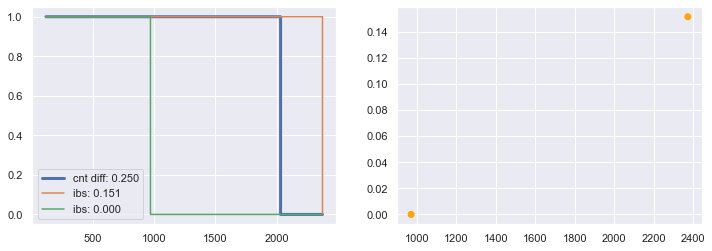

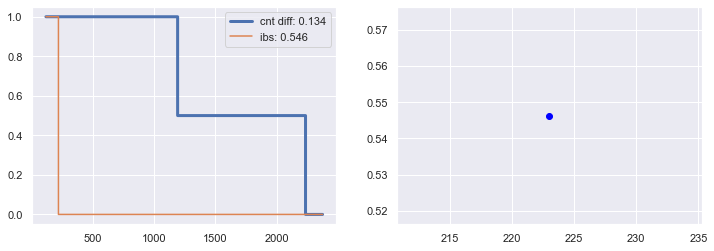

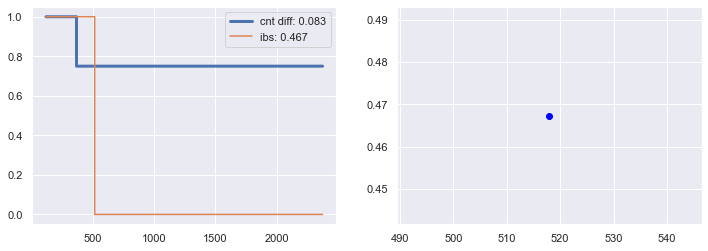

In [1332]:
for n_numb in np.unique(nodes):
    n = bstr.models[0].nodes[n_numb]
    y_HO_ = y_HO[np.where(nodes == n_numb)[0]]
    ibs_ = ibss[np.where(nodes == n_numb)[0]]
    
    sf = n.leaf_model.predict_survival_at_times(X=None, bins=bins_HO)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].step(bins_HO, sf, label=f"cnt diff: {np.sum((sf - 0.5)**2) / sf.shape[0]:.3f}", linewidth=3)
    for l_y, l_ibs in zip(y_HO_, ibs_):
        axes[0].step(bins_HO, np.where(bins_HO < l_y["time"], 1, 0), label=f"ibs: {l_ibs:.3f}")
    axes[0].legend()
    
    axes[1].scatter(y_HO_["time"], ibs_, c=np.where(y_HO_["cens"], "blue", "orange"))
    plt.show()

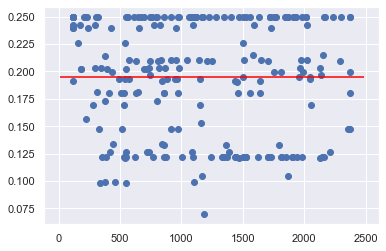

In [1322]:
sfs = bstr.models[0].predict_at_times(X=X_HO, mode="surv", bins=bins_HO)
nodes = bstr.models[0].predict(X=X_HO, target="numb")

ibss = metr.ibs_WW(y_tr, y_HO, sfs, bins_HO, axis=0)
plt.scatter(y_HO["time"], np.sum((sfs - 0.5)**2, axis=1) / sfs.shape[1])
xmin, xmax, ymin, ymax = plt.axis()
plt.hlines([np.mean(np.sum((sfs - 0.5)**2, axis=1) / sfs.shape[1])], 
           xmin=xmin, xmax=xmax, color="red")

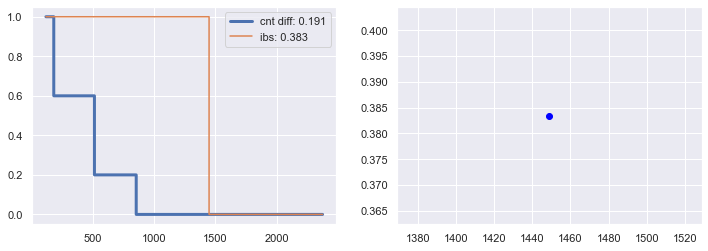

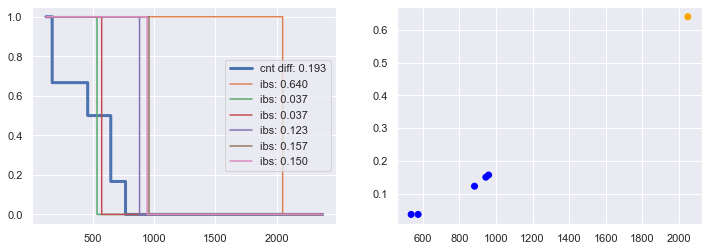

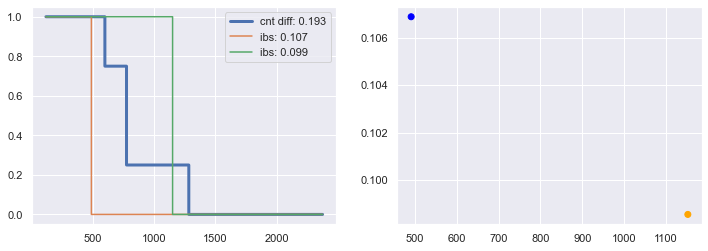

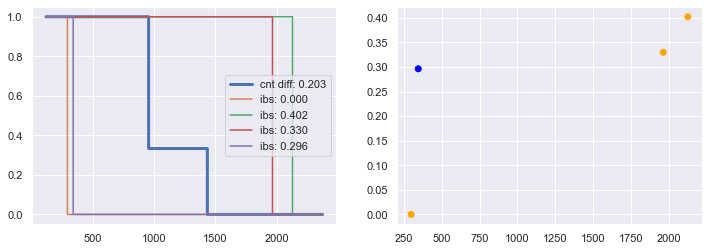

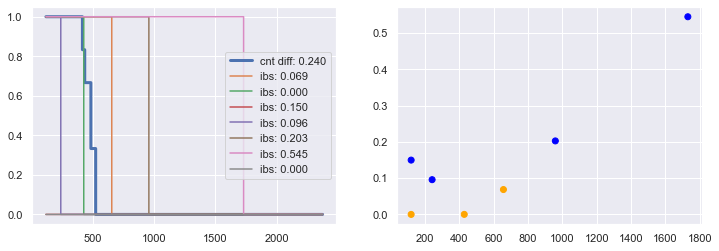

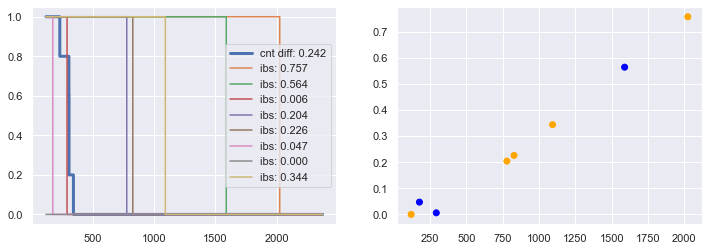

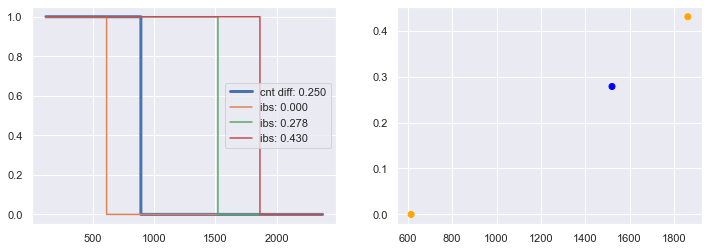

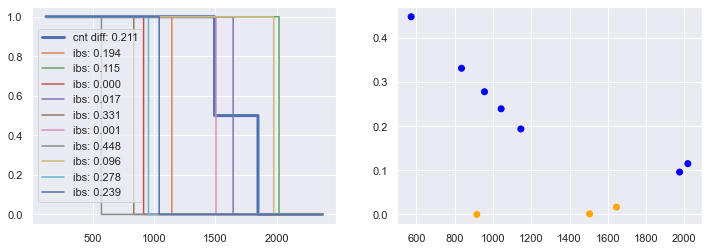

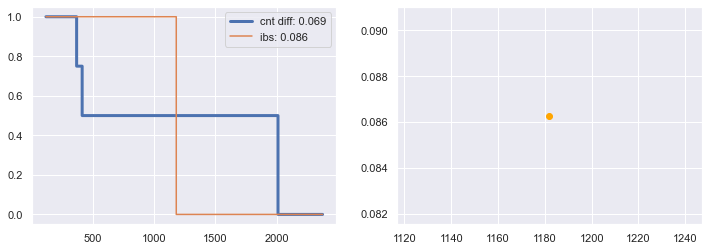

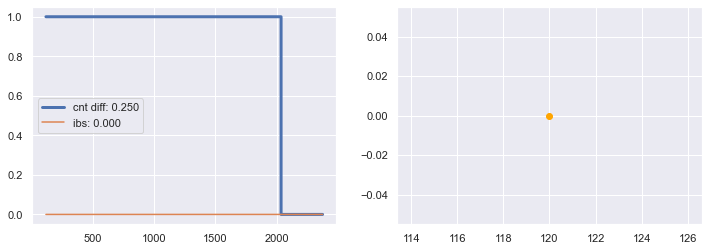

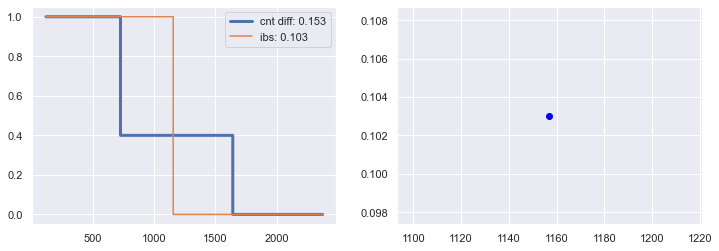

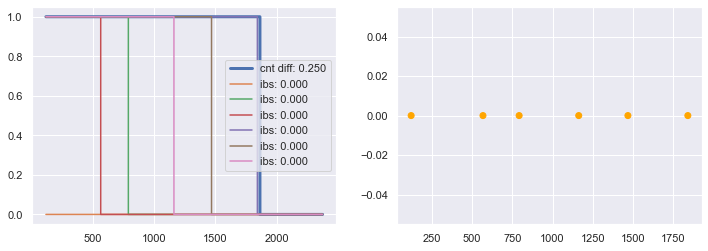

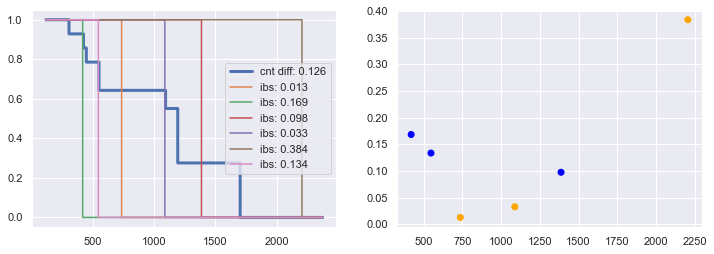

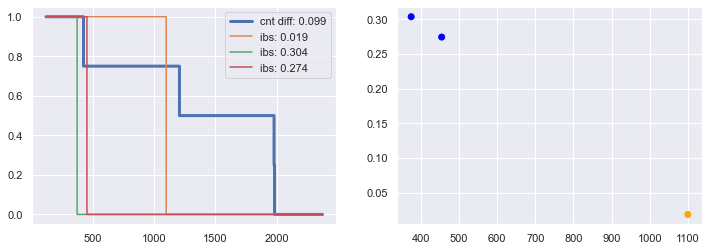

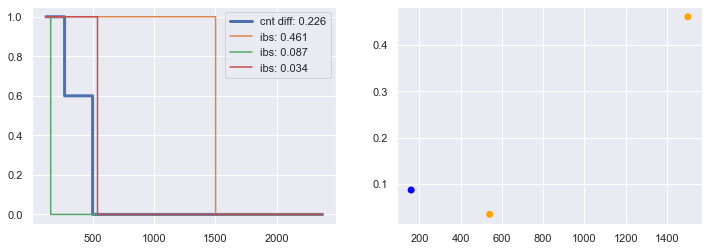

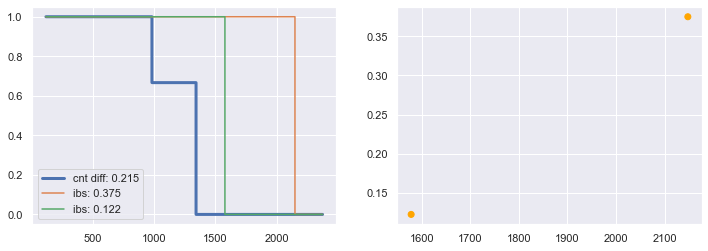

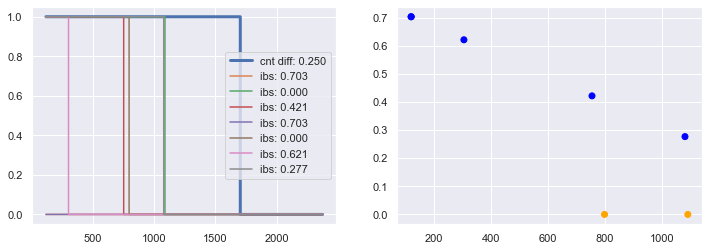

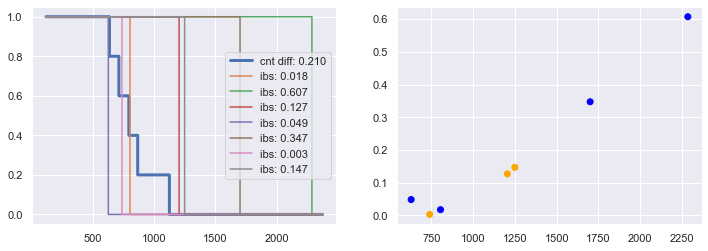

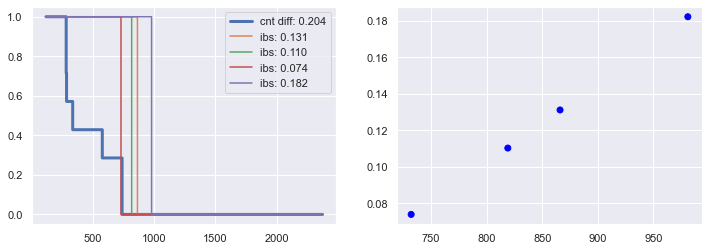

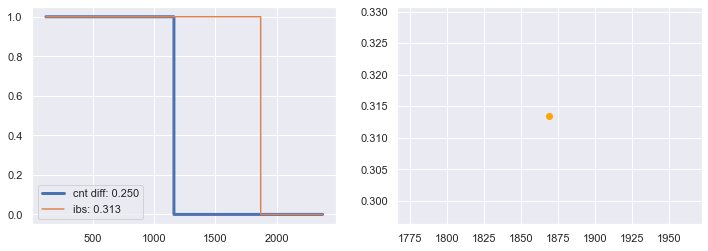

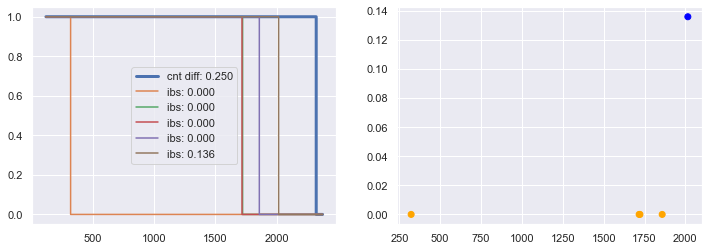

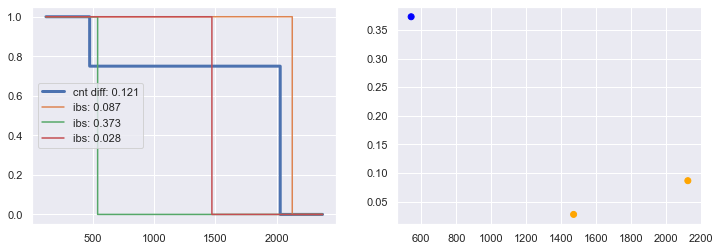

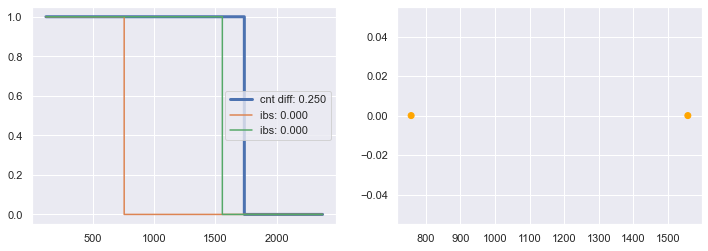

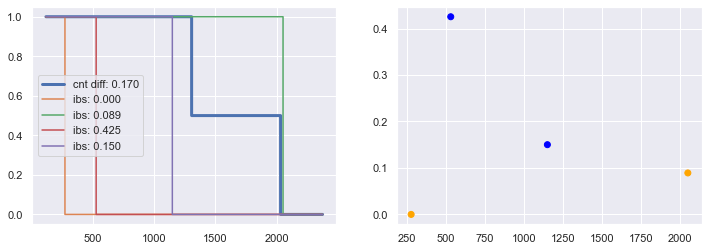

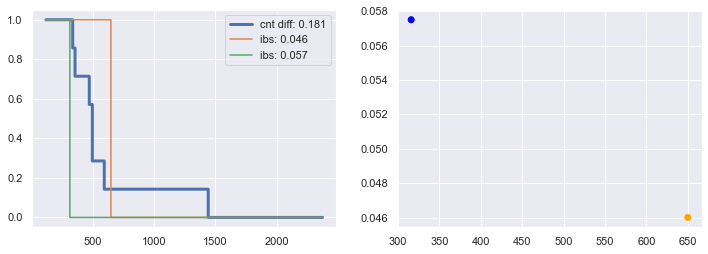

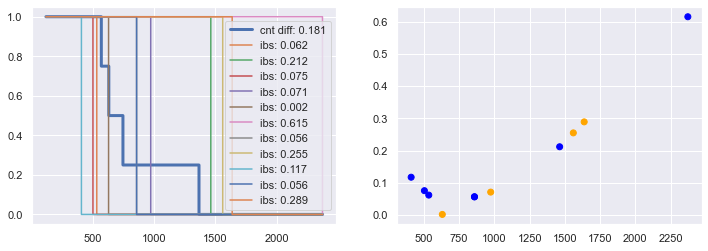

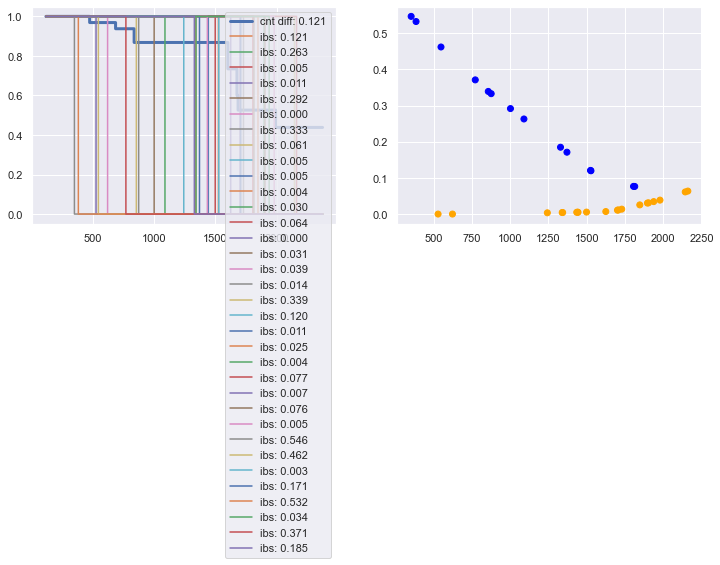

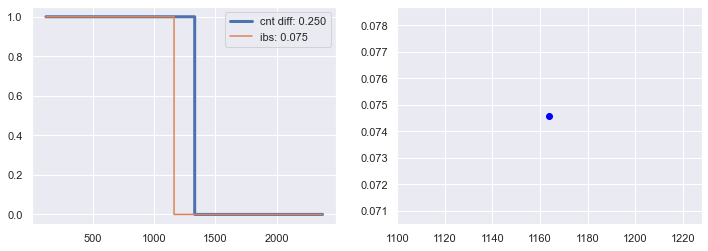

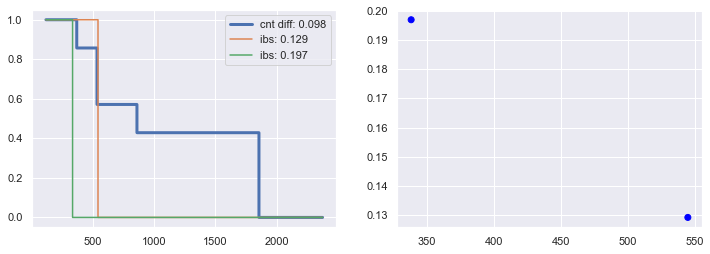

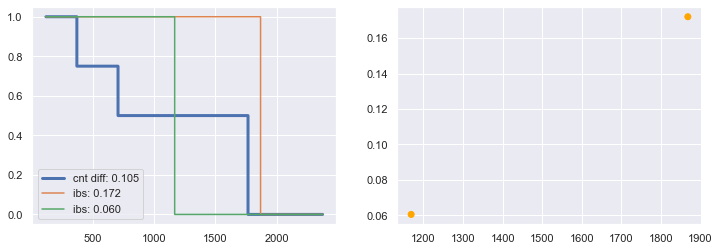

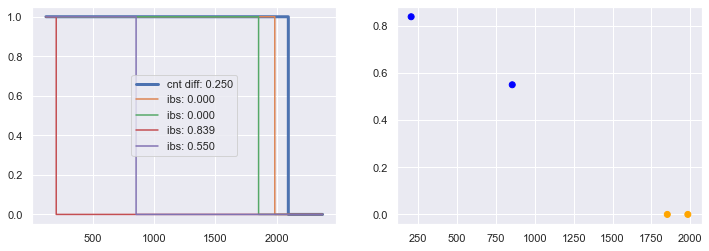

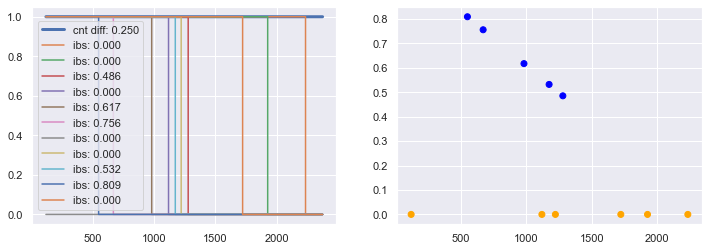

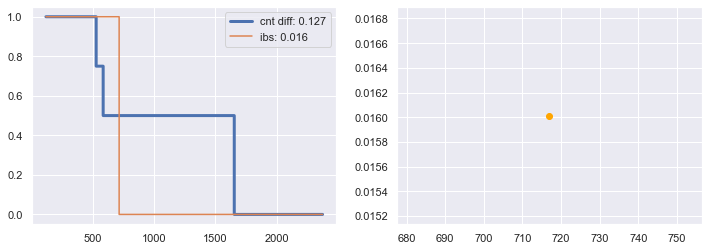

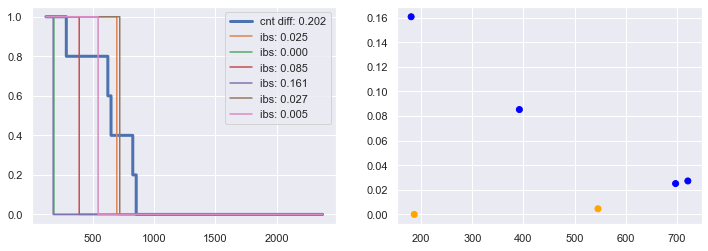

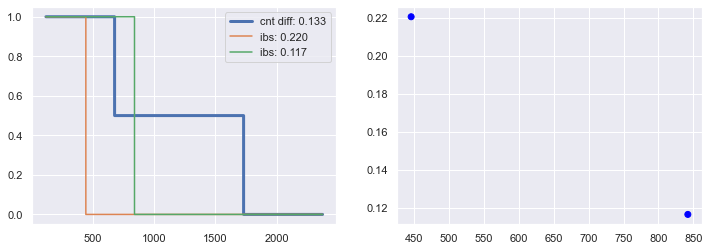

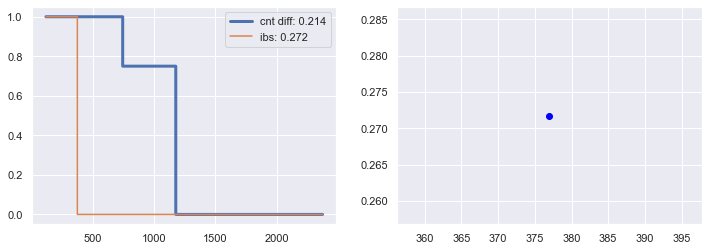

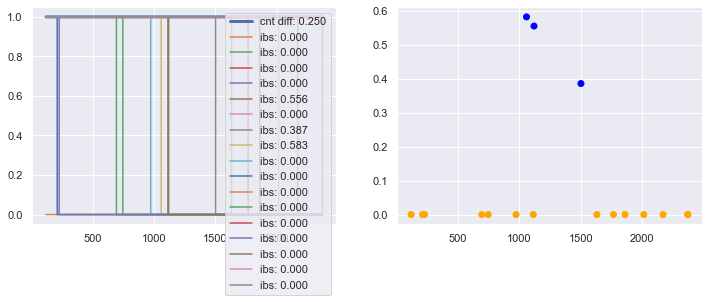

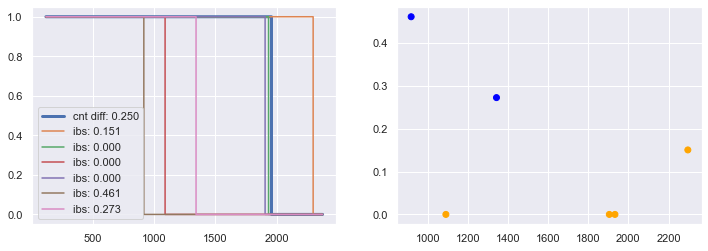

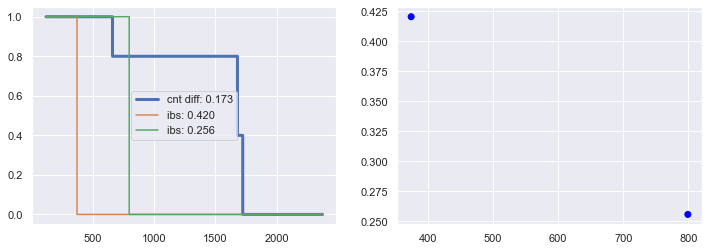

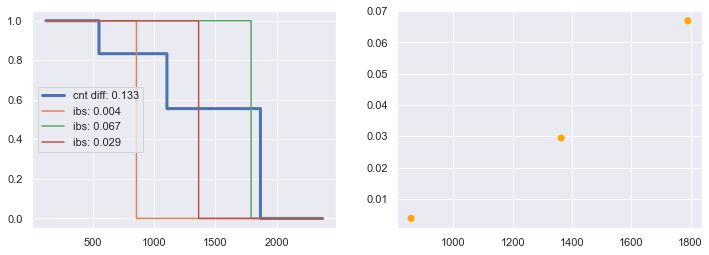

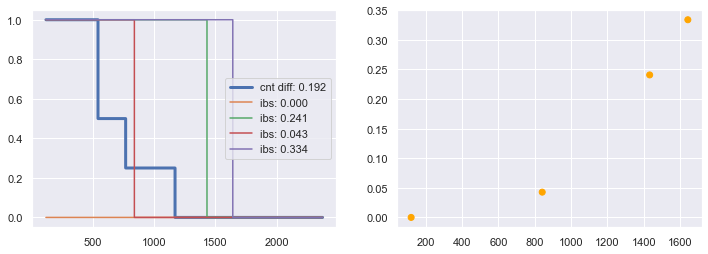

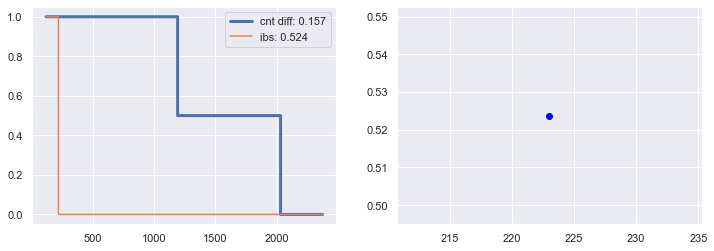

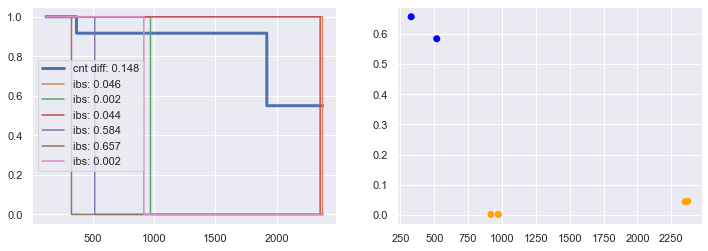

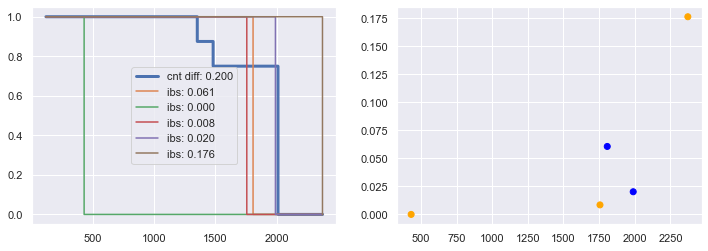

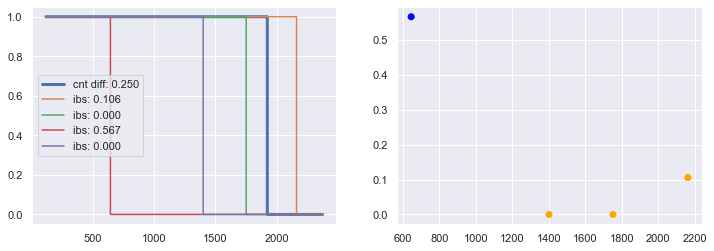

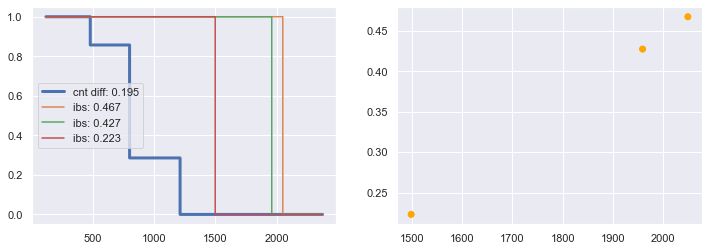

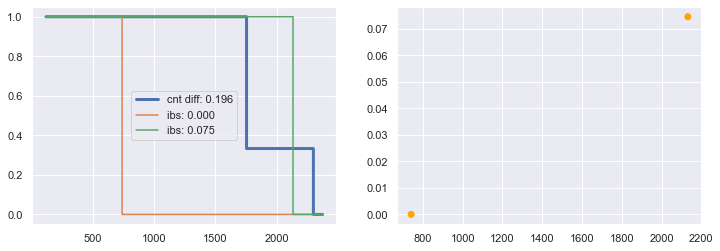

In [1323]:
for n_numb in np.unique(nodes):
    n = bstr.models[0].nodes[n_numb]
    y_HO_ = y_HO[np.where(nodes == n_numb)[0]]
    ibs_ = ibss[np.where(nodes == n_numb)[0]]
    
    sf = n.leaf_model.predict_survival_at_times(X=None, bins=bins_HO)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].step(bins_HO, sf, label=f"cnt diff: {np.sum((sf - 0.5)**2) / sf.shape[0]:.3f}", linewidth=3)
    for l_y, l_ibs in zip(y_HO_, ibs_):
        axes[0].step(bins_HO, np.where(bins_HO < l_y["time"], 1, 0), label=f"ibs: {l_ibs:.3f}")
    axes[0].legend()
    
    axes[1].scatter(y_HO_["time"], ibs_, c=np.where(y_HO_["cens"], "blue", "orange"))
    plt.show()